# <font color = 'Blue'> House Price Prediction
    
## <font color = 'Green'>Problem statement


To build a regression model for a US-based housing company named Suprise Housing that has decided to expand business opportunity in  Australian market and needs understand the different parameters which are significant in predicting price of the house.


## <font color = 'Green'> Business Goal

`(1) Understanding which variables are significant in predicting the price of a house `<br>
`(2) the model will be a good way for management to understand the pricing dynamics of a new market..`


In [1]:
##Igore Warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
##Importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import sklearn
from sklearn.preprocessing import scale 

from sklearn.model_selection import train_test_split   #train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge #Ridge and Lasso Regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error  #Evaluation Metrics

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## <font color = 'Green'> Generic Functions 
 As we require to EDA for indepedent variables and depedent variable , lets create few generic methods which can be reused.`

In [3]:
## create generic function to plot categorical variable 
def plot_bar_categorial_percentage(data,column):
    ab = pd.DataFrame((data[column].value_counts(normalize=True)*100).round(0).sort_values())
    ab.reset_index(inplace=True)
    ab1 = sns.barplot(x='index',y=column, data=ab, palette='Set1')
        
    plt.setp(ab1.get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.xlabel(column, fontsize= 14, fontstyle='italic')
    plt.ylabel('Frequency(%count of total)', fontsize= 14, fontstyle='italic')
    plt.title(column+' Analysis', fontsize=16, fontweight='bold')
    plt.grid(True)
        
    for i in ab1.patches:
        ab1.annotate(format(i.get_height())+"%", (i.get_x() + i.get_width() / 2.\
                                                         , i.get_height()), ha = 'center'\
                , va = 'center', xytext = (0, 10), textcoords = 'offset points',rotation=45, fontsize=11)
        
            

In [4]:
def get_cols_imbal(data, prcnt):
    df1= data.copy()
    my_list= []
    cat_obj_cols = df1.select_dtypes(include=['object'])
    for col in (cat_obj_cols):
        if(df1[col].value_counts().max() > int(prcnt*len(df1.index)/100)):
            my_list.append(col)
    return my_list

In [5]:
## for better reading and DRY
def show_plot(plt):
    plt.grid(True)
    plt.tight_layout()
    plt.autoscale()
    plt.show()

In [6]:
## for better reading and DRY
def show_box_plot(plt,data,field):
    plt.figure(figsize=(20, 12))
    plt.subplot(2,4,1)
    sns.boxplot(x=data[field])

    plt.show()

In [7]:
def get_num_cols_imbal(data, prcnt):
    df1= data.copy()
    my_list= []
    num_cols = df1.select_dtypes(include=['int64','float64','int32','float32'])
    for col in (num_cols):
        if(df1[col].value_counts().max() > int(prcnt*len(df1.index)/100)):
            my_list.append(col)
    return my_list

In [8]:
def scatter_plt(data,column1,column2,column3,target,subp):
    plt.figure(figsize=(15,5), dpi=150)
    sns.set_style("white")
    #subplot (131)
    if subp == 3:
        x=1
        y=3
        z=1
    elif subp ==2:
        x=1
        y=2
        z=1
    plt.subplot(x,y,z)
    plt.scatter(x= data[column1], y= df[target])
    plt.title((target + " vs "+ column1), fontweight='bold', fontsize=15)
    plt.xlabel(column1, fontsize=13, fontstyle='italic')
    plt.ylabel(target, fontsize=13, fontstyle='italic')
    plt.grid(True)
    z = z+1
    #subplot (132)
    plt.subplot(x,y,z)
    plt.scatter(x= data[column2], y= df[target])
    plt.title((target + " vs "+ column2), fontweight='bold', fontsize=15)
    plt.xlabel(column2, fontsize=13, fontstyle='italic')
    plt.ylabel(target, fontsize=13, fontstyle='italic')
    plt.grid(True)
    #subplot (133)
    if z != y:
        z = z+1
        plt.subplot(x,y,z)
        plt.scatter(x= data[column3], y= df[target])
        plt.title((target + " vs "+ column3), fontweight='bold', fontsize=15)
        plt.xlabel(column2, fontsize=13, fontstyle='italic')
        plt.ylabel(target, fontsize=13, fontstyle='italic')
        plt.grid(True)
    
    plt.autoscale()
    plt.tight_layout()
    plt.show()
    

In [9]:
def create_dummies(data,list_column,prefix1):
    s = []
    #this FOR loop is purely for creating and storing the dynamic variable names in s
    for x in range(1,len(orig_before_dum_cols),+1):
        s.append(prefix1 + str(list_column[x]))
    for i in s:
        i = pd.get_dummies(data[i[3:]], prefix= i, drop_first = True)
        data = pd.concat([data, i], axis = 1)
    return data

In [10]:
def create_resd_qqplot(data,target,title):
    ##tranforming the target variable 'SalePrice' using Log-Transform. SalePrice Distribution (After Log-Transformation)

    from scipy import stats
    from scipy.stats import norm

##lets  apply log(1+x) to all elements of the target variable column
    data[target] = np.log1p(data[target])

    plt.figure(figsize=(6,8), dpi=100)
    plt.subplot(211)
    sns.distplot(data[target], fit=norm)

    (mu, sigma) = norm.fit(data[target])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency', fontsize=10)
    plt.title(title, fontsize=14, fontweight='bold')

    plt.subplot(212)
    res = stats.probplot(data[target], plot=plt)

    plt.autoscale()
    plt.tight_layout()
    plt.show()

In [11]:
def create_scatter_plt_test_pred(y_test_val,y_pred_test_val,title,xlabel,ylabel):
    sns.set_style('white')
    fig = plt.figure(figsize=(6,4), dpi=100)
    plt.scatter(y_test_val,y_pred_test_val)
    fig.suptitle(title, fontsize=18)             
    plt.xlabel(xlabel, fontsize=14)                       
    plt.ylabel(ylabel, fontsize=14)  
    plt.grid(True)
    plt.show()

In [12]:
def create_plt_act_pred(y_train_val,y_pred_train_val,y_train_series,y_pred_train_series,title,xlabel,ylabel):
    sns.set_style('white')
    plt.figure(figsize = (10,4), dpi=120)
    plt.plot(y_train_series, y_pred_train_val, color="blue", linewidth=1, linestyle="-")     #Predicted 'y_pred_train_r' plot
    plt.plot(y_pred_train_series, y_train, color="red",  linewidth=1, linestyle="-")  #Actual 'y_train' plot
    plt.title(title, fontsize=15, fontweight='bold')    
    plt.xlabel(xlabel, fontsize=15, fontstyle='italic')                              
    plt.ylabel(ylabel, fontsize=15, fontstyle='italic')  
    plt.show()

In [13]:
##Creating a function to find binary value columns from the 'df' dataframe (if any)
def binary_val_cols(data):
    df_1 = data.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol


## <font color='Blue'> Step 1: Reading and Understanding the Data

### <font color='Green'> Data Sourcing

The default encoding of 'train.csv' file is detected as 'ascii' with 100% confidence level. Hence, we can proceed.

In [14]:

df = pd.read_csv("train.csv")
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [15]:
##check shape of the dataset
total_records= df.shape[0]  #storing total no. of records in a variable to check if we have  deleted many rows.
df.shape

(1460, 81)

In [16]:
df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## <font color='Blue'> Step 2: Data Cleaning and Manipulation

In [18]:
##check and drop duplicates
df = df.drop_duplicates()

In [19]:
##check null values and percentage
missing_val_cols_prcnt = round(100*df.isnull().sum()/len(df.index),2)
missing = pd.DataFrame(missing_val_cols_prcnt[missing_val_cols_prcnt!=0])
missing

0
LotFrontage   17.74
Alley         93.77
MasVnrType     0.55
MasVnrArea     0.55
BsmtQual       2.53
BsmtCond       2.53
BsmtExposure   2.60
BsmtFinType1   2.53
BsmtFinType2   2.60
Electrical     0.07
FireplaceQu   47.26
GarageType     5.55
GarageYrBlt    5.55
GarageFinish   5.55
GarageQual     5.55
GarageCond     5.55
PoolQC        99.52
Fence         80.75
MiscFeature   96.30

In [20]:
missing_values = round((df.isnull().sum()/len(df.Id))*100, 2) 
print(missing_values)

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
Street            0.00
Alley            93.77
LotShape          0.00
LandContour       0.00
Utilities         0.00
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.00
Exterior2nd       0.00
MasVnrType        0.55
MasVnrArea        0.55
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.53
BsmtCond          2.53
BsmtExposure      2.60
BsmtFinType1      2.53
BsmtFinSF1        0.00
BsmtFinType2      2.60
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.07
1stFlrSF   

Let's drop those columns having > 80% missing values

In [21]:
columns_with_missing_values = list(missing_values[missing_values >=80].index)
print(columns_with_missing_values)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [22]:
df = df.drop(columns_with_missing_values,axis=1)
df.shape

(1460, 77)

In [23]:
df.nunique().sort_values()

Street              2
Utilities           2
CentralAir          2
PavedDrive          3
HalfBath            3
LandSlope           3
BsmtHalfBath        3
GarageFinish        3
Fireplaces          4
FullBath            4
KitchenAbvGr        4
KitchenQual         4
MasVnrType          4
BsmtFullBath        4
LandContour         4
LotShape            4
BsmtQual            4
BsmtCond            4
BsmtExposure        4
ExterQual           4
HeatingQC           5
Electrical          5
ExterCond           5
YrSold              5
FireplaceQu         5
BldgType            5
GarageCars          5
LotConfig           5
GarageQual          5
GarageCond          5
MSZoning            5
GarageType          6
SaleCondition       6
Heating             6
BsmtFinType2        6
BsmtFinType1        6
Foundation          6
RoofStyle           6
Functional          7
Condition2          8
BedroomAbvGr        8
RoofMatl            8
HouseStyle          8
PoolArea            8
Condition1          9
OverallCon

In [24]:
##check if any null values in categorical column

cat_obj_null_cols = df.select_dtypes(include='object')   #Retaining only object types categorical columns and their null value %
missing_cat_obj_null_prcnt = round(100*cat_obj_null_cols.isnull().sum()/len(cat_obj_null_cols.index),2)
missing_cat_obj_null_prcnt = missing_cat_obj_null_prcnt[missing_cat_obj_null_prcnt!=0]
missing_cat_obj_null_prcnt

MasVnrType       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64

In [25]:
## as it is categorical variable and have some meaningful information as per data dictionary , lets fill as of now None 

cat_null_obj_cols = [ 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','Electrical']
for column in cat_null_obj_cols:
    df[column]= df[column].fillna('None')

In [26]:
##check null values in the categorical columns (only object types).

cat_obj_null_cols = df.select_dtypes(include='object')   #Retaining only object types categorical columns
missing_cat_obj_null_prcnt = round(100*cat_obj_null_cols.isnull().sum()/len(cat_obj_null_cols.index),2)
missing_cat_obj_null_prcnt = missing_cat_obj_null_prcnt[missing_cat_obj_null_prcnt!=0]
missing_cat_obj_null_prcnt

Series([], dtype: float64)

**Dealing with data imbalance (categorical variables: object):** Removing variablea  that have more than `80%` data associated to one single value.as those variables will not inflence our prediction

In [27]:

columns_to_be_removed = get_cols_imbal(data=df, prcnt=80)  
print("Categorical object type columns removed:",columns_to_be_removed)
print("\nNumber of categorical object type columns removed: ", len(columns_to_be_removed),"\n")
df = df.drop(columns_to_be_removed, axis=1)
df.head()

Categorical object type columns removed: ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

Number of categorical object type columns removed:  20 



Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0      CollgCr     2Story            7            5       2003          2003   
1      Veenker     1Story            6            8       1976          1976   
2      CollgCr     2Story            7            5       2001          2002   
3      Crawfor     2Story            7            5       1915          1970   
4      NoRidge     2Story            8            5       2000          2000   

  RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable     VinylSd     VinylSd    BrkFace       196.0        Gd   
1     Gable     MetalSd     MetalSd       None         0.0        TA   
2     Gable     VinylSd     VinylSd    BrkFace       162.0        Gd   
3     Gable     Wd Sdng     Wd Shng       None         0.0        TA   
4     Gable     VinylSd     VinylSd    BrkFace       350.0        Gd   

  Foundation BsmtQual BsmtExposure BsmtFinType1  BsmtFinSF1  BsmtFinSF2  \
0      PConc       Gd           No          GLQ         706           0   
1     CBlock       Gd           Gd          ALQ         978           0   
2      PConc       Gd           Mn          GLQ         486           0   
3     BrkTil       TA           No          ALQ         216           0   
4      PConc       Gd           Av          GLQ         655           0   

   BsmtUnfSF  TotalBsmtSF HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        150          856        Ex       856       854             0   
1        284         1262        Ex      1262         0             0   
2        434          920        Ex       920       866             0   
3        540          756        Gd       961       756             0   
4        490         1145        Ex      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd  Fireplaces FireplaceQu GarageType  \
0             1          Gd             8           0        None     Attchd   
1             1          TA             6           1          TA     Attchd   
2             1          Gd             6           1          TA     Attchd   
3             1          Gd             7           1          Gd     Detchd   
4             1          Gd             9           1          TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0          RFn           2         548           0           61   
1       1976.0          RFn           2         460         298            0   
2       2001.0          RFn           2         608           0           42   
3       1998.0          Unf           3         642           0           35   
4       2000.0          RFn           3         836         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272         

In [28]:
df.shape

(1460, 57)

In [29]:
##rechecking null values in the categorical columns

cat_obj_null_cols = df.select_dtypes(include='object')  
missing_cat_obj_null_prcnt = round(100*cat_obj_null_cols.isnull().sum()/len(cat_obj_null_cols.index),2)
missing_cat_obj_null_prcnt = missing_cat_obj_null_prcnt[missing_cat_obj_null_prcnt!=0]
missing_cat_obj_null_prcnt

Series([], dtype: float64)

No more null values in the categorical variables columns (object type). Also, the data imbalance is taken care of.

In [30]:
##creating a dataframe 'df_obj_cat' with object type categorical variables 
obj_type_cat = df.select_dtypes(include='object').columns
df_obj_cat = df.loc[:,obj_type_cat]
df_obj_cat.head()

MSZoning LotShape LotConfig Neighborhood HouseStyle RoofStyle Exterior1st  \
0       RL      Reg    Inside      CollgCr     2Story     Gable     VinylSd   
1       RL      Reg       FR2      Veenker     1Story     Gable     MetalSd   
2       RL      IR1    Inside      CollgCr     2Story     Gable     VinylSd   
3       RL      IR1    Corner      Crawfor     2Story     Gable     Wd Sdng   
4       RL      IR1       FR2      NoRidge     2Story     Gable     VinylSd   

  Exterior2nd MasVnrType ExterQual Foundation BsmtQual BsmtExposure  \
0     VinylSd    BrkFace        Gd      PConc       Gd           No   
1     MetalSd       None        TA     CBlock       Gd           Gd   
2     VinylSd    BrkFace        Gd      PConc       Gd           Mn   
3     Wd Shng       None        TA     BrkTil       TA           No   
4     VinylSd    BrkFace        Gd      PConc       Gd           Av   

  BsmtFinType1 HeatingQC KitchenQual FireplaceQu GarageType GarageFinish  
0          GLQ        Ex          Gd        None     Attchd          RFn  
1          ALQ        Ex          TA          TA     Attchd          RFn  
2          GLQ        Ex          Gd          TA     Attchd          RFn  
3          ALQ        Gd          Gd          Gd     Detchd          Unf  
4          GLQ        Ex          Gd          TA     Attchd          RFn

**Analysing object type categorical variables**

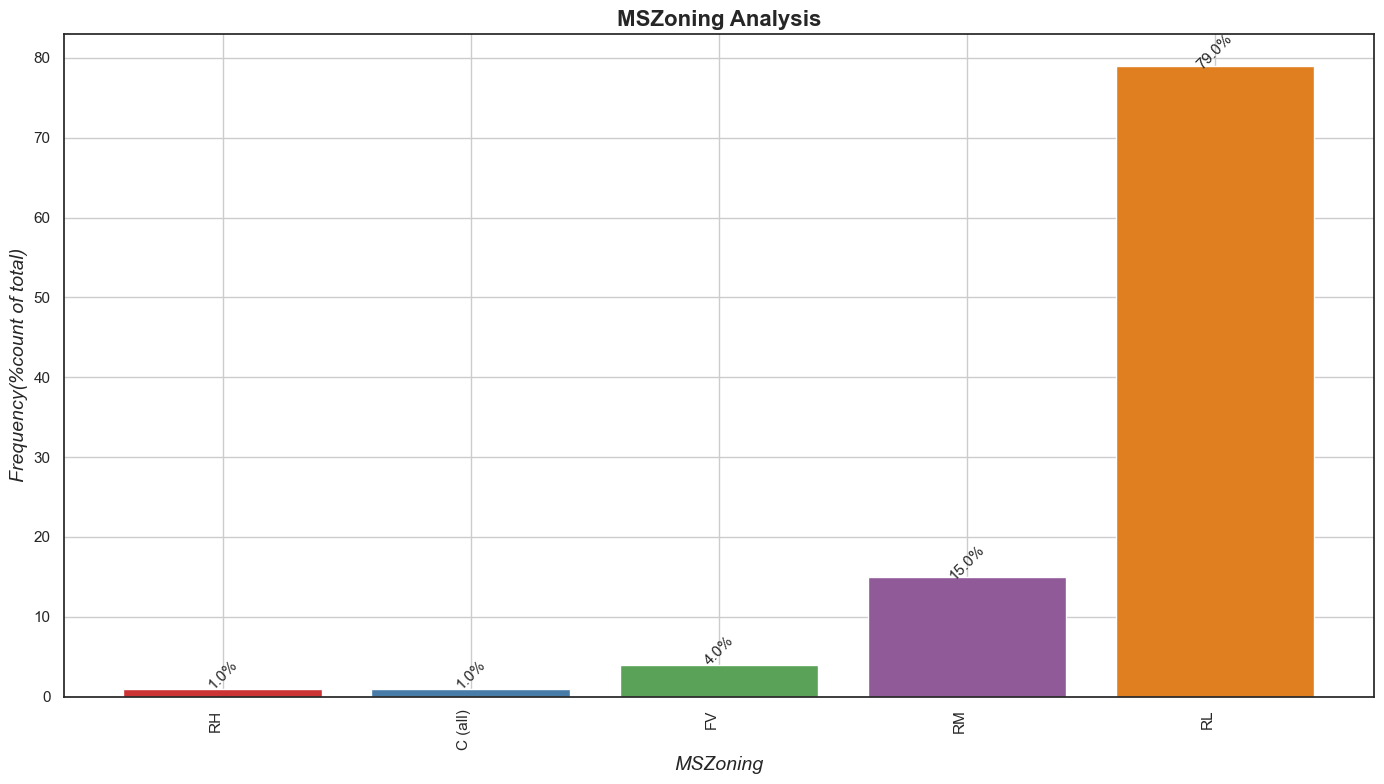

The highest % in  MSZoning category is  [79.0]


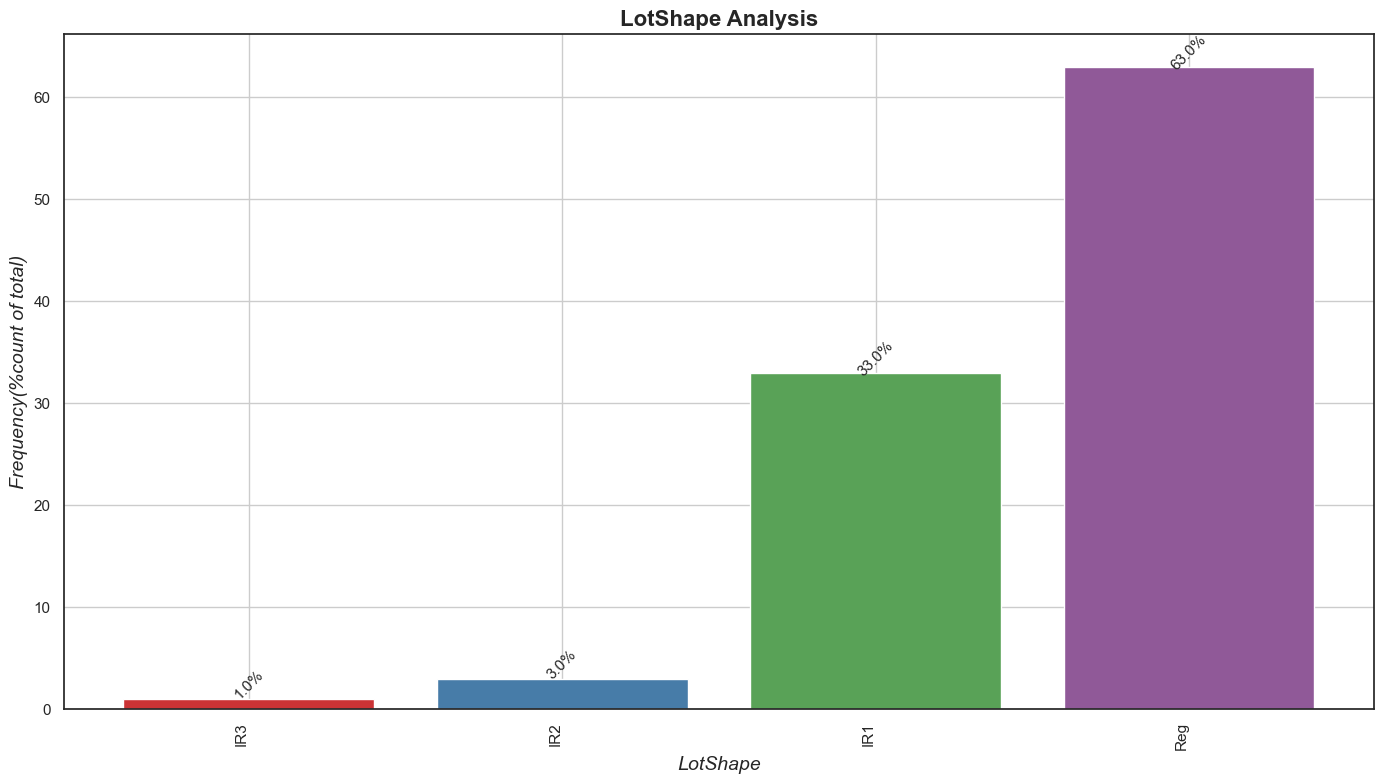

The highest % in  LotShape category is  [63.0]


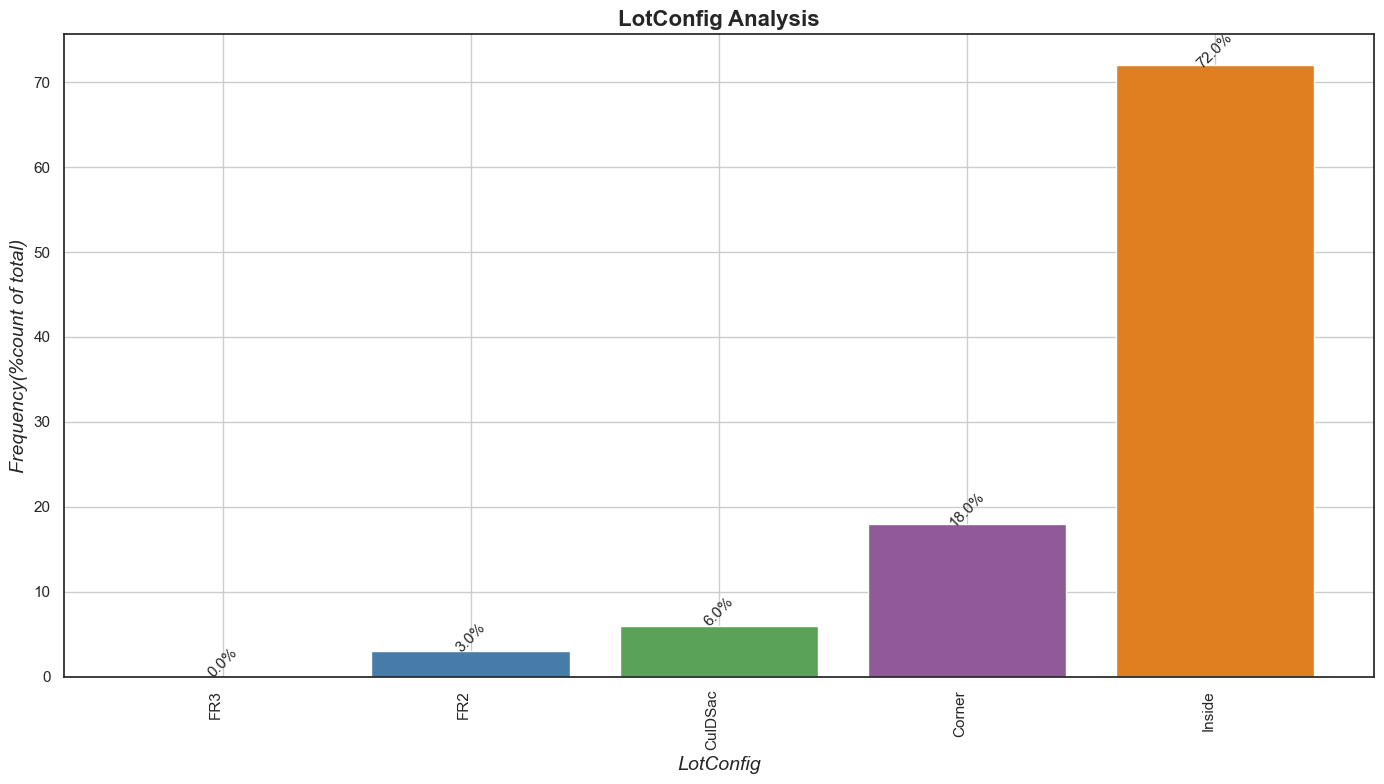

The highest % in  LotConfig category is  [72.0]


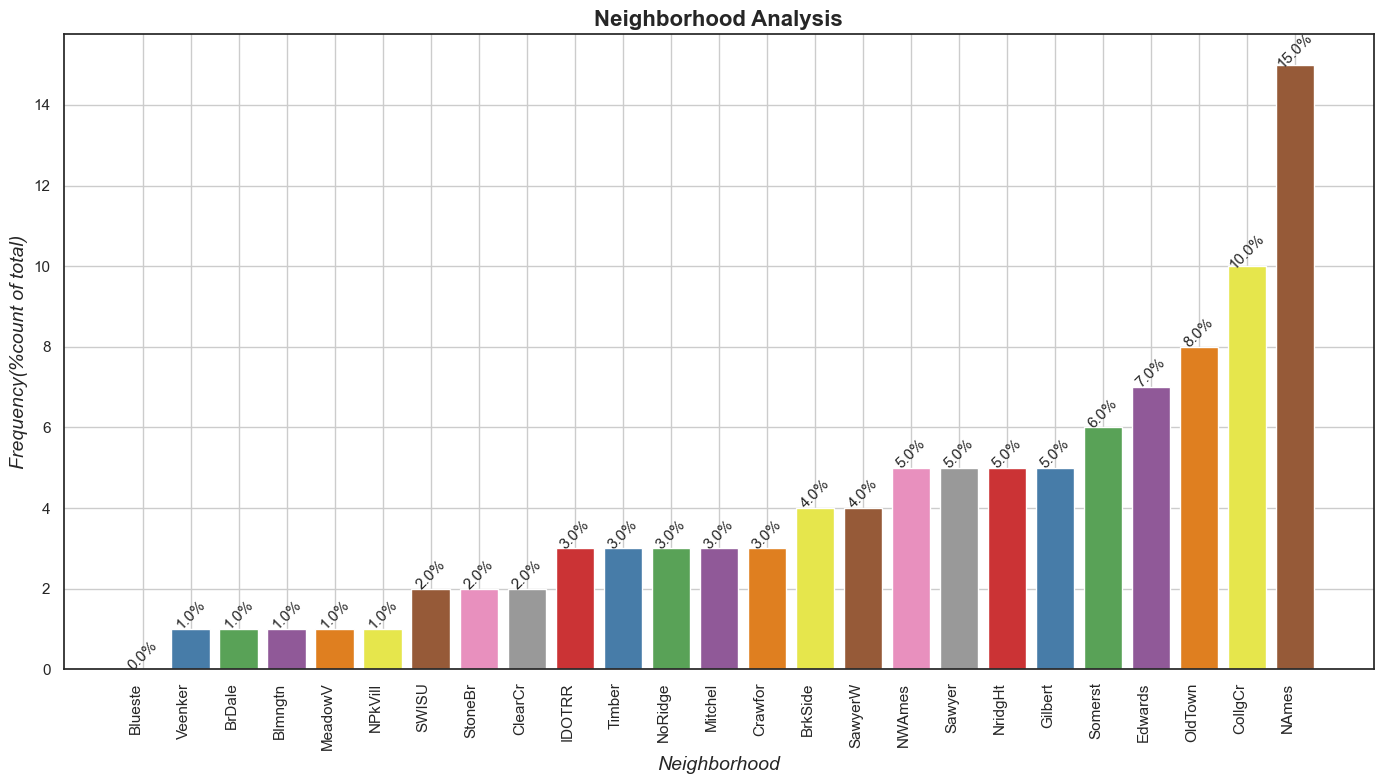

The highest % in  Neighborhood category is  [15.0]


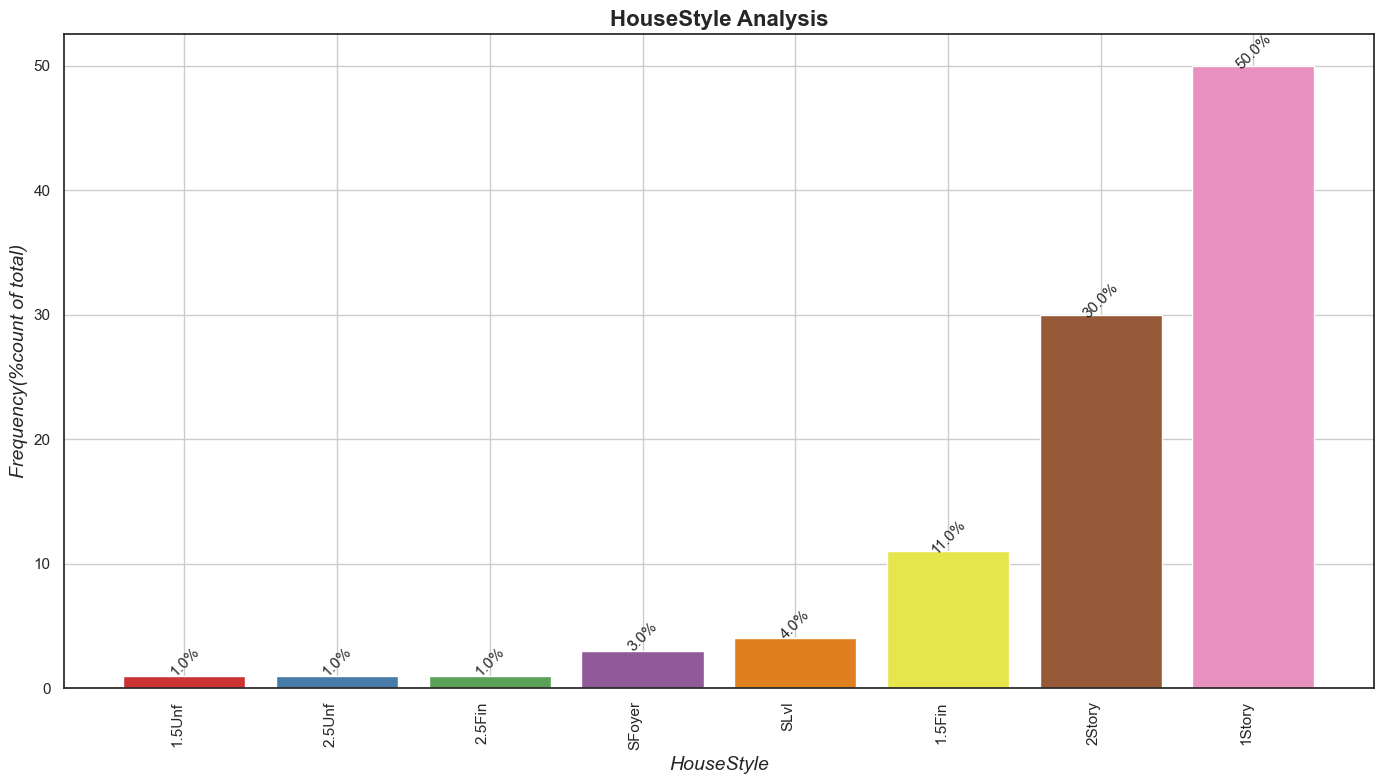

The highest % in  HouseStyle category is  [50.0]


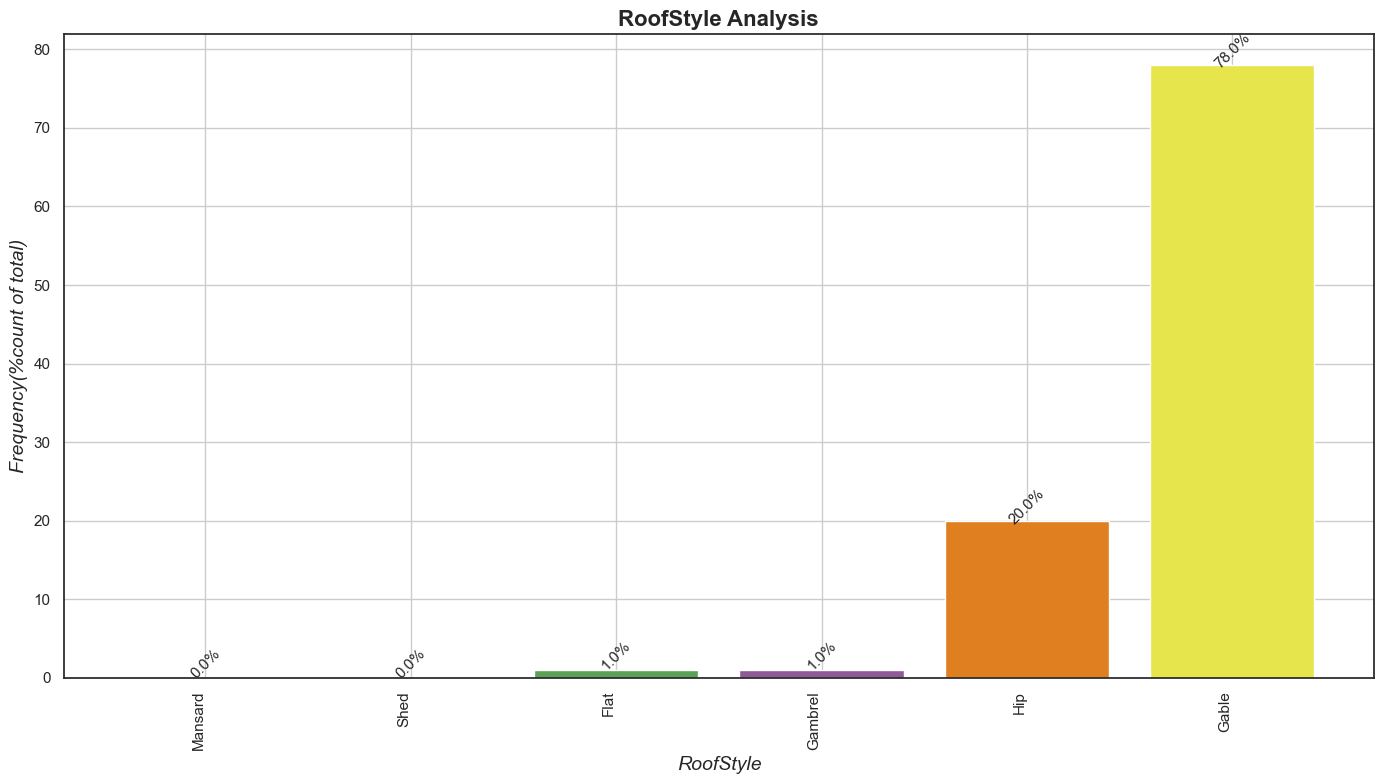

The highest % in  RoofStyle category is  [78.0]


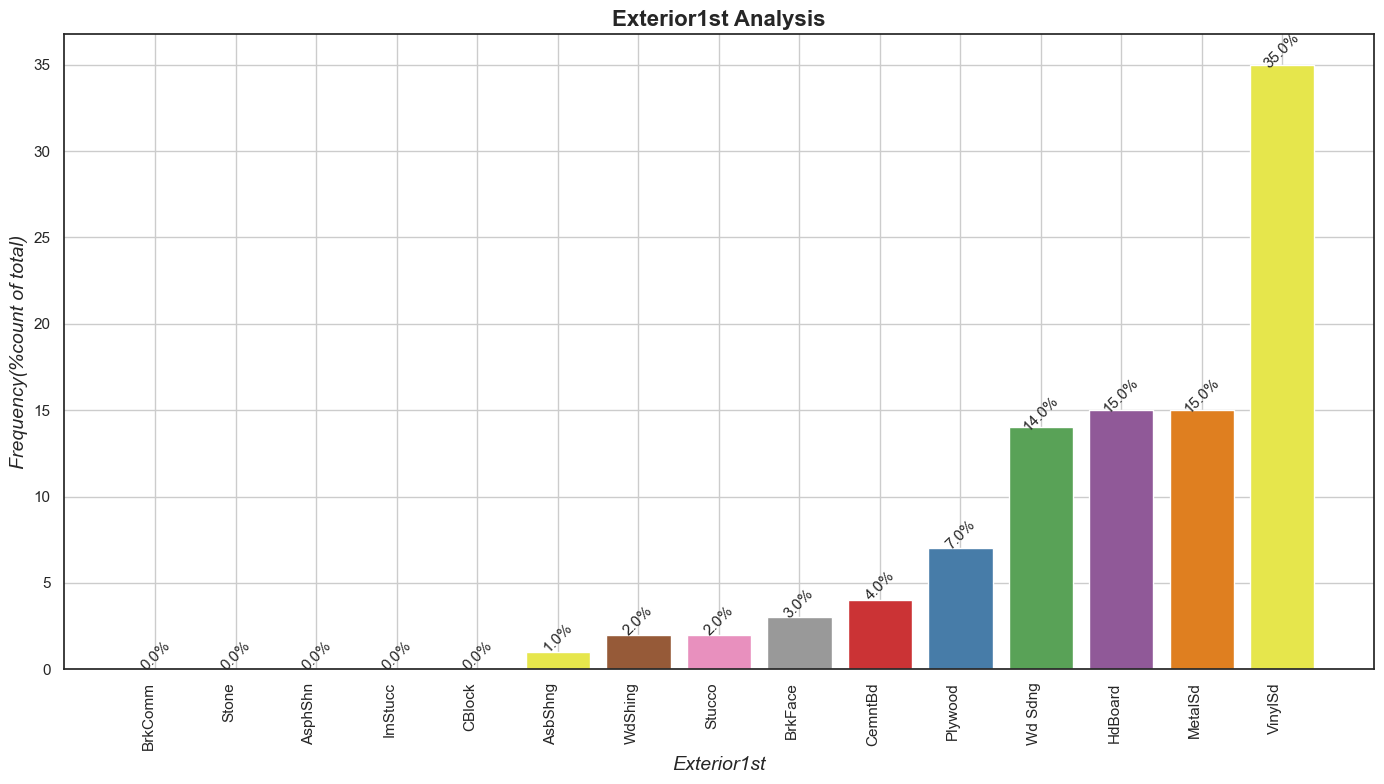

The highest % in  Exterior1st category is  [35.0]


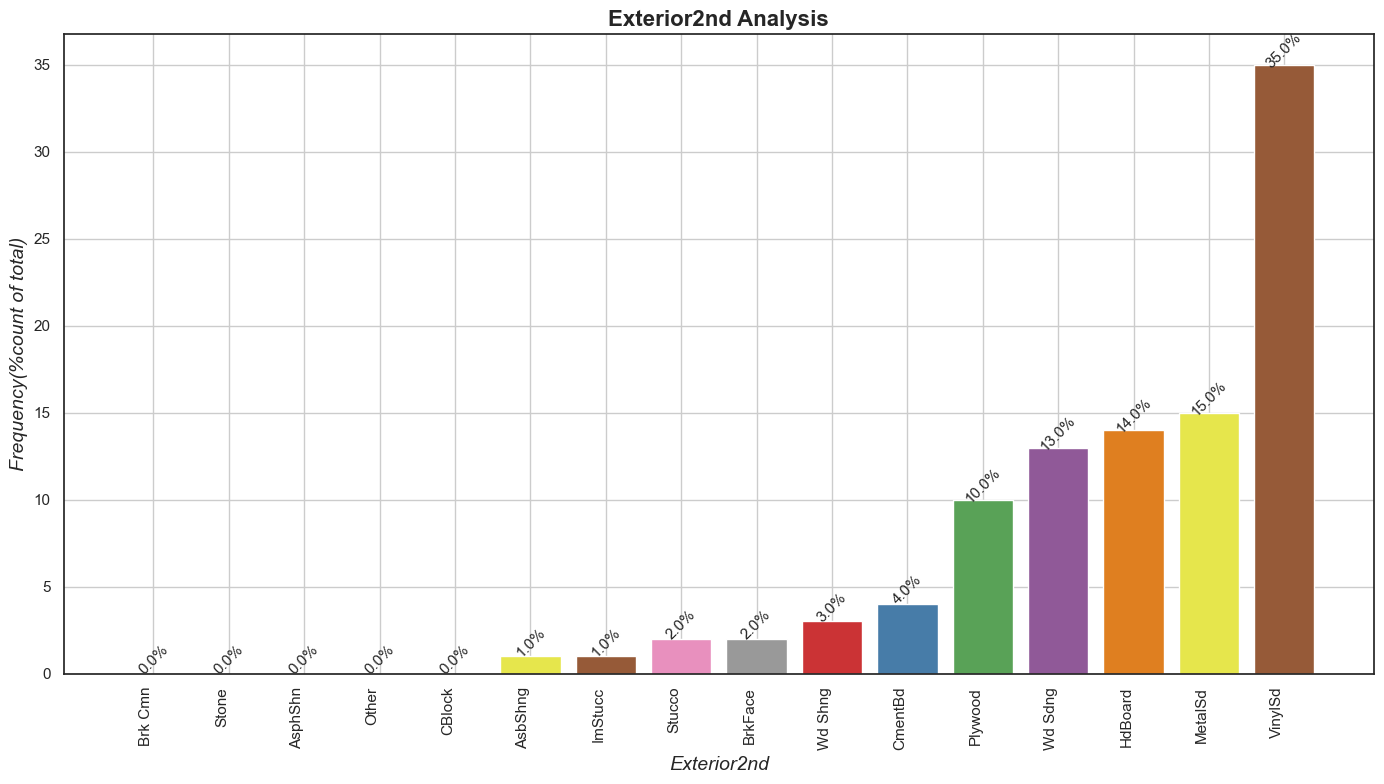

The highest % in  Exterior2nd category is  [35.0]


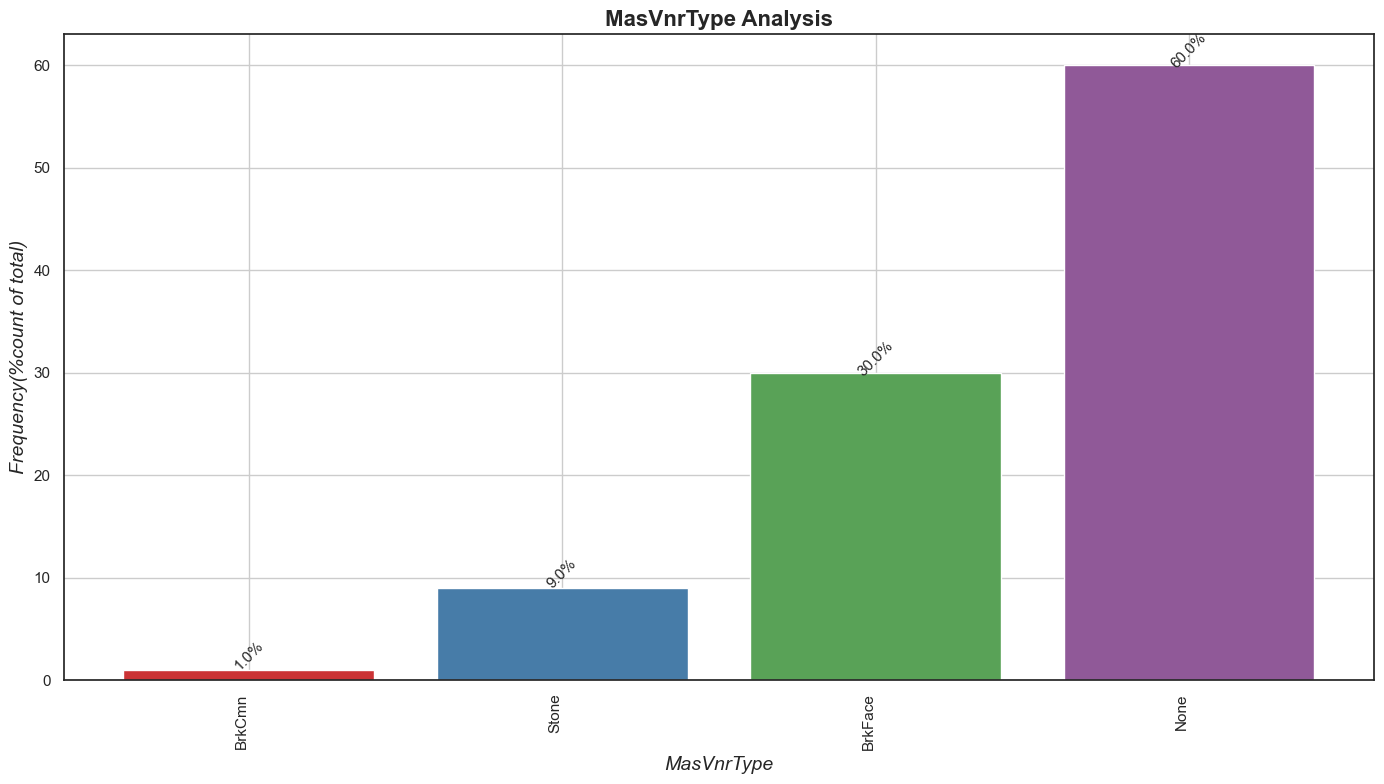

The highest % in  MasVnrType category is  [60.0]


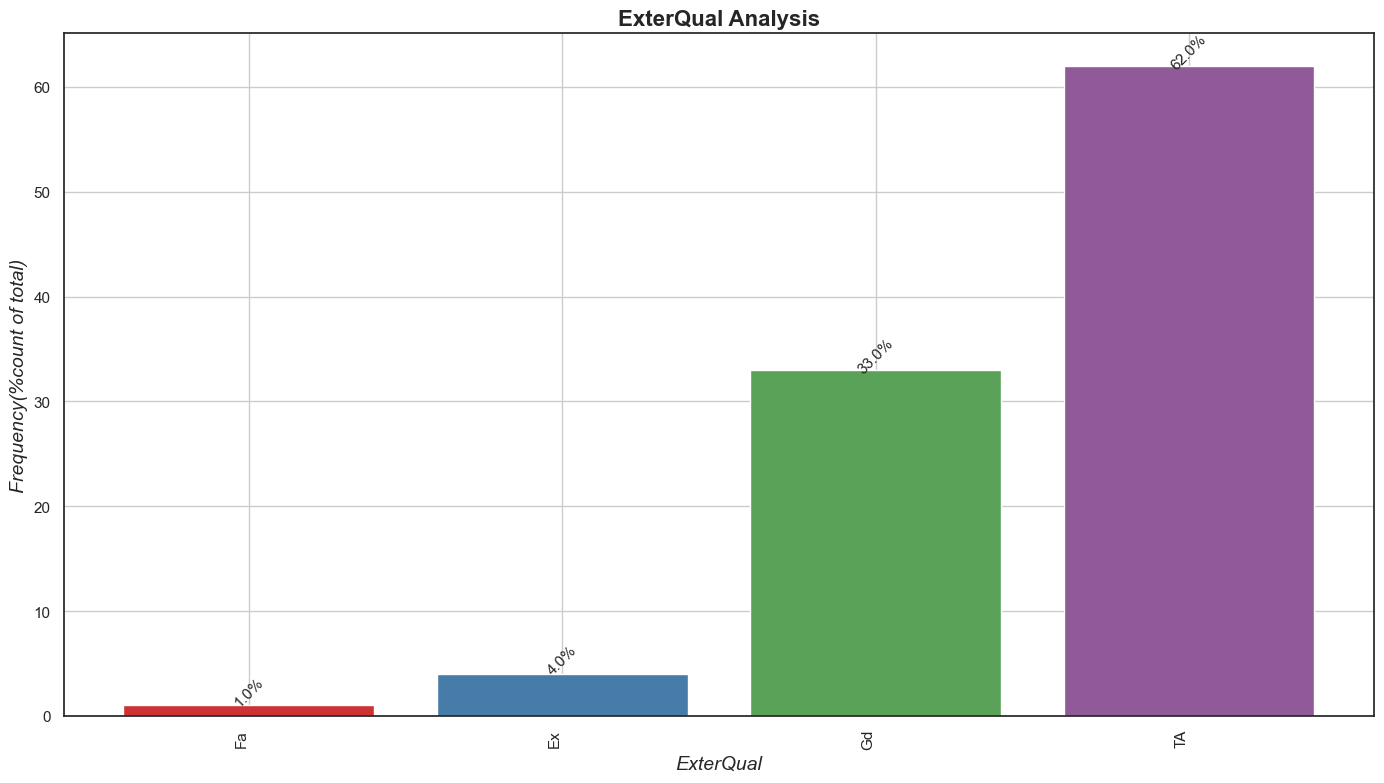

The highest % in  ExterQual category is  [62.0]


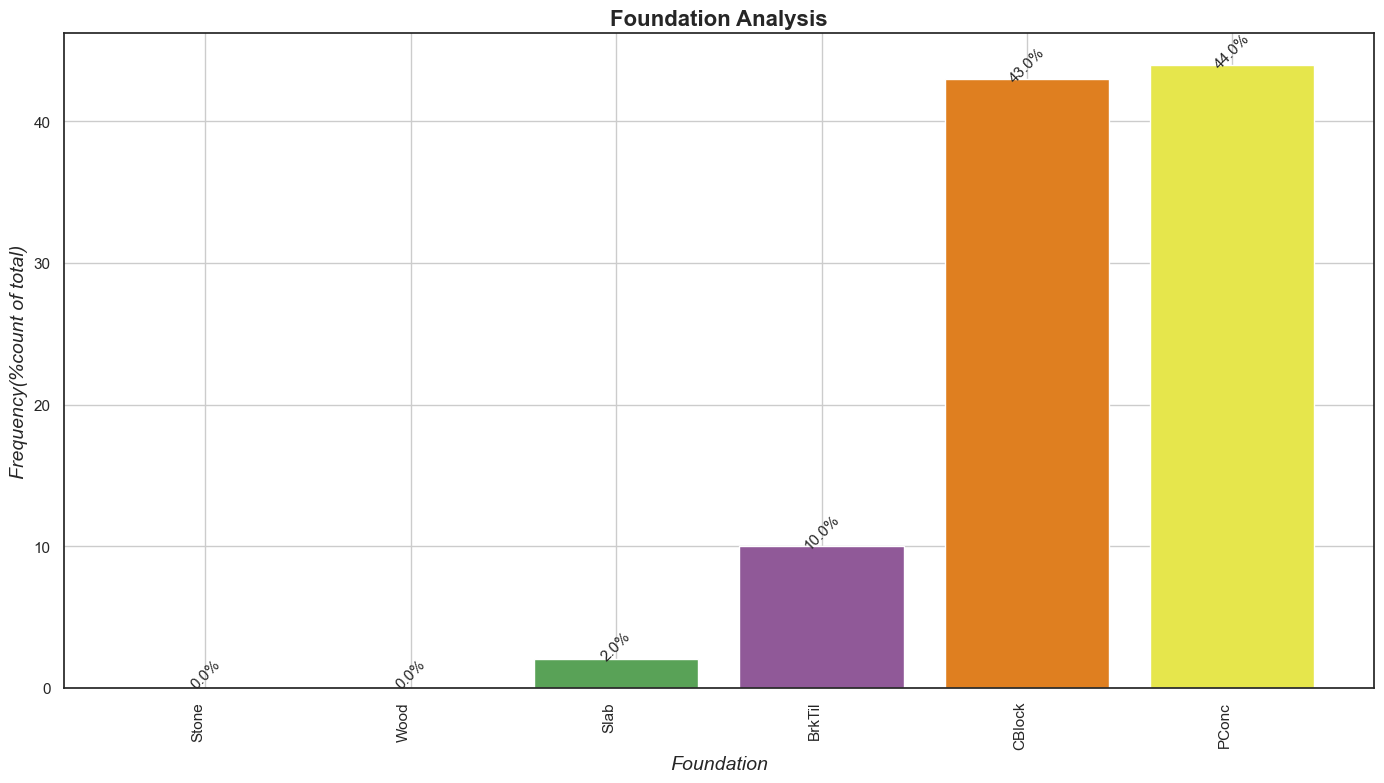

The highest % in  Foundation category is  [44.0]


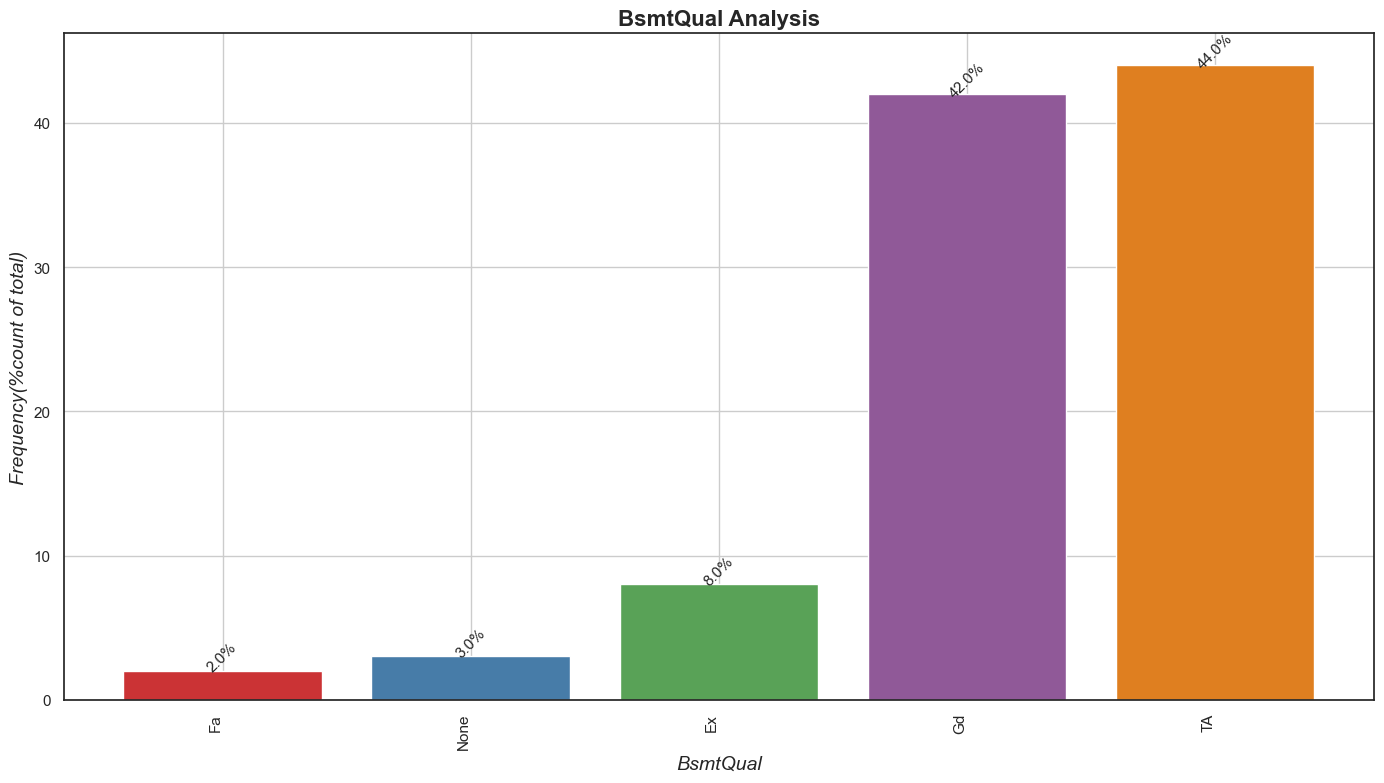

The highest % in  BsmtQual category is  [44.0]


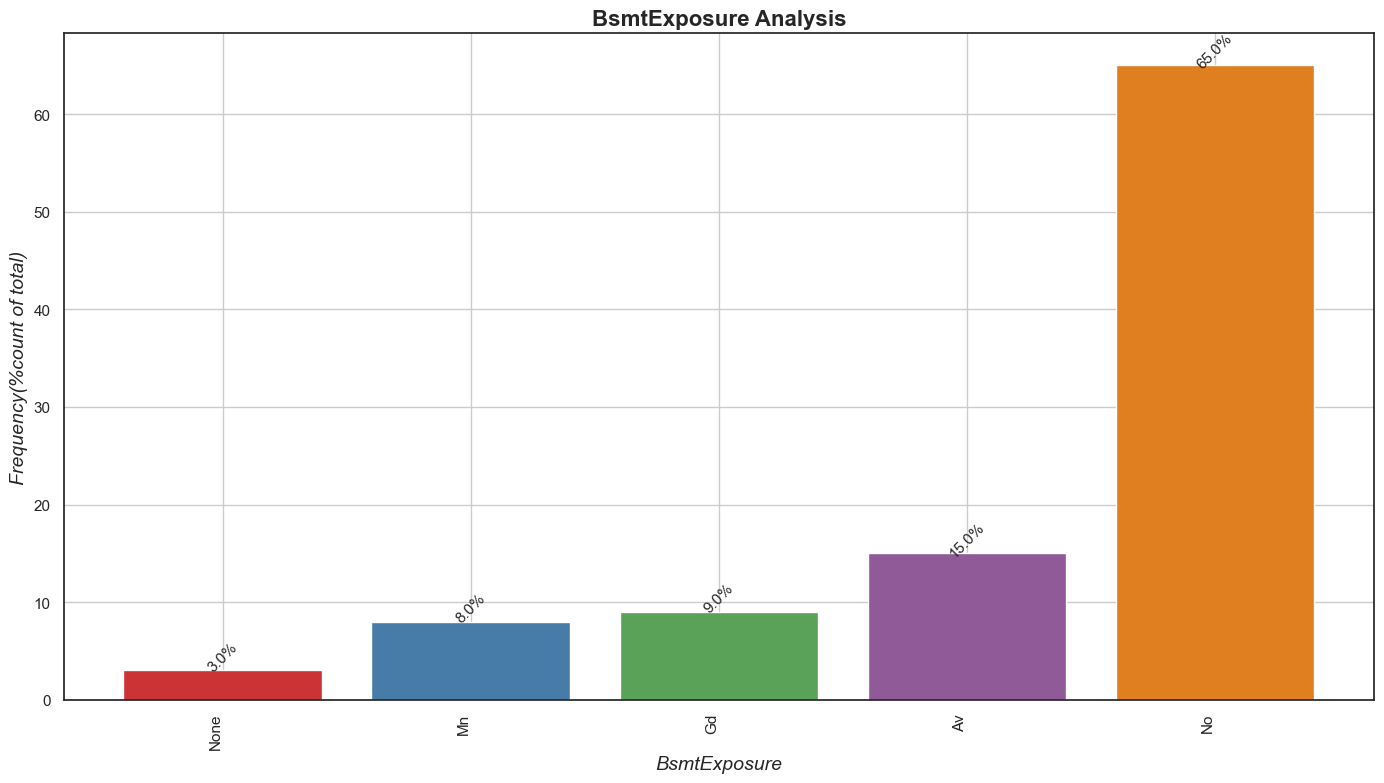

The highest % in  BsmtExposure category is  [65.0]


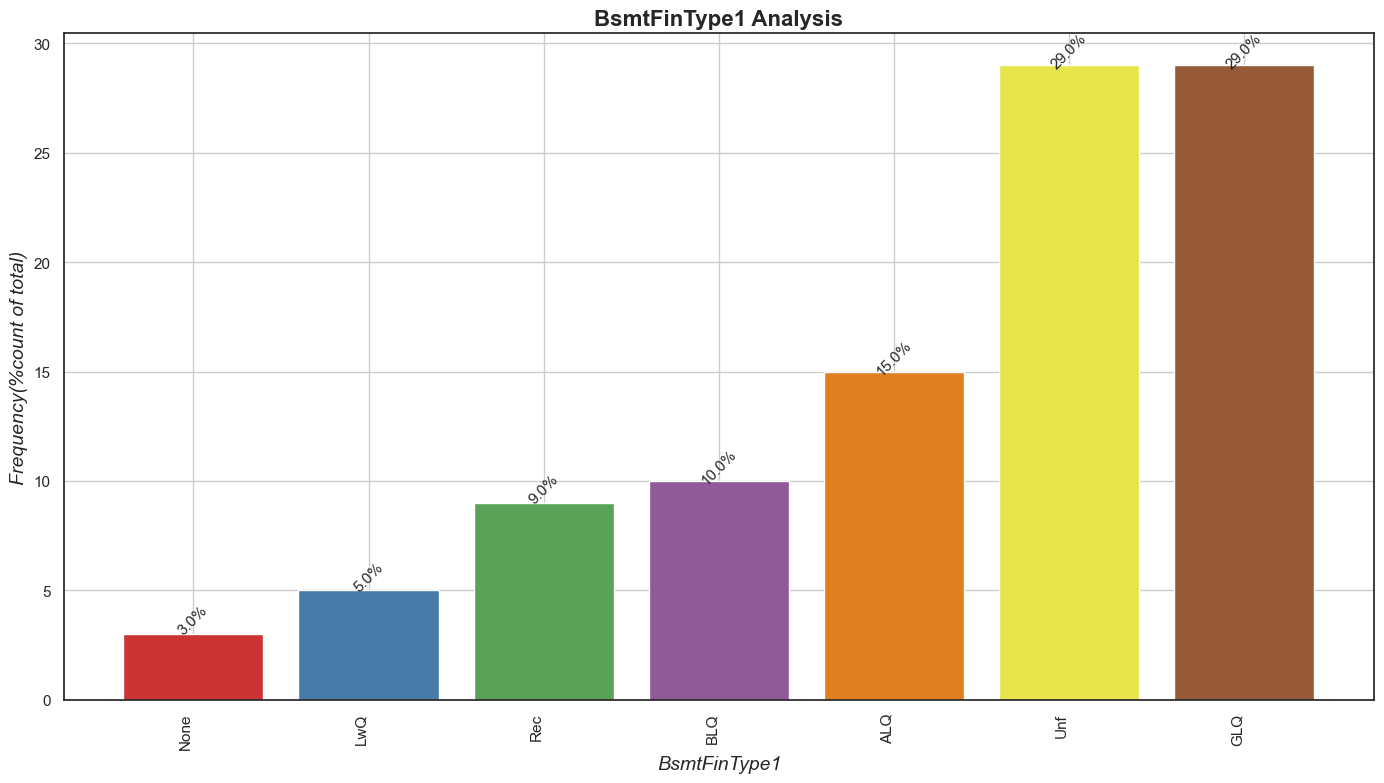

The highest % in  BsmtFinType1 category is  [29.0]


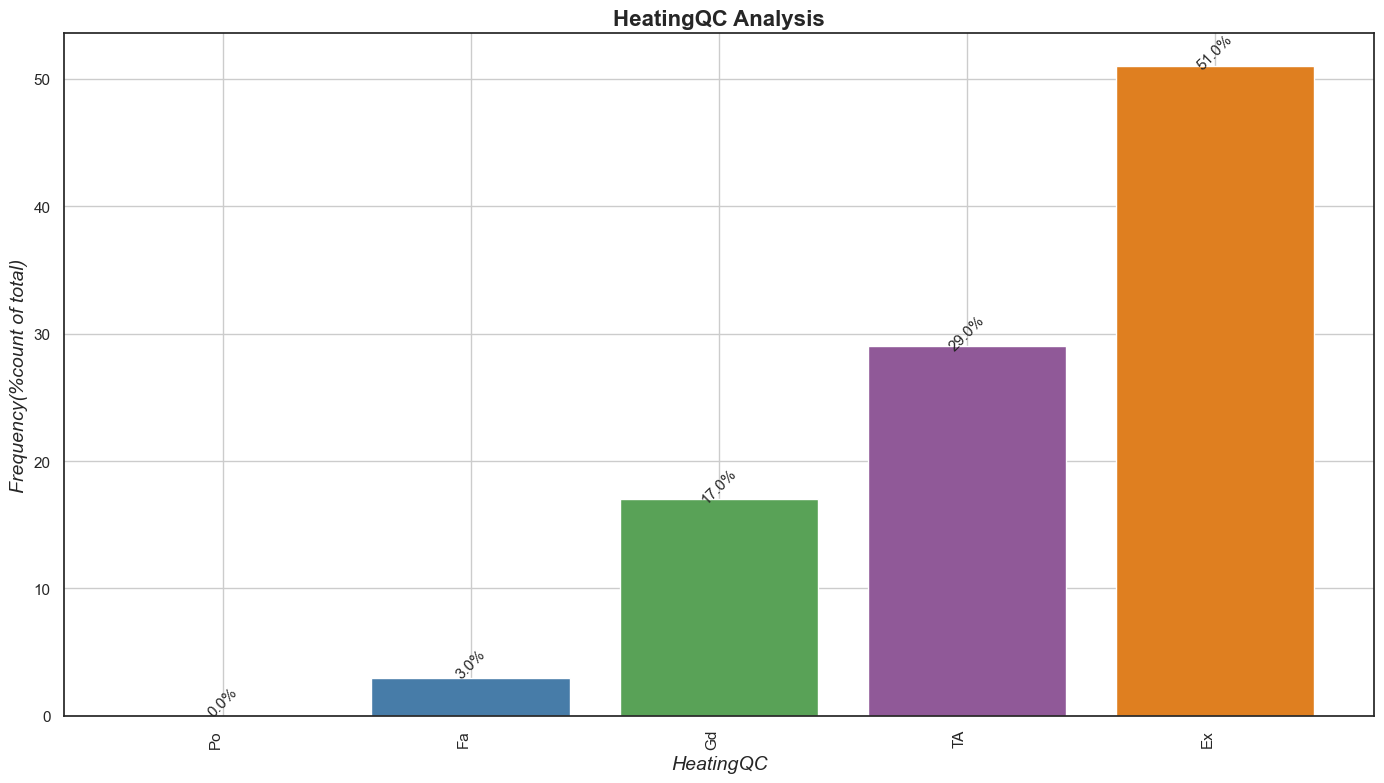

The highest % in  HeatingQC category is  [51.0]


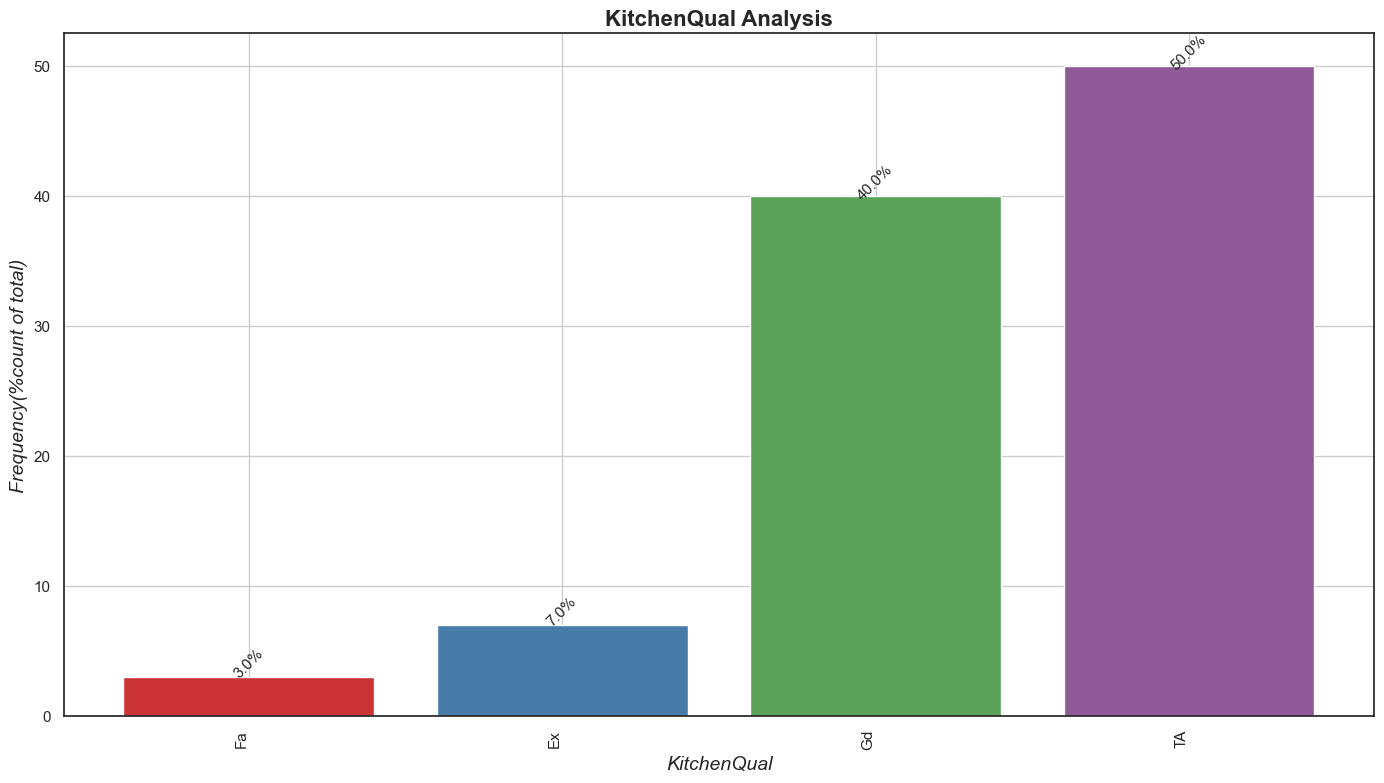

The highest % in  KitchenQual category is  [50.0]


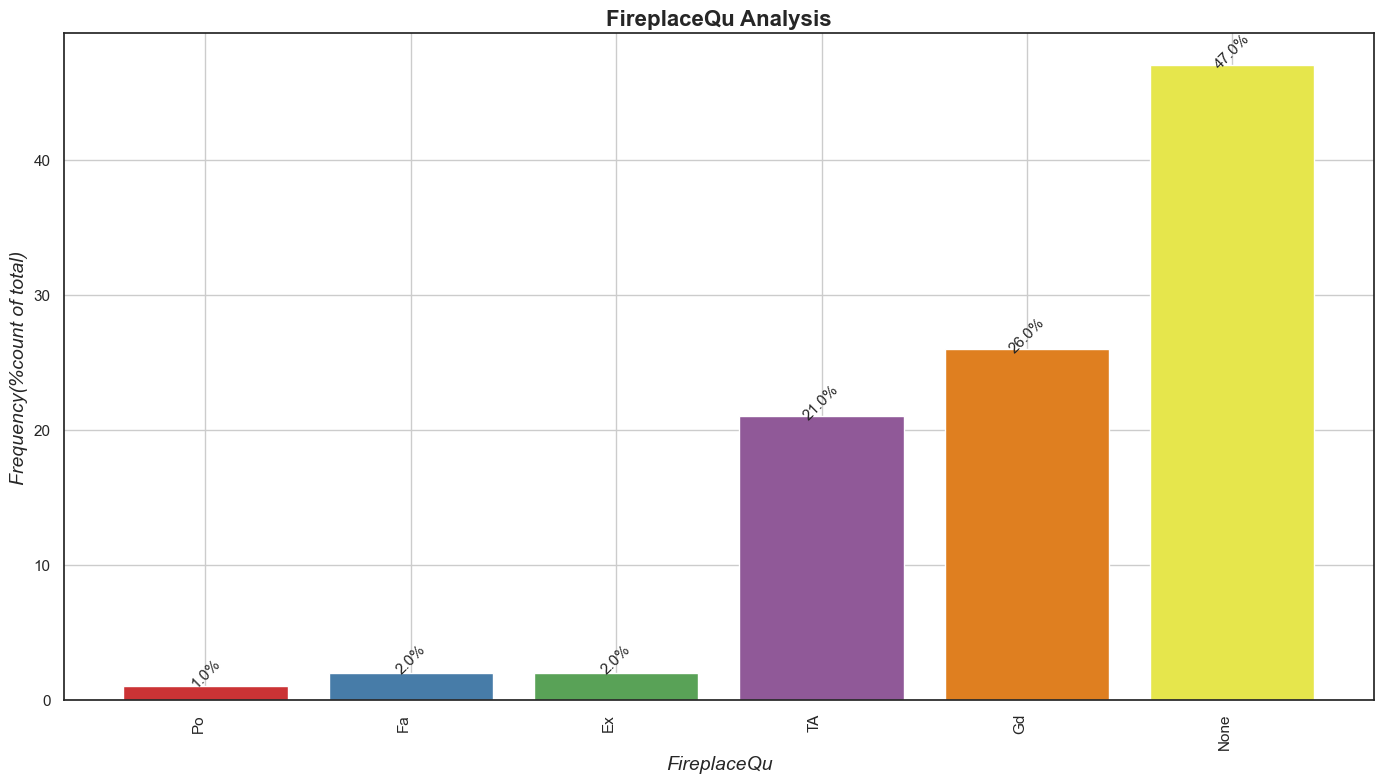

The highest % in  FireplaceQu category is  [47.0]


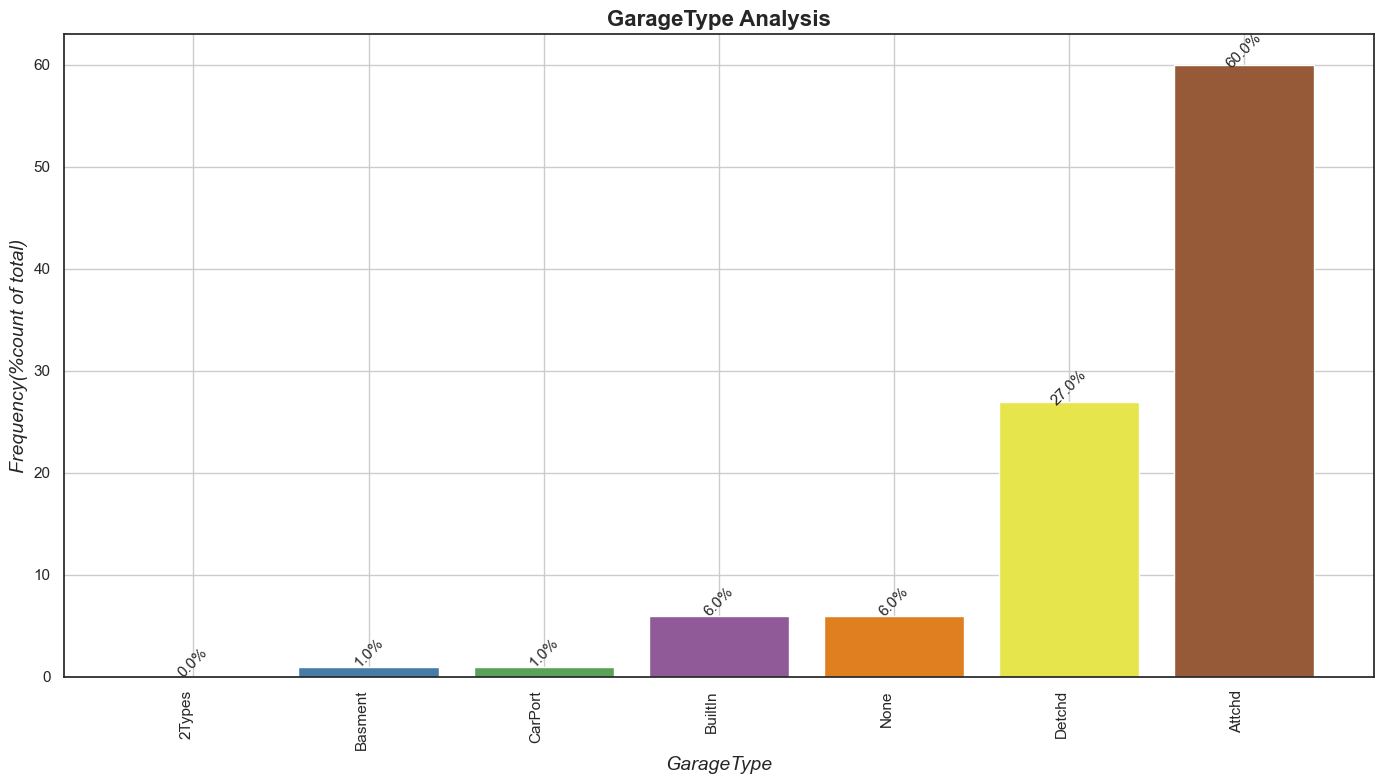

The highest % in  GarageType category is  [60.0]


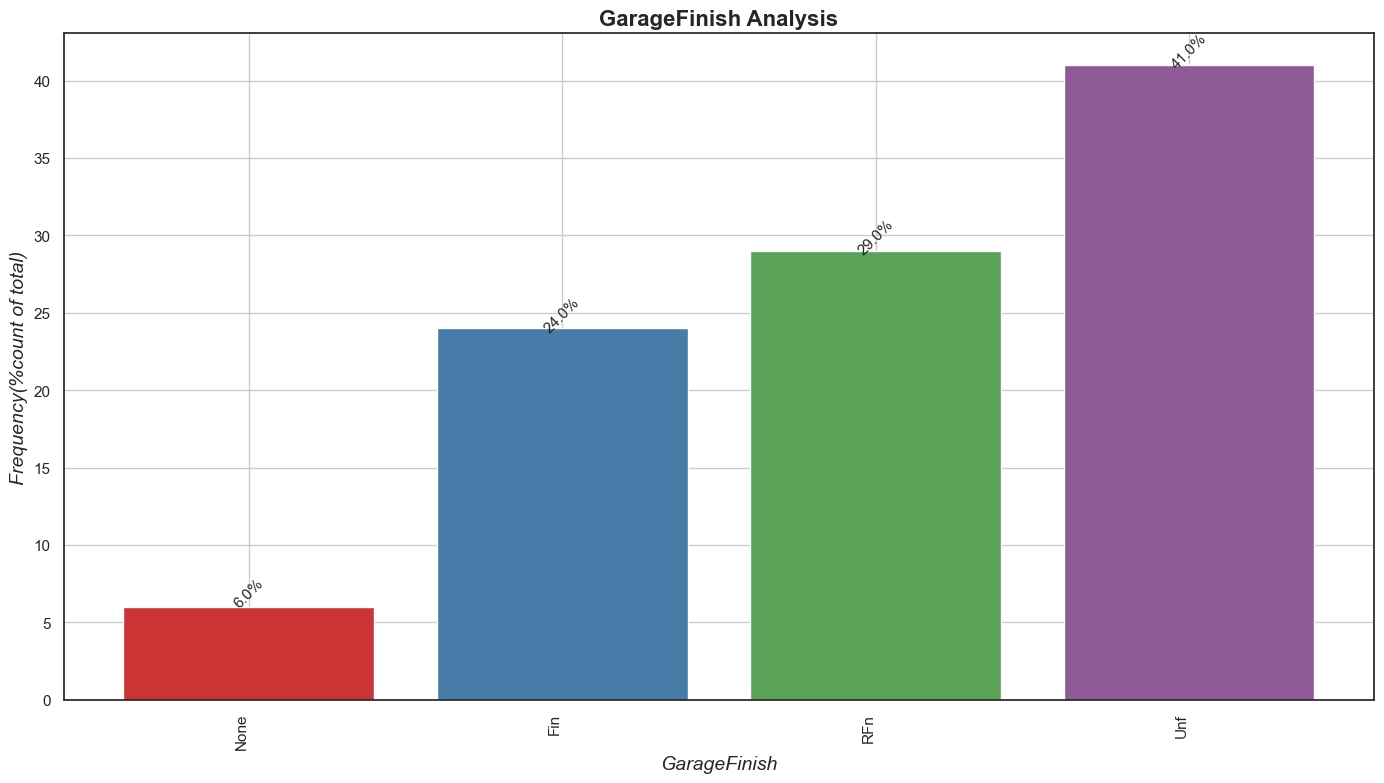

The highest % in  GarageFinish category is  [41.0]


In [31]:
 for i in range(0,len(df_obj_cat.columns),1):
    sns.set(style='white')
    plt.figure(figsize=(14, 8), dpi=100)
    plot_bar_categorial_percentage(df,df_obj_cat.columns[i])
    show_plot(plt)
    ab = pd.DataFrame((df[df_obj_cat.columns[i]].value_counts(normalize=True)*100).round(0).sort_values())
    text = ab.values.tolist()[-1]
    print('The highest % in  '+ df_obj_cat.columns[i] +' category is  ' + str(text))

**Observations:**<br>

The highest % in  `MSZoning` category is `RL(Residential Low Density)` [79.0]<br>
The highest % in  `LotShape` category is `Reg(Regular)` [63.0]<br>
The highest % in  `LotConfig` category is `Inside`(Inside lot) [72.0]<br>
The highest % in  `Neighborhood` category is `NorthAmericas` [15.0]<br>
The highest % in  `HouseStyle` category is `one story` [50.0]<br>
The highest % in  `RoofStyle` category is `Gable` [78.0]<br>
The highest % in  `Exterior1st` category is `VinylSd` [35.0]<br>
The highest % in  `Exterior2nd` category is `VinylSd` [35.0]<br>
The highest % in  `MasVnrType` category is `None` [60.0]<br>
The highest % in  `ExterQual` category is `TA` [62.0]<br>
The highest % in  `Foundation` category is `PConc` [44.0]<br>
The highest % in  `Basement Quality` category is `TA` [44.0]<br>
The highest % in  `Basement Exposure` category is `No` [65.0]<br>
The highest % in  `BsmtFinType1` category is `GLQ` [29.0]<br>
The highest % in  `HeatingQC` category is `Ex` [51.0]<br>
The highest % in  `KitchenQuality` category is `TA` [50.0]<br>
The highest % in  `FireplaceQu` category is `None` [47.0]<br>
The highest % in  `GarageType` category is `Attached` [60.0]<br>
The highest % in  `GarageFinish` category is `Unf` [41.0]<br>

No significant preference for  following features:<br>
--(i) FireplaceQu (Quality), MasVnrType: `'None'`<br>
--(ii) KitchenQual (Quality), ExterQual (Quality of exterior material), BsmtQual (Height of basement):`'TA'(Typical/Average)`<br>

**Dealing with data imbalance (all numeric data):**

In [32]:
##checking  null values in the numeric columns.

numeric_null_cols = df.select_dtypes(include=['int64','float64','int32','float32'])   #Retaining only int and float data types for numeric columns
missing_numeric_null_prcnt = round(100*numeric_null_cols.isnull().sum()/len(numeric_null_cols.index),2)
missing_numeric_null_prcnt = missing_numeric_null_prcnt[missing_numeric_null_prcnt!=0]
missing_numeric_null_prcnt

LotFrontage    17.74
MasVnrArea      0.55
GarageYrBlt     5.55
dtype: float64

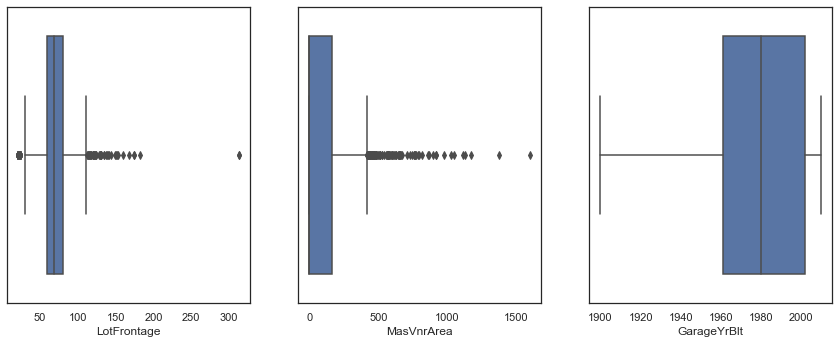

In [33]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x=df["LotFrontage"])

plt.subplot(2,4,2)
sns.boxplot(x=df["MasVnrArea"])

plt.subplot(2,4,3)
sns.boxplot(x=df["GarageYrBlt"])


plt.show()

In [34]:
print("LotFrontage:\n",df.LotFrontage.describe(percentiles=[0.1, .25, .50, .75, .85, .90, .95, .98, .99, 1]))
print("\nMasVnrArea:\n",df.MasVnrArea.describe(percentiles=[0.1, .25, .50, .75, .85, .90, .95, .98, .99, 1]))

LotFrontage:
 count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
10%        44.000000
25%        59.000000
50%        69.000000
75%        80.000000
85%        90.000000
90%        96.000000
95%       107.000000
98%       124.000000
99%       141.000000
100%      313.000000
max       313.000000
Name: LotFrontage, dtype: float64

MasVnrArea:
 count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
85%       262.350000
90%       335.000000
95%       456.000000
98%       650.980000
99%       791.920000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


In [35]:
##For 'MasVnrArea', finding the median by removing all the values at 0.0 percentile to get a more precise value.
updated_MasVnrArea = df.MasVnrArea[~(df.MasVnrArea==0)]
print("\nMasVnrArea\n",updated_MasVnrArea.describe(percentiles=[0.1, .25, .50, .75, .85, .90, .95, .98, .99, 1]))


MasVnrArea
 count     591.000000
mean      254.739425
std       205.144174
min         1.000000
10%        70.000000
25%       113.000000
50%       203.000000
75%       330.500000
85%       424.500000
90%       481.000000
95%       650.500000
98%       862.000000
99%      1032.600000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


Since, there are outliers in 'LotFrontage' and 'MasVnrArea'.<br>
(i) Impute the 'LotFrontage' with median, as the mean (70.04) and median(69) are quite close to each other. <br>
(ii) For 'MasVnrArea', a lot of values are 0.0. So considering the stats excluding 0.0. Impute the nulls with median(203) as there as some outliers.

In [36]:
##lets replace  the null values with median values for 'LotFrontage' and 'MasVnrArea' columns

df['LotFrontage'] = df['LotFrontage'].replace(np.nan, df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].replace(np.nan, updated_MasVnrArea.median())

In [37]:
##filling the null values with 0 for 'GarageYrBlt' for now as we would be handling this column further below

df['GarageYrBlt']= df['GarageYrBlt'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int) 

In [38]:
##recheck null values in the numeric columns.

numeric_null_cols = df.select_dtypes(include=['int64','float64','int32','float32'])   #Retaining only int and float data types for numeric columns
missing_numeric_null_prcnt = round(100*numeric_null_cols.isnull().sum()/len(numeric_null_cols.index),2)
missing_numeric_null_prcnt = missing_numeric_null_prcnt[missing_numeric_null_prcnt!=0]
missing_numeric_null_prcnt

Series([], dtype: float64)

No null values are present in the numeric columns of the dataset, df.

**Derived features:**

In [39]:
##create a new column named 'WhetherRemodelled': This column would determine whether the house has been remodelled or not based on 'YearBuilt' and 'YearRemodAdd' 

def Remodel_Check(row):     ##Based on the difference between remodelled and built years
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0     #Indicate not Remodelled
    elif (row['YearBuilt'] < row['YearRemodAdd']):
        return 1     #Indicated Remodelled
    
df['WhetherRemodelled'] = df.apply(Remodel_Check, axis=1)
df.head()    

Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0      CollgCr     2Story            7            5       2003          2003   
1      Veenker     1Story            6            8       1976          1976   
2      CollgCr     2Story            7            5       2001          2002   
3      Crawfor     2Story            7            5       1915          1970   
4      NoRidge     2Story            8            5       2000          2000   

  RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable     VinylSd     VinylSd    BrkFace       196.0        Gd   
1     Gable     MetalSd     MetalSd       None         0.0        TA   
2     Gable     VinylSd     VinylSd    BrkFace       162.0        Gd   
3     Gable     Wd Sdng     Wd Shng       None         0.0        TA   
4     Gable     VinylSd     VinylSd    BrkFace       350.0        Gd   

  Foundation BsmtQual BsmtExposure BsmtFinType1  BsmtFinSF1  BsmtFinSF2  \
0      PConc       Gd           No          GLQ         706           0   
1     CBlock       Gd           Gd          ALQ         978           0   
2      PConc       Gd           Mn          GLQ         486           0   
3     BrkTil       TA           No          ALQ         216           0   
4      PConc       Gd           Av          GLQ         655           0   

   BsmtUnfSF  TotalBsmtSF HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        150          856        Ex       856       854             0   
1        284         1262        Ex      1262         0             0   
2        434          920        Ex       920       866             0   
3        540          756        Gd       961       756             0   
4        490         1145        Ex      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd  Fireplaces FireplaceQu GarageType  \
0             1          Gd             8           0        None     Attchd   
1             1          TA             6           1          TA     Attchd   
2             1          Gd             6           1          TA     Attchd   
3             1          Gd             7           1          Gd     Detchd   
4             1          Gd             9           1          TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0         2003          RFn           2         548           0           61   
1         1976          RFn           2         460         298            0   
2         2001          RFn           2         608           0           42   
3         1998          Unf           3         642           0           35   
4         2000          RFn           3         836         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272         

In [40]:
##derive a new variable named 'AgeofProperty' to determine the age of property since the built

def find_age_since_built(row):
        return row['YrSold'] - row['YearBuilt']
    
df['AgeofProperty'] = df.apply(find_age_since_built, axis=1)
df.head()  

Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0      CollgCr     2Story            7            5       2003          2003   
1      Veenker     1Story            6            8       1976          1976   
2      CollgCr     2Story            7            5       2001          2002   
3      Crawfor     2Story            7            5       1915          1970   
4      NoRidge     2Story            8            5       2000          2000   

  RoofStyle Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable     VinylSd     VinylSd    BrkFace       196.0        Gd   
1     Gable     MetalSd     MetalSd       None         0.0        TA   
2     Gable     VinylSd     VinylSd    BrkFace       162.0        Gd   
3     Gable     Wd Sdng     Wd Shng       None         0.0        TA   
4     Gable     VinylSd     VinylSd    BrkFace       350.0        Gd   

  Foundation BsmtQual BsmtExposure BsmtFinType1  BsmtFinSF1  BsmtFinSF2  \
0      PConc       Gd           No          GLQ         706           0   
1     CBlock       Gd           Gd          ALQ         978           0   
2      PConc       Gd           Mn          GLQ         486           0   
3     BrkTil       TA           No          ALQ         216           0   
4      PConc       Gd           Av          GLQ         655           0   

   BsmtUnfSF  TotalBsmtSF HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        150          856        Ex       856       854             0   
1        284         1262        Ex      1262         0             0   
2        434          920        Ex       920       866             0   
3        540          756        Gd       961       756             0   
4        490         1145        Ex      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd  Fireplaces FireplaceQu GarageType  \
0             1          Gd             8           0        None     Attchd   
1             1          TA             6           1          TA     Attchd   
2             1          Gd             6           1          TA     Attchd   
3             1          Gd             7           1          Gd     Detchd   
4             1          Gd             9           1          TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0         2003          RFn           2         548           0           61   
1         1976          RFn           2         460         298            0   
2         2001          RFn           2         608           0           42   
3         1998          Unf           3         642           0           35   
4         2000          RFn           3         836         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272         

In [41]:
# drop those columns where we already derived the values

df = df.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1)
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st  \
0      CollgCr     2Story            7            5     Gable     VinylSd   
1      Veenker     1Story            6            8     Gable     MetalSd   
2      CollgCr     2Story            7            5     Gable     VinylSd   
3      Crawfor     2Story            7            5     Gable     Wd Sdng   
4      NoRidge     2Story            8            5     Gable     VinylSd   

  Exterior2nd MasVnrType  MasVnrArea ExterQual Foundation BsmtQual  \
0     VinylSd    BrkFace       196.0        Gd      PConc       Gd   
1     MetalSd       None         0.0        TA     CBlock       Gd   
2     VinylSd    BrkFace       162.0        Gd      PConc       Gd   
3     Wd Shng       None         0.0        TA     BrkTil       TA   
4     VinylSd    BrkFace       350.0        Gd      PConc       Gd   

  BsmtExposure BsmtFinType1  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0           No          GLQ         706           0        150          856   
1           Gd          ALQ         978           0        284         1262   
2           Mn          GLQ         486           0        434          920   
3           No          ALQ         216           0        540          756   
4           Av          GLQ         655           0        490         1145   

  HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0        Ex       856       854             0       1710             1   
1        Ex      1262         0             0       1262             0   
2        Ex       920       866             0       1786             1   
3        Gd       961       756             0       1717             1   
4        Ex      1145      1053             0       2198             1   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
0             0         2         1             3             1          Gd   
1             1         2         0             3             1          TA   
2             0         2         1             3             1          Gd   
3             0         1         0             3             1          Gd   
4             0         2         1             4             1          Gd   

   TotRmsAbvGrd  Fireplaces FireplaceQu GarageType GarageFinish  GarageCars  \
0             8           0        None     Attchd          RFn           2   
1             6           1          TA     Attchd          RFn           2   
2             6           1          TA     Attchd          RFn           2   
3             7           1          Gd     Detchd          Unf           3   
4             9           1          TA     Attchd          RFn           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   PoolArea  MiscVal  MoSold  SalePrice  WhetherRemodelled  AgeofProperty  
0         0        0       2     208500                  0              5  
1         0        0       5     181500                  0             31  
2         0        0       9     223500                  1              7  
3         0        0       2   

In [42]:
df.shape

(1460, 55)

**Dealing with data imbalance (numeric variables):** Removing numeric attributes that have more than `80%` data associated to one single value.

In [43]:
##removing numeric attributes that have more than 80% data associated to one single value.

num_cols_to_be_removed = get_num_cols_imbal(data=df, prcnt=80)  
print("Numeric columns removed:",num_cols_to_be_removed)
print("\nNumber of numeric columns removed: ", len(num_cols_to_be_removed),"\n")

df = df.drop(num_cols_to_be_removed, axis=1)
df.head()

Numeric columns removed: ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Number of numeric columns removed:  9 



Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1          60       RL         65.0     8450      Reg    Inside   
1   2          20       RL         80.0     9600      Reg       FR2   
2   3          60       RL         68.0    11250      IR1    Inside   
3   4          70       RL         60.0     9550      IR1    Corner   
4   5          60       RL         84.0    14260      IR1       FR2   

  Neighborhood HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st  \
0      CollgCr     2Story            7            5     Gable     VinylSd   
1      Veenker     1Story            6            8     Gable     MetalSd   
2      CollgCr     2Story            7            5     Gable     VinylSd   
3      Crawfor     2Story            7            5     Gable     Wd Sdng   
4      NoRidge     2Story            8            5     Gable     VinylSd   

  Exterior2nd MasVnrType  MasVnrArea ExterQual Foundation BsmtQual  \
0     VinylSd    BrkFace       196.0        Gd      PConc       Gd   
1     MetalSd       None         0.0        TA     CBlock       Gd   
2     VinylSd    BrkFace       162.0        Gd      PConc       Gd   
3     Wd Shng       None         0.0        TA     BrkTil       TA   
4     VinylSd    BrkFace       350.0        Gd      PConc       Gd   

  BsmtExposure BsmtFinType1  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF HeatingQC  \
0           No          GLQ         706        150          856        Ex   
1           Gd          ALQ         978        284         1262        Ex   
2           Mn          GLQ         486        434          920        Ex   
3           No          ALQ         216        540          756        Gd   
4           Av          GLQ         655        490         1145        Ex   

   1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  FullBath  HalfBath  \
0       856       854       1710             1         2         1   
1      1262         0       1262             0         2         0   
2       920       866       1786             1         2         1   
3       961       756       1717             1         1         0   
4      1145      1053       2198             1         2         1   

   BedroomAbvGr KitchenQual  TotRmsAbvGrd  Fireplaces FireplaceQu GarageType  \
0             3          Gd             8           0        None     Attchd   
1             3          TA             6           1          TA     Attchd   
2             3          Gd             6           1          TA     Attchd   
3             3          Gd             7           1          Gd     Detchd   
4             4          Gd             9           1          TA     Attchd   

  GarageFinish  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  MoSold  \
0          RFn           2         548           0           61       2   
1          RFn           2         460         298            0       5   
2          RFn           2         608           0           42       9   
3          Unf           3         642           0           35       2   
4          RFn           3         836         192           84      12   

   SalePrice  WhetherRemodelled  AgeofProperty  
0     208500                  0              5  
1     181500                  0             31  
2     223500                  1              7  
3     140000                  1             91  
4     250000                  0              8

In [44]:
##recheck for percentage of null values in the entire dataframe
missing_val_cols_prcnt = round(100*df.isnull().sum()/len(df.index),2)
missing = missing_val_cols_prcnt[missing_val_cols_prcnt!=0]
missing

Series([], dtype: float64)

In [45]:
df.shape

(1460, 46)

There are no null values present in the housing price prediction dataset, 'df'

**Analysis of Numeric Categorical Variables**

In [46]:
##numeric cateogorical variables
numeric_cat_cols = ['MSSubClass','MoSold','OverallQual','OverallCond','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr',\
                    'TotRmsAbvGrd','Fireplaces','GarageCars','WhetherRemodelled']

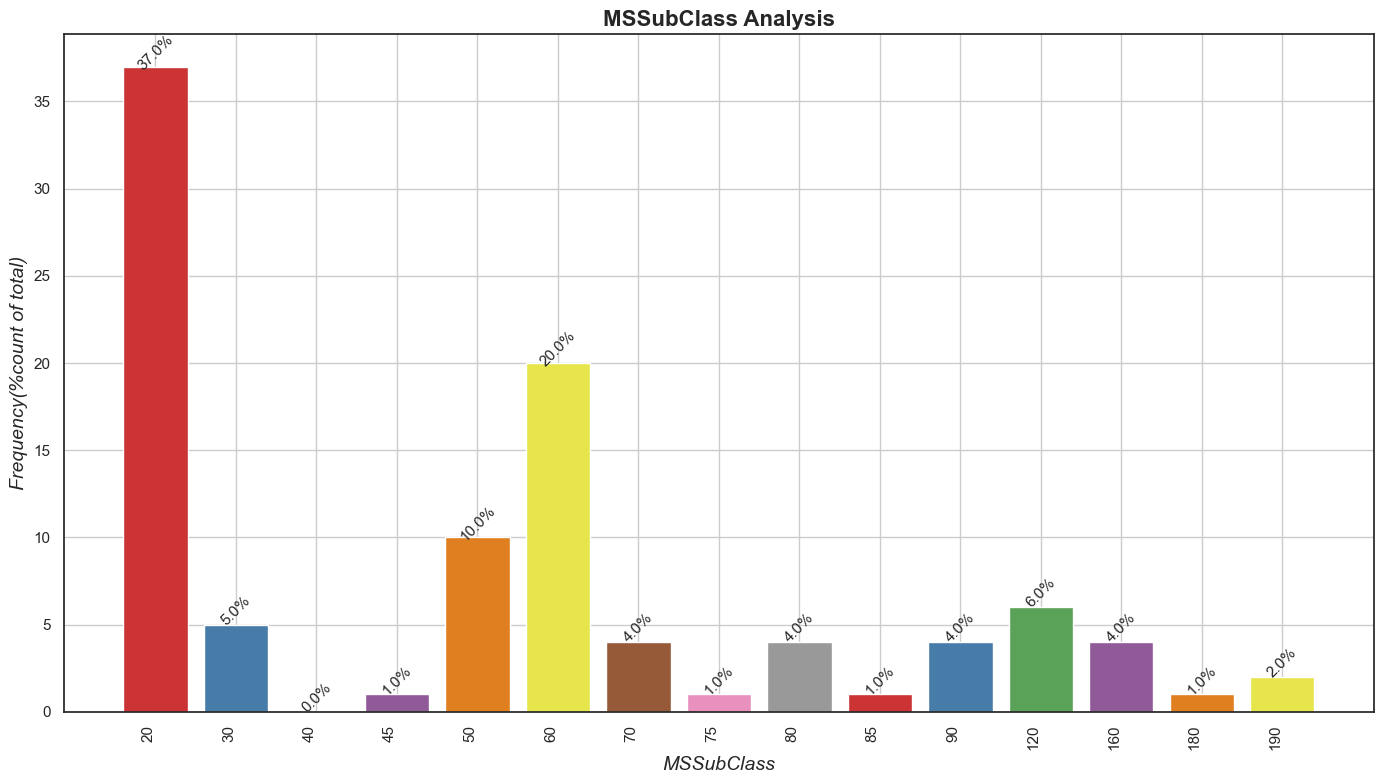

The highest % in  MSSubClass category is  [37.0]


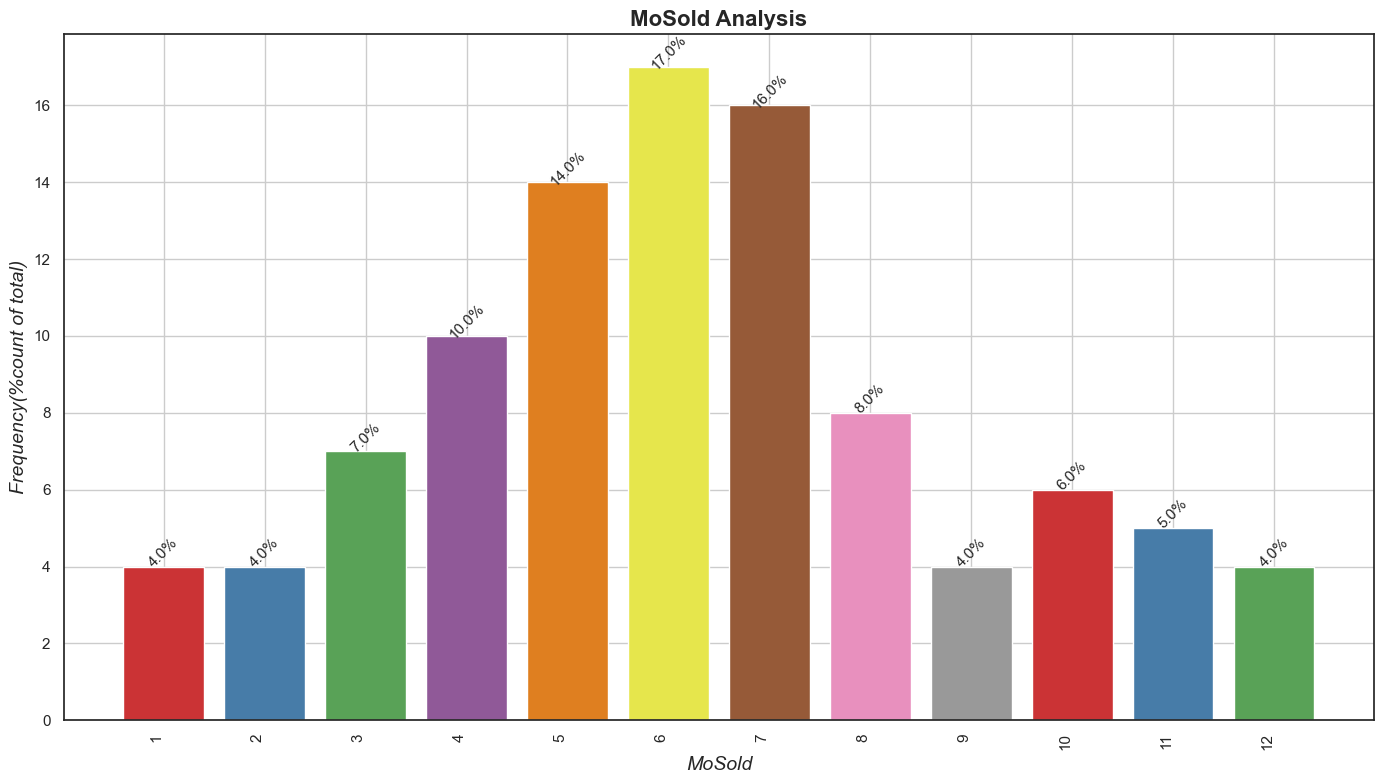

The highest % in  MoSold category is  [17.0]


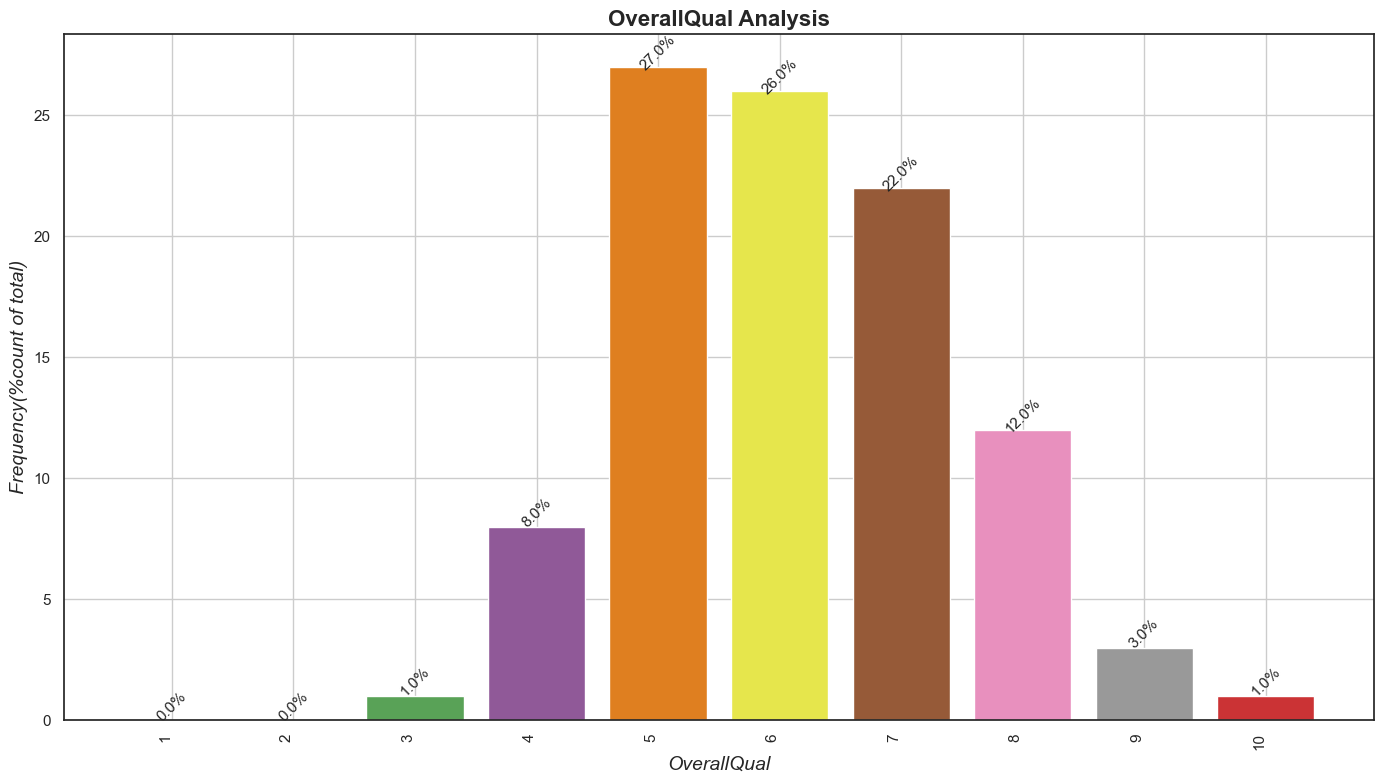

The highest % in  OverallQual category is  [27.0]


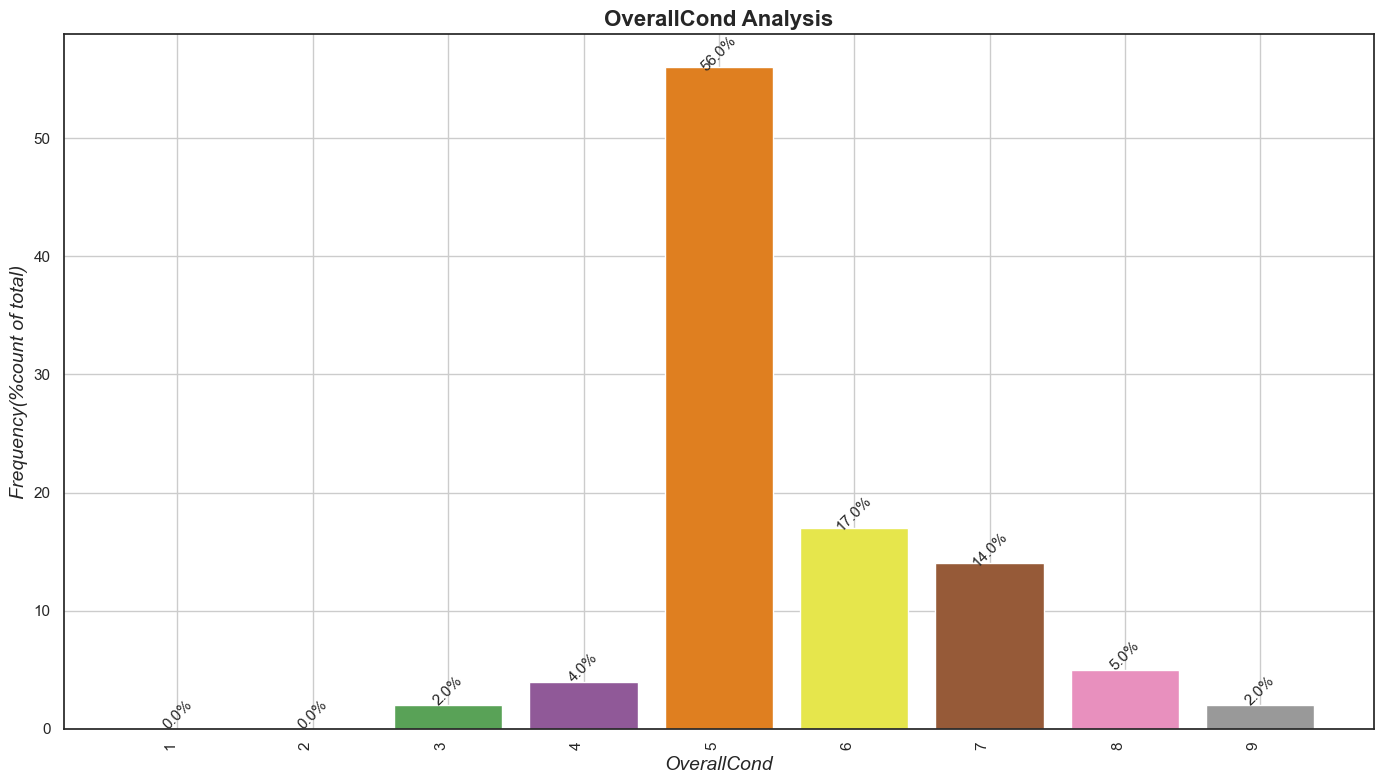

The highest % in  OverallCond category is  [56.0]


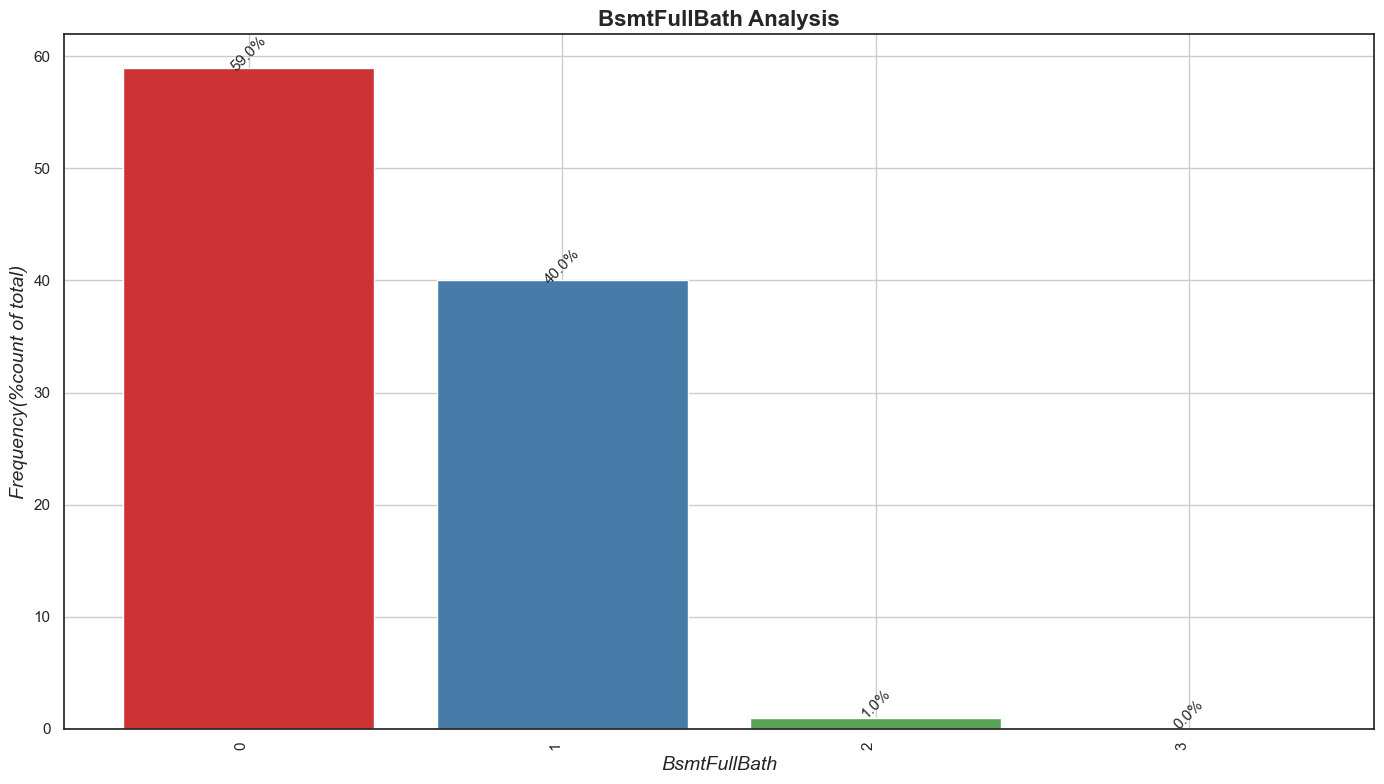

The highest % in  BsmtFullBath category is  [59.0]


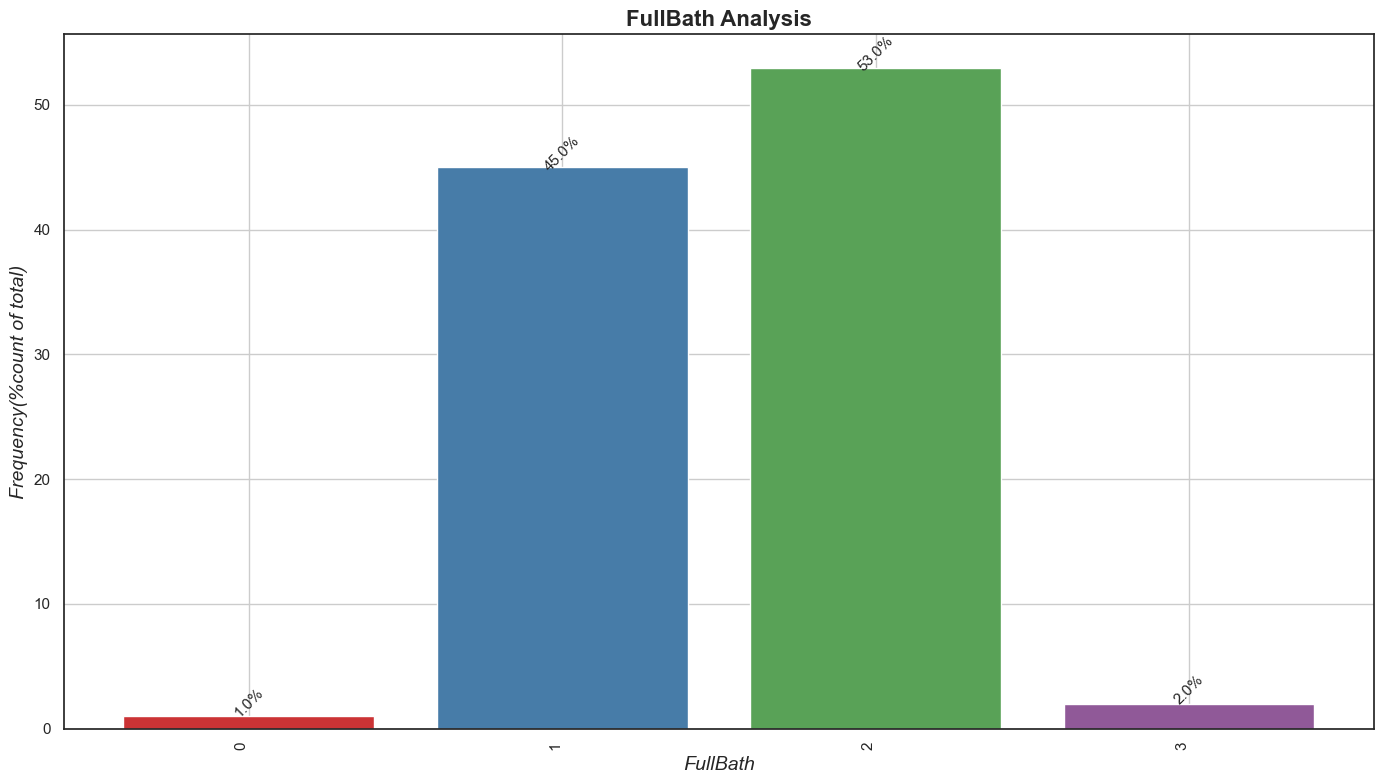

The highest % in  FullBath category is  [53.0]


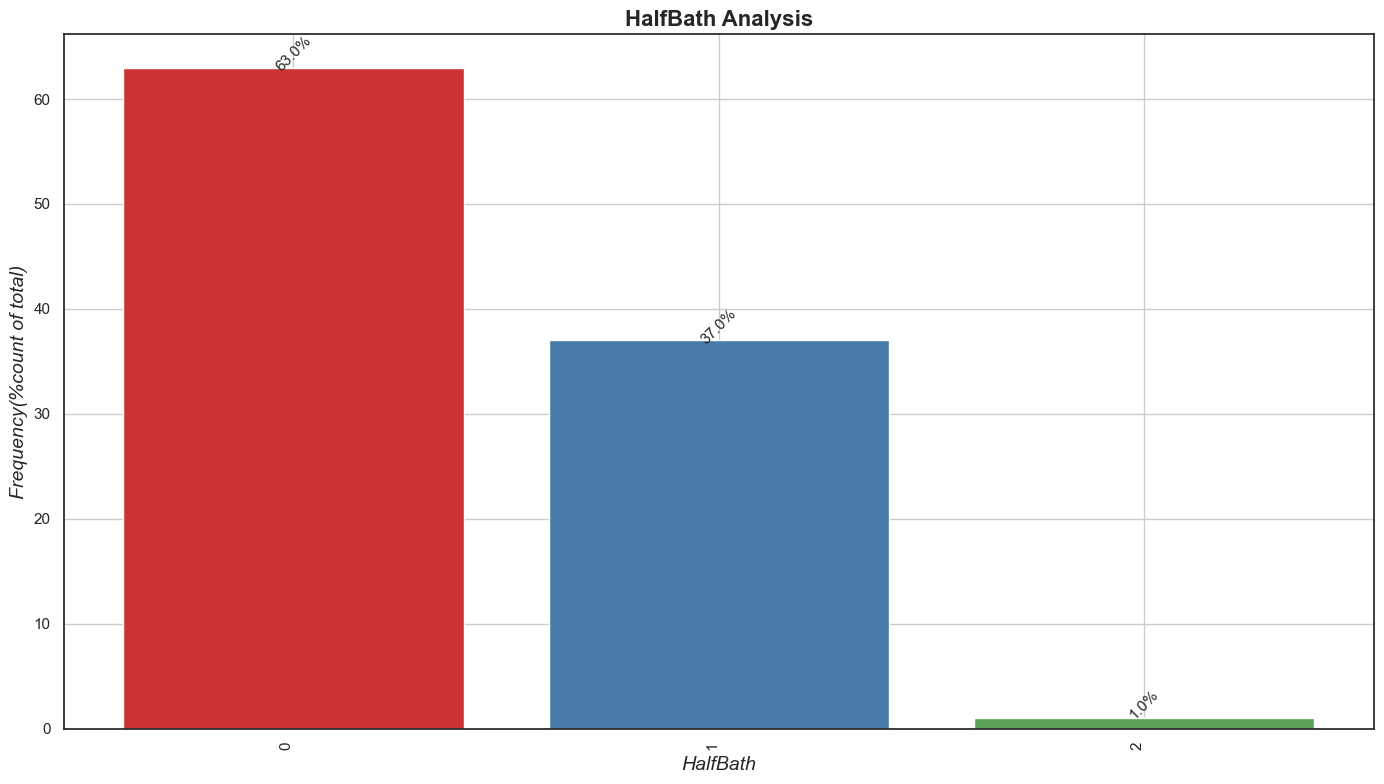

The highest % in  HalfBath category is  [63.0]


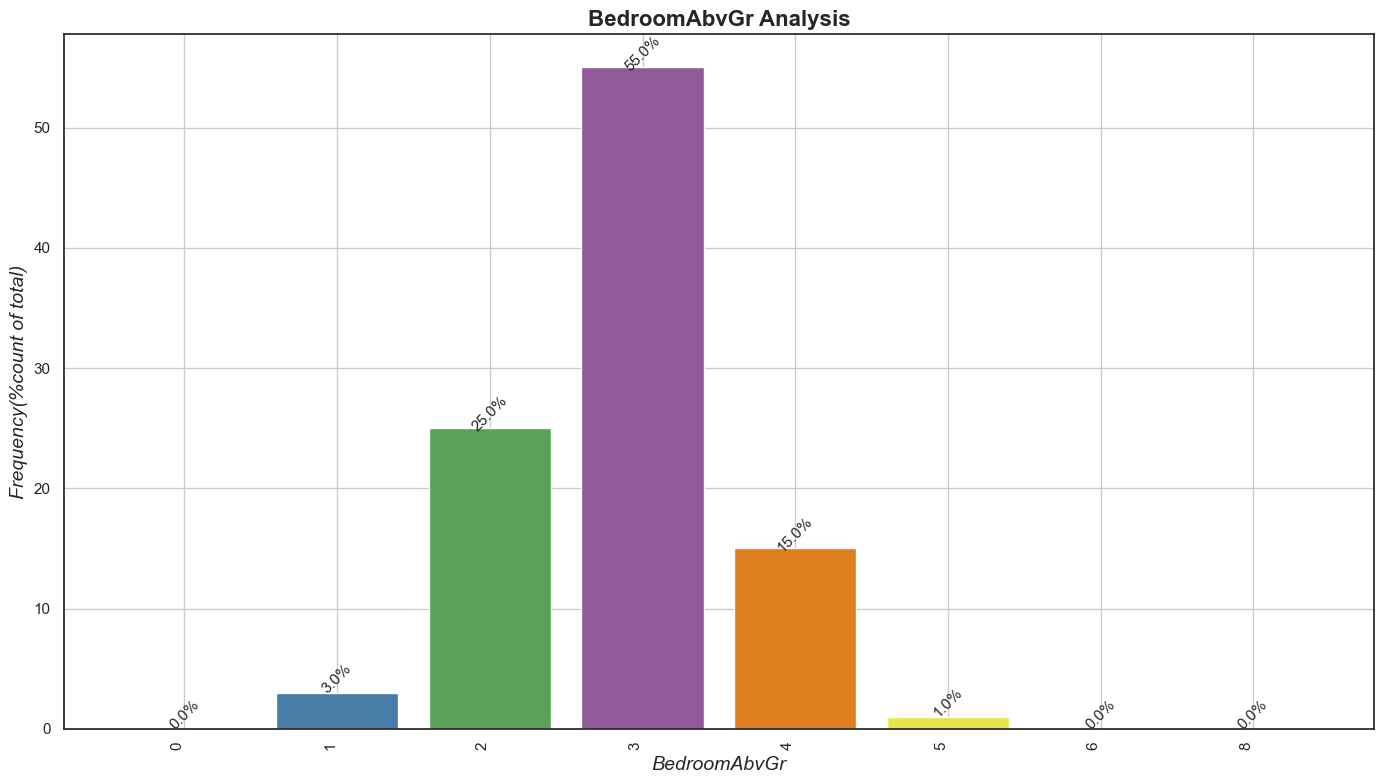

The highest % in  BedroomAbvGr category is  [55.0]


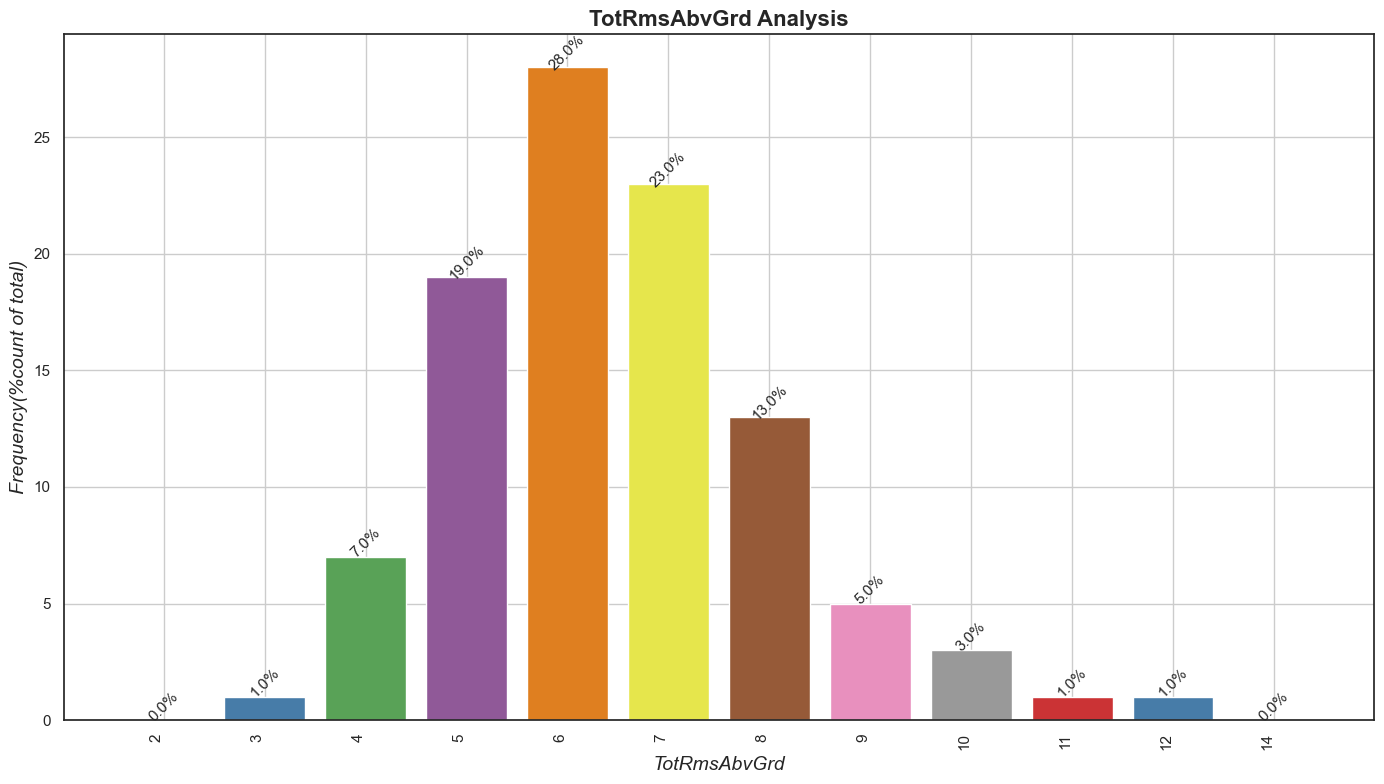

The highest % in  TotRmsAbvGrd category is  [28.0]


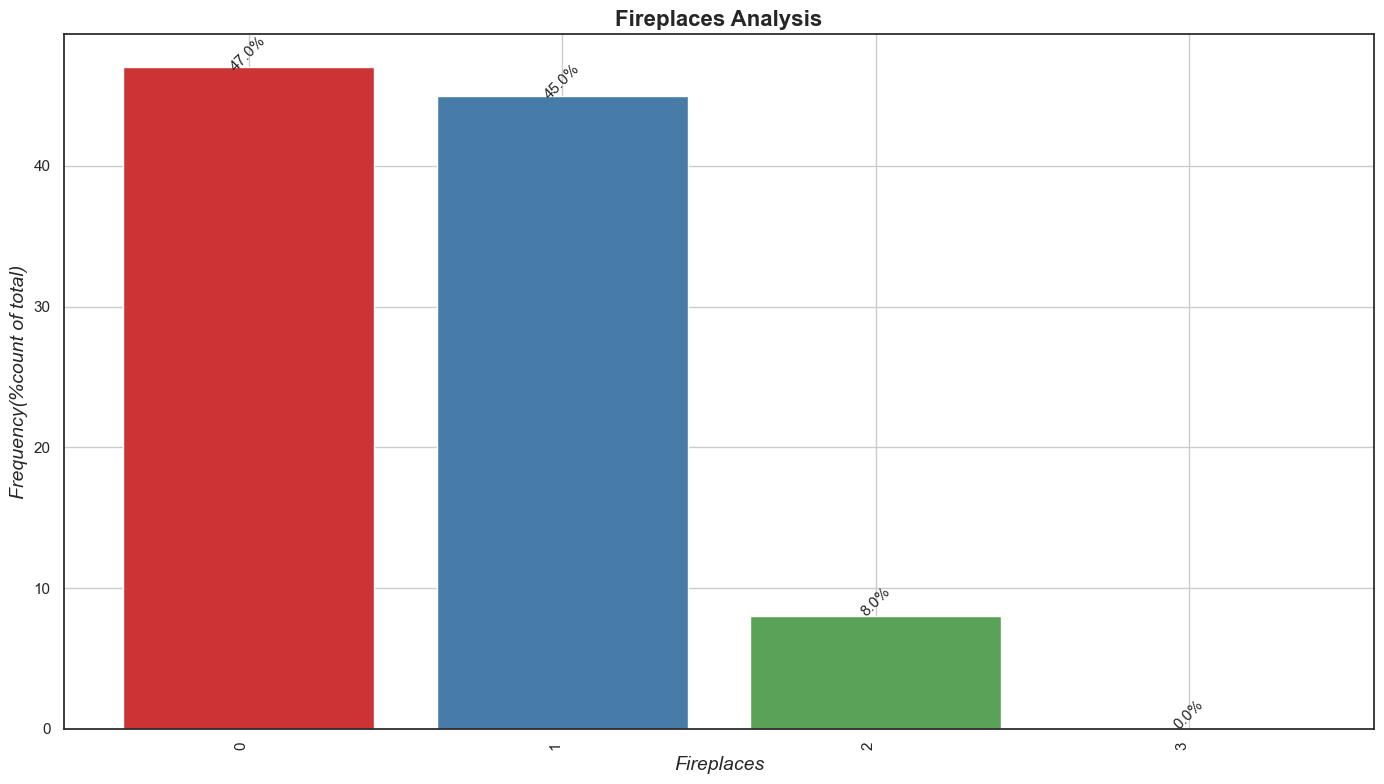

The highest % in  Fireplaces category is  [47.0]


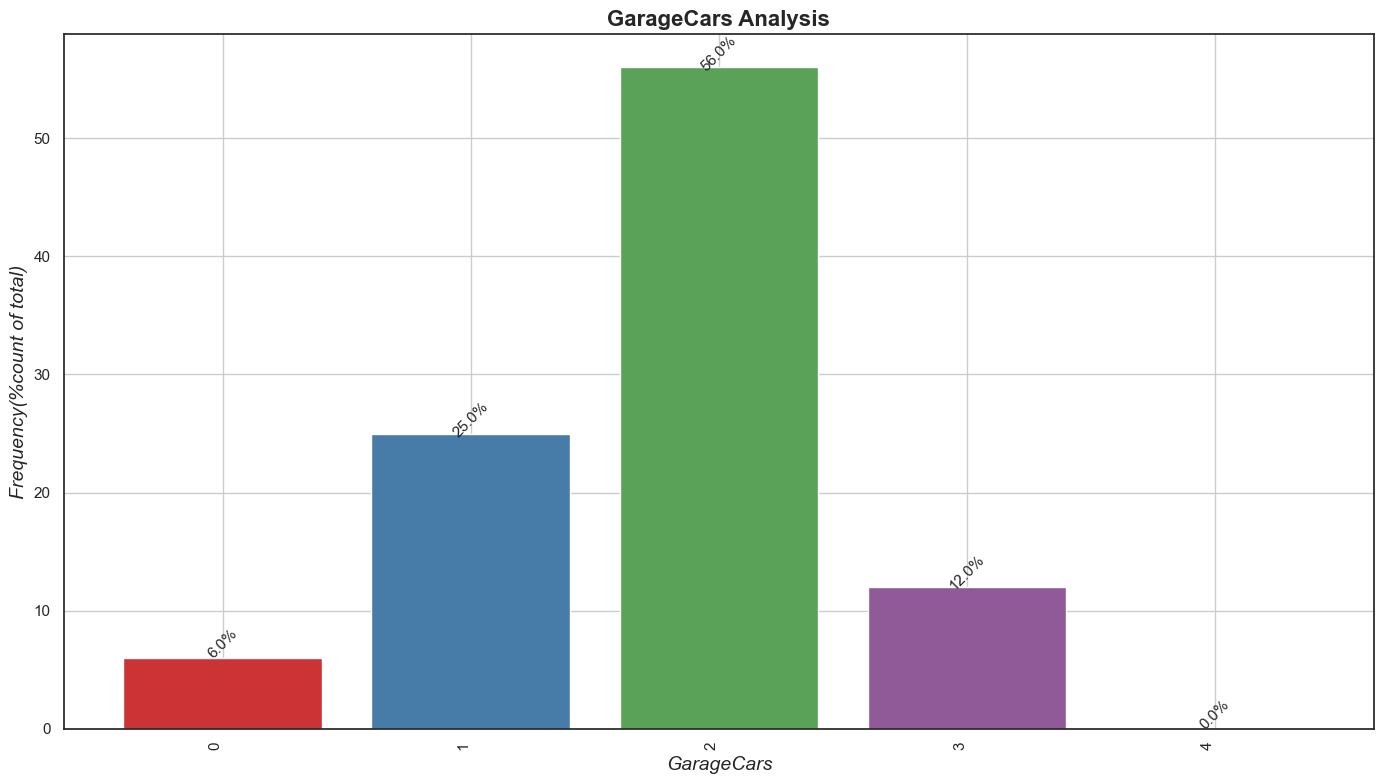

The highest % in  GarageCars category is  [56.0]


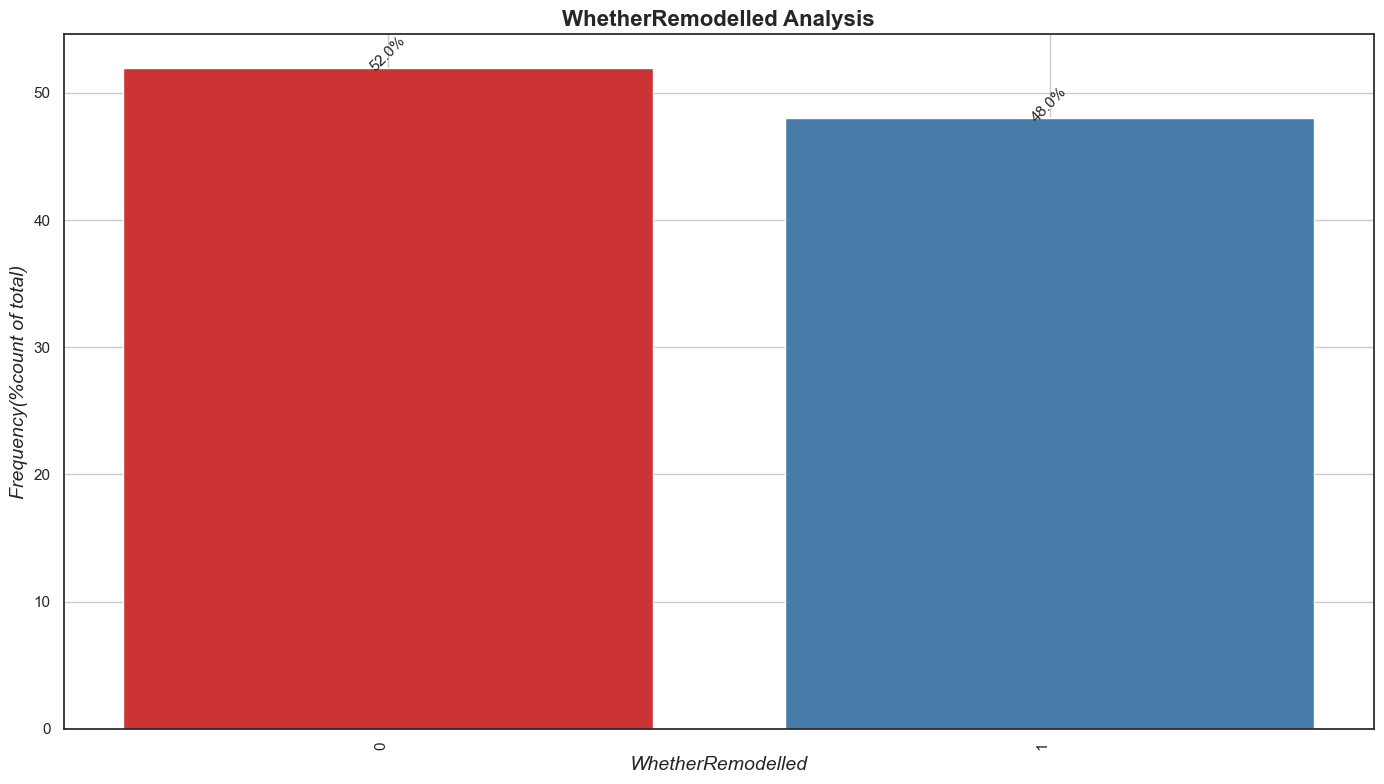

The highest % in  WhetherRemodelled category is  [52.0]


In [47]:

for i in range(0,len(numeric_cat_cols),1):
    sns.set(style='white')
    plt.figure(figsize=(14, 8), dpi=100)
    plot_bar_categorial_percentage(df,numeric_cat_cols[i])
    show_plot(plt)
    ab = pd.DataFrame((df[numeric_cat_cols[i]].value_counts(normalize=True)*100).round(0).sort_values())
    text = ab.values.tolist()[-1]
    print('The highest % in  '+ numeric_cat_cols[i] +' category is  ' + str(text))

**Observations:**<br>
The highest % in  type of dwelling involved in the sale category is  [37.0]<br>
The highest % in  Month Sold (MM)category is June [17.0]<br>
The highest % in  overall material and finish of the house category is  [27.0] means quality is average<br>
The highest % in  OverallCond category is Average [56.0]<br>
The highest % in  Basement full bathrooms category is  [59.0]<br>
The highest % in  FullBath category is  [53.0]<br>
The highest % in  HalfBath category is  [63.0]<br>
The highest % in  Bedrooms Above Ground category 3 is  [55.0]<br>
The highest % in  Total Rooms Above Ground category 6 is  [28.0]<br>
The highest % in  Fireplaces category is  [47.0]<br>
The highest % in  GarageCars category 2 is  [56.0]<br>
The highest % in  WhetherRemodelled category is  [52.0]<br>

No significant preferences for Fireplaces (0 0r 1) and WhetherRemodelled (House) or not.


In [48]:
##removing unique columns i.e Id and as company is analyzing the business opportunity then Month of sold has least preference
# so dropping these two columns
df = df.drop(['Id','MoSold'], axis=1)

**Outlier Treatment**

In [49]:
##check outliers
df.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.98,0.99,1])

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    69.863699   10516.828082     6.099315     5.575342   
std      42.300571    22.027677    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
10%      20.000000    49.000000    5000.000000     5.000000     5.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
95%     160.000000   104.000000   17401.150000     8.000000     8.000000   
98%     188.200000   120.820000   25251.620000     9.000000     8.000000   
99%     190.000000   137.410000   37567.640000    10.000000     9.000000   
100%    190.000000   313.000000  215245.000000    10.000000     9.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

        MasVnrArea   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF     1stFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    104.229452   443.639726   567.240411  1057.429452  1162.626712   
std     180.717988   456.098091   441.866955   438.705324   386.587738   
min       0.000000     0.000000     0.000000     0.000000   334.000000   
10%       0.000000     0.000000    74.900000   636.900000   756.900000   
25%       0.000000     0.000000   223.000000   795.750000   882.000000   
50%       0.000000   383.500000   477.500000   991.500000  1087.000000   
75%     168.000000   712.250000   808.000000  1298.250000  1391.250000   
95%     456.000000  1274.000000  1468.000000  1753.000000  1831.250000   
98%     650.820000  1442.640000  1678.200000  2001.640000  2072.280000   
99%     791.280000  1572.410000  1797.050000  2155.050000  2219.460000   
100%   1600.000000  5644.000000  2336.000000  6110.000000  4692.000000   
max    1600.000000  5644.000000  2336.000000  6110.000000  4692.000000   

          2ndFlrSF    GrLivArea  BsmtFullBath     FullBath     HalfBath  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean    346.992466  1515.463699      0.425342     1.565068     0.382877   
std     436.528436   525.480383      0.518911     0.550916     0.502885   
min       0.000000   334.000000      0.000000     0.000000     0.000000   
10%       0.000000   912.000000      0.000000     1.000000     0.000000   
25%       0.000000  1129.500000      0.000000     1.000000     0.000000   
50%       0.000000  1464.000000      0.000000     2.000000     0.000000   
75%     728.000000  1776.750000      1.000000     2.000000     1.000000   
95%    1141.050000  2466.100000      1.000000     2.000000     1.000000   
98%    1318.560000  2782.380000      1.000000     3.000000     1.000000   
99%    1418.920000  3123.480000      2.000000     3.000000     1.000000   
100%   2065.000000  5642.000000      3.000000     3.000000     2.000000   
max    2065.000000  5642.000000      3.000000     3.000000     2.000000   

       BedroomAbvGr  TotRmsAbvGrd   Fireplaces   GarageCars   GarageArea  \
count   1460.000000   1460.000000  1460.000000  1460.000000  1460.000000   
mean       2.866438      6.517808     0.613014     1.767123   472.980137   
std        0.815778      1.625393     0.644666     0.747315   213.804841   
min        0.000000      2.000000     0.000000     0.000000     0.000000   
10%        2.000000      5.000000     0.000000     1.000000   240.000000   
25%        2.000000      5.000000     0.000000     1.000000   334.500000   
50%        3.000000      6.000000     1.000000     2.000000   480.000000   
75%        3.000000      7.000000     1.000000     2.000000   576.000000   
95%        4.000000     10.000000     2.000000     3.000000   850.100000   
98%        4.000000     10.820000     2.000000     3.000000   907.460000   
99%        5.000000

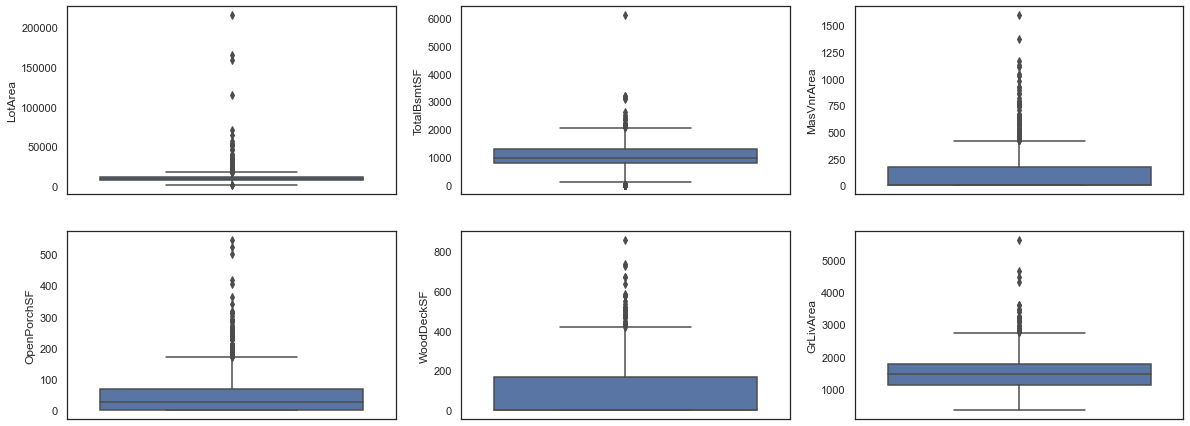

In [50]:
# check the outliers in all the numeric columns (boxplot)

plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', color='b', data = df)
plt.subplot(5,3,2)
sns.boxplot(y = 'TotalBsmtSF', color='b', data = df)
plt.subplot(5,3,3)
sns.boxplot(y = 'MasVnrArea', color='b', data = df)
plt.subplot(5,3,4)
sns.boxplot(y = 'OpenPorchSF', color='b', data = df)
plt.subplot(5,3,5)
sns.boxplot(y = 'WoodDeckSF', color='b', data = df)
plt.subplot(5,3,6)
sns.boxplot(y = 'GrLivArea', color='b', data = df)


plt.show()

In [51]:
df.shape

(1460, 44)

In [52]:
#removing the Outliers
# Removing values beyond 99%

q_LotArea = df['LotArea'].quantile(0.99)
df = df[df["LotArea"] < q_LotArea]

q_TotalBsmtSF = df['TotalBsmtSF'].quantile(0.99)
df = df[df["TotalBsmtSF"] < q_TotalBsmtSF]


q_WoodDeckSF = df['WoodDeckSF'].quantile(0.99)
df = df[df["WoodDeckSF"] < q_WoodDeckSF]


q_OpenPorchSF = df['OpenPorchSF'].quantile(0.99)
df = df[df["OpenPorchSF"] < q_OpenPorchSF]

In [53]:
# Determine the percentage of data retained

retained_data = round(100*(len(df)/total_records),2)
print(retained_data,"%")

95.89 %


In [54]:
df.to_csv("clean_data.csv")

## <font color='Blue'> Step 3: Data Visualization

**Visualising the Target Variable: SalePrice**

In [55]:
#df = pd.read_csv("/Users/i311077/Downloads/clean_data.csv") 
df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig Neighborhood  \
0          60       RL         65.0     8450      Reg    Inside      CollgCr   
1          20       RL         80.0     9600      Reg       FR2      Veenker   
2          60       RL         68.0    11250      IR1    Inside      CollgCr   
3          70       RL         60.0     9550      IR1    Corner      Crawfor   
4          60       RL         84.0    14260      IR1       FR2      NoRidge   

  HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story            7            5     Gable     VinylSd     VinylSd   
1     1Story            6            8     Gable     MetalSd     MetalSd   
2     2Story            7            5     Gable     VinylSd     VinylSd   
3     2Story            7            5     Gable     Wd Sdng     Wd Shng   
4     2Story            8            5     Gable     VinylSd     VinylSd   

  MasVnrType  MasVnrArea ExterQual Foundation BsmtQual BsmtExposure  \
0    BrkFace       196.0        Gd      PConc       Gd           No   
1       None         0.0        TA     CBlock       Gd           Gd   
2    BrkFace       162.0        Gd      PConc       Gd           Mn   
3       None         0.0        TA     BrkTil       TA           No   
4    BrkFace       350.0        Gd      PConc       Gd           Av   

  BsmtFinType1  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF HeatingQC  1stFlrSF  \
0          GLQ         706        150          856        Ex       856   
1          ALQ         978        284         1262        Ex      1262   
2          GLQ         486        434          920        Ex       920   
3          ALQ         216        540          756        Gd       961   
4          GLQ         655        490         1145        Ex      1145   

   2ndFlrSF  GrLivArea  BsmtFullBath  FullBath  HalfBath  BedroomAbvGr  \
0       854       1710             1         2         1             3   
1         0       1262             0         2         0             3   
2       866       1786             1         2         1             3   
3       756       1717             1         1         0             3   
4      1053       2198             1         2         1             4   

  KitchenQual  TotRmsAbvGrd  Fireplaces FireplaceQu GarageType GarageFinish  \
0          Gd             8           0        None     Attchd          RFn   
1          TA             6           1          TA     Attchd          RFn   
2          Gd             6           1          TA     Attchd          RFn   
3          Gd             7           1          Gd     Detchd          Unf   
4          Gd             9           1          TA     Attchd          RFn   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  \
0           2         548           0           61     208500   
1           2         460         298            0     181500   
2           2         608           0           42     223500   
3           3         642           0           35     140000   
4           3         836         192           84     250000   

   WhetherRemodelled  AgeofProperty  
0                  0              5  
1                  0             31  
2                  1              7  
3                  1             91  
4                  0              8


 mu = 176672.56 and sigma = 72121.18



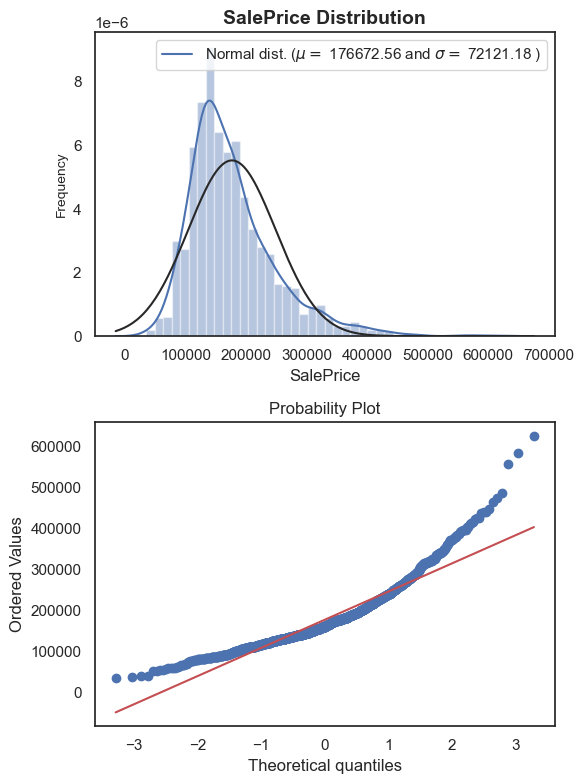

In [56]:
##visualising the target variable 'SalePrice' also we will try to check  distribution  of the data and 
#we will plot Quantile-Quantile Plot to know if the distribution is similar with respect of two variables
from scipy import stats
from scipy.stats import norm

plt.figure(figsize=(6,8), dpi=100)
plt.subplot(211)
sns.distplot(df['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency', fontsize=10)
plt.title('SalePrice Distribution', fontsize=14, fontweight='bold')

#Get also the QQ-plot
plt.subplot(212)
res = stats.probplot(df['SalePrice'], plot=plt)

plt.autoscale()
plt.tight_layout()
plt.show()

**Observation:** <br>
As the red line does not touch all the points , it has some skewness in the data so we can use log-transformation .


 mu = 12.01 and sigma = 0.38



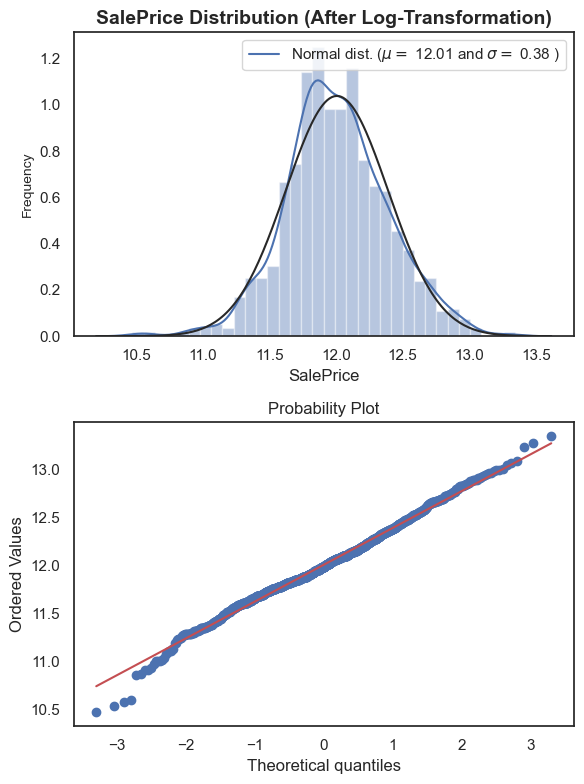

In [57]:
create_resd_qqplot(df,'SalePrice','SalePrice Distribution (After Log-Transformation)')

**Observations:**<br> (1) Now the SalePrice distribution plot almost normal distributed  <br>(2) Now the red line touches maximum points though still some skewness is there

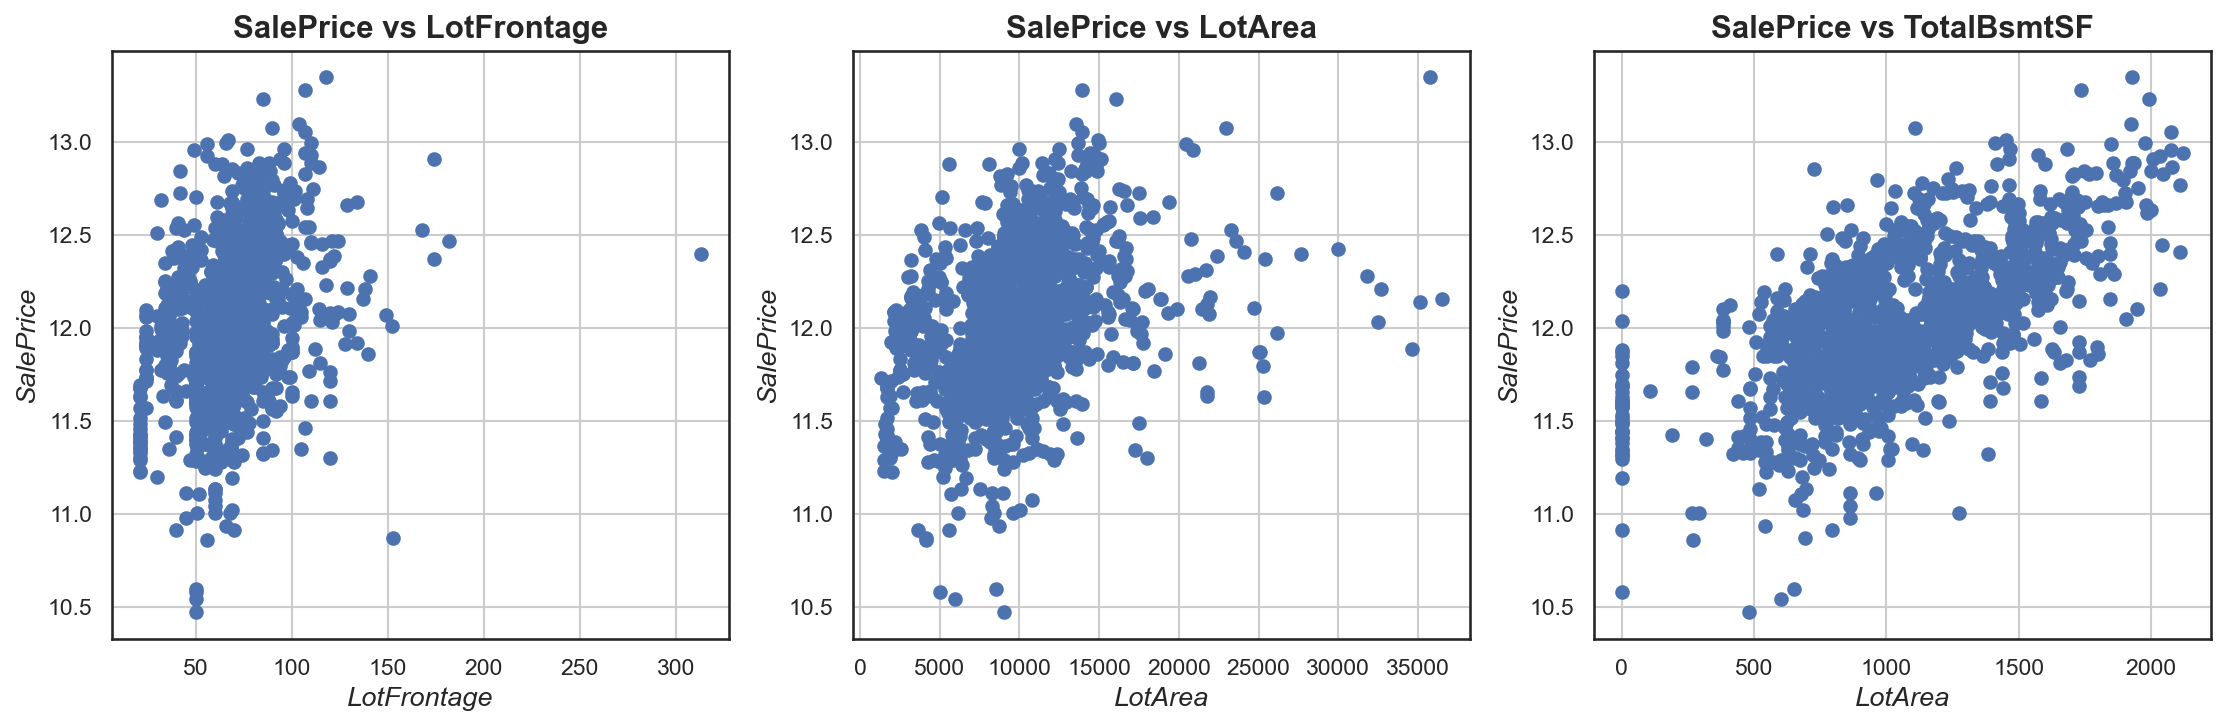

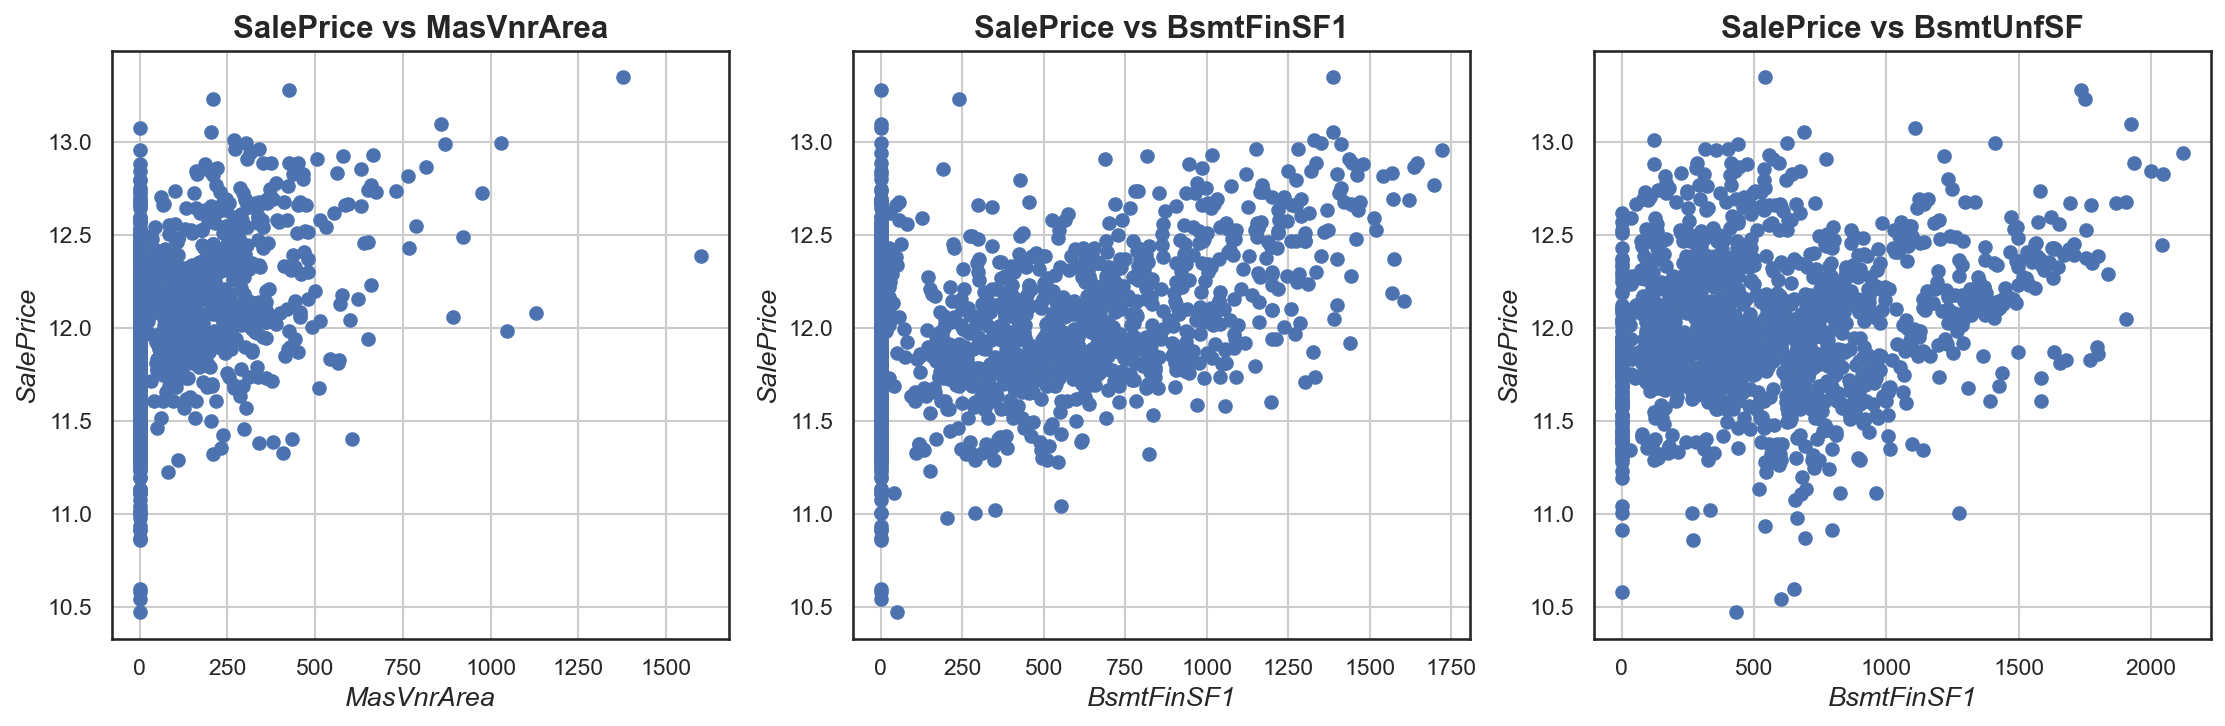

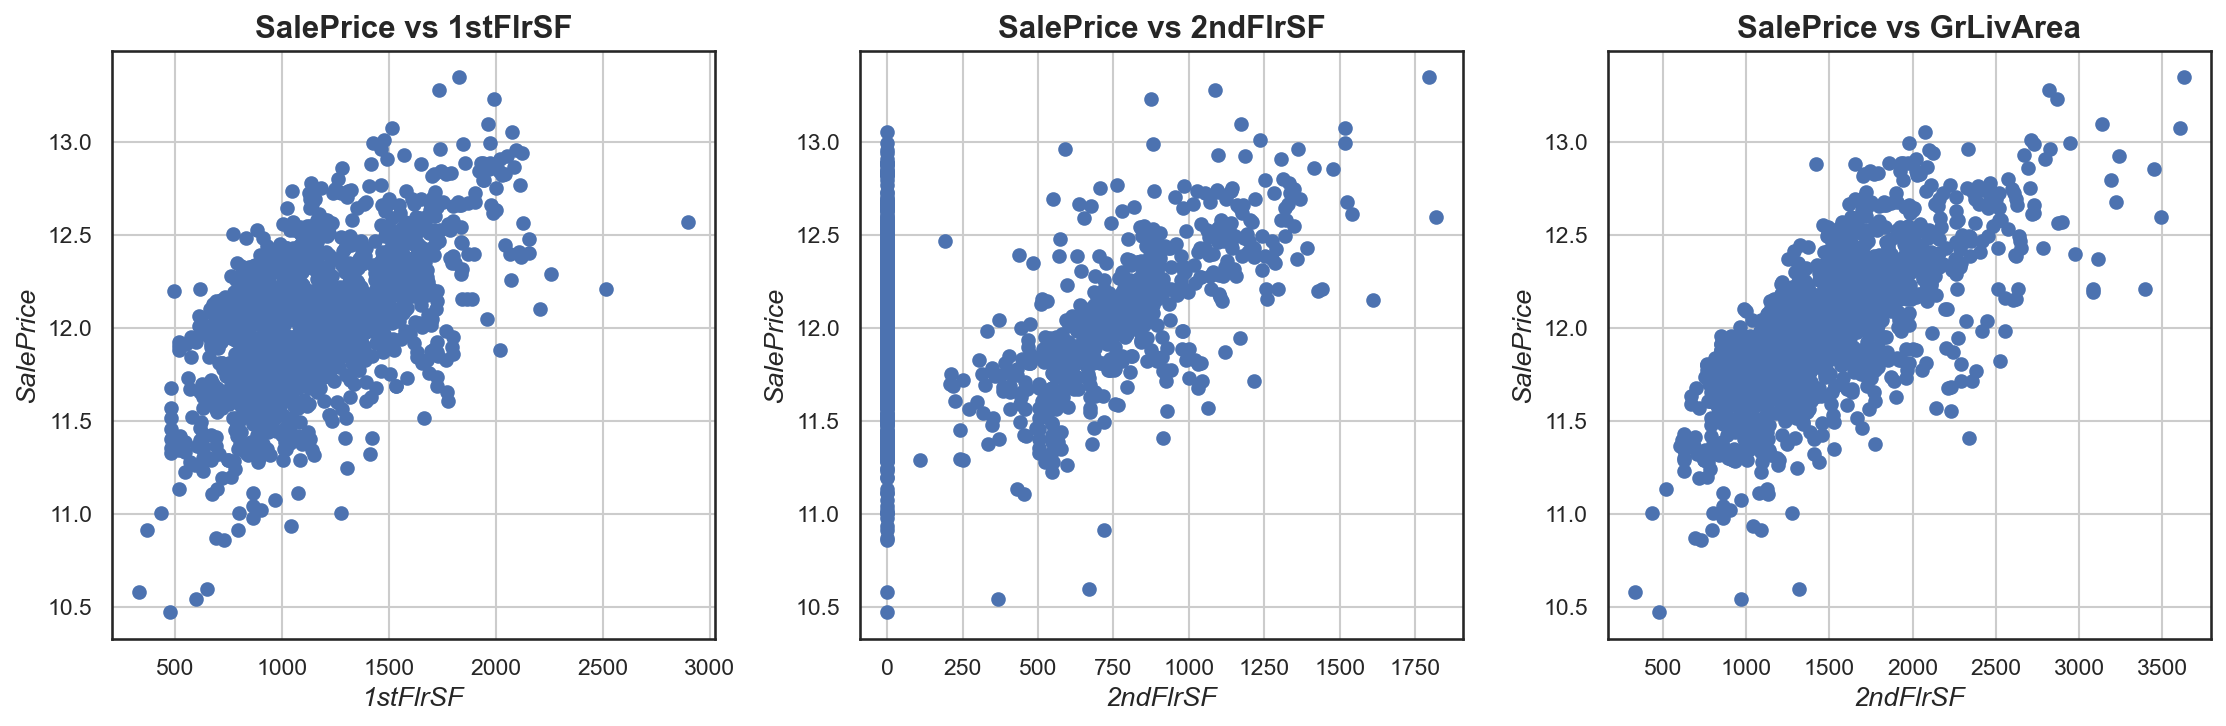

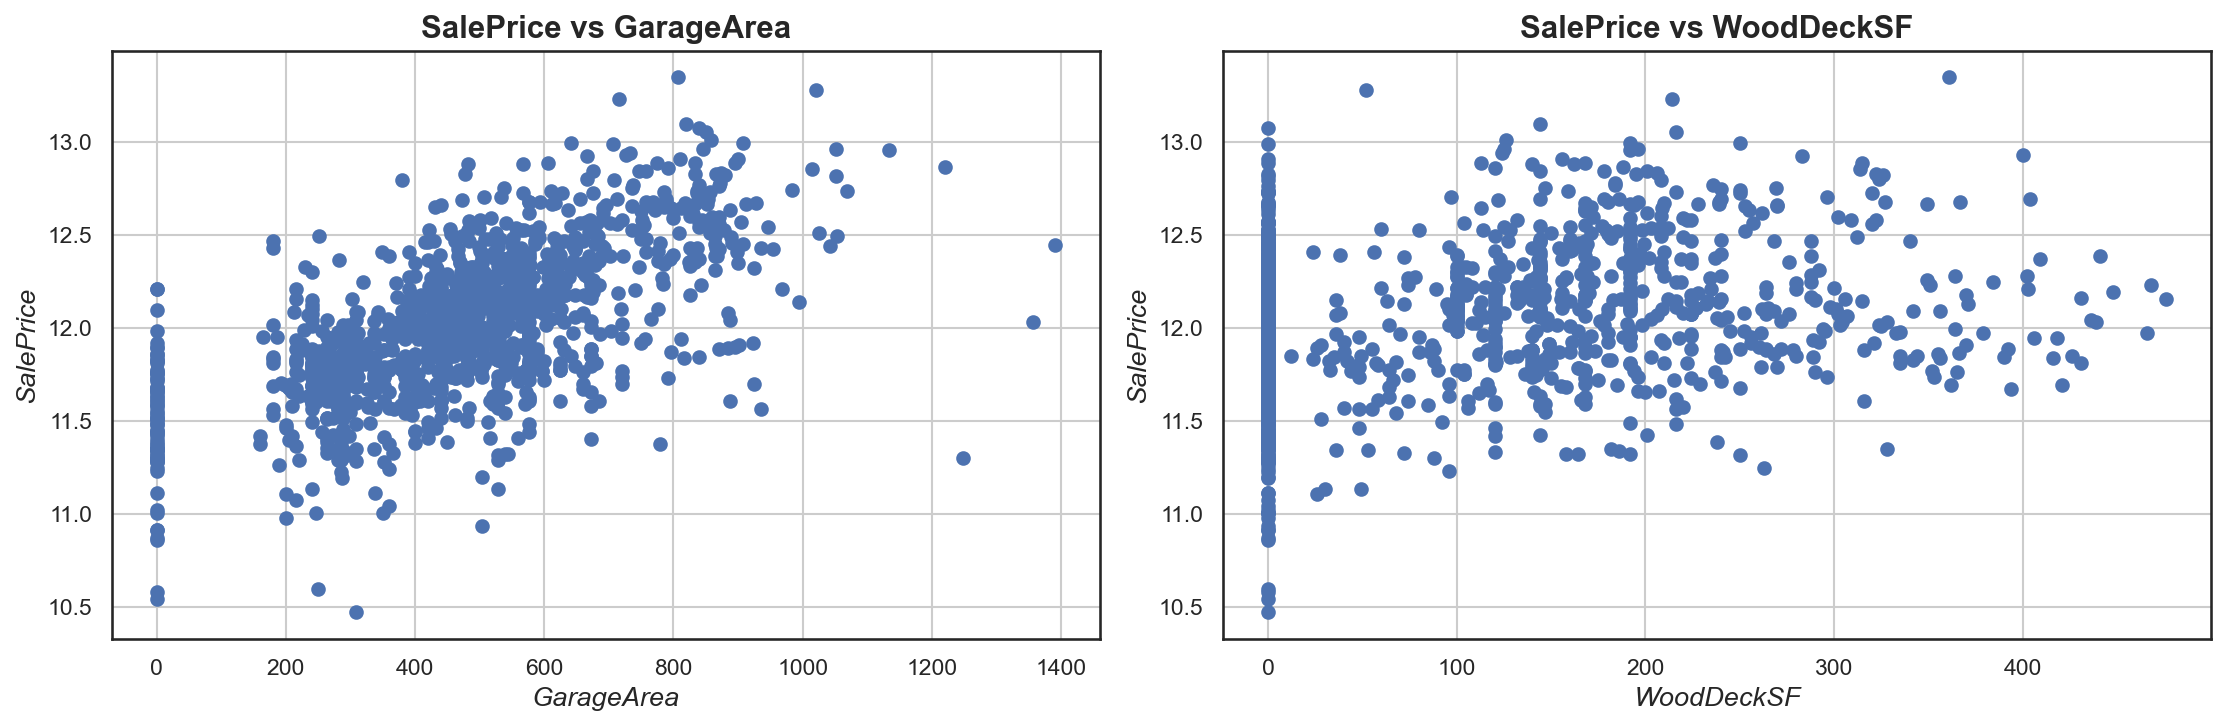

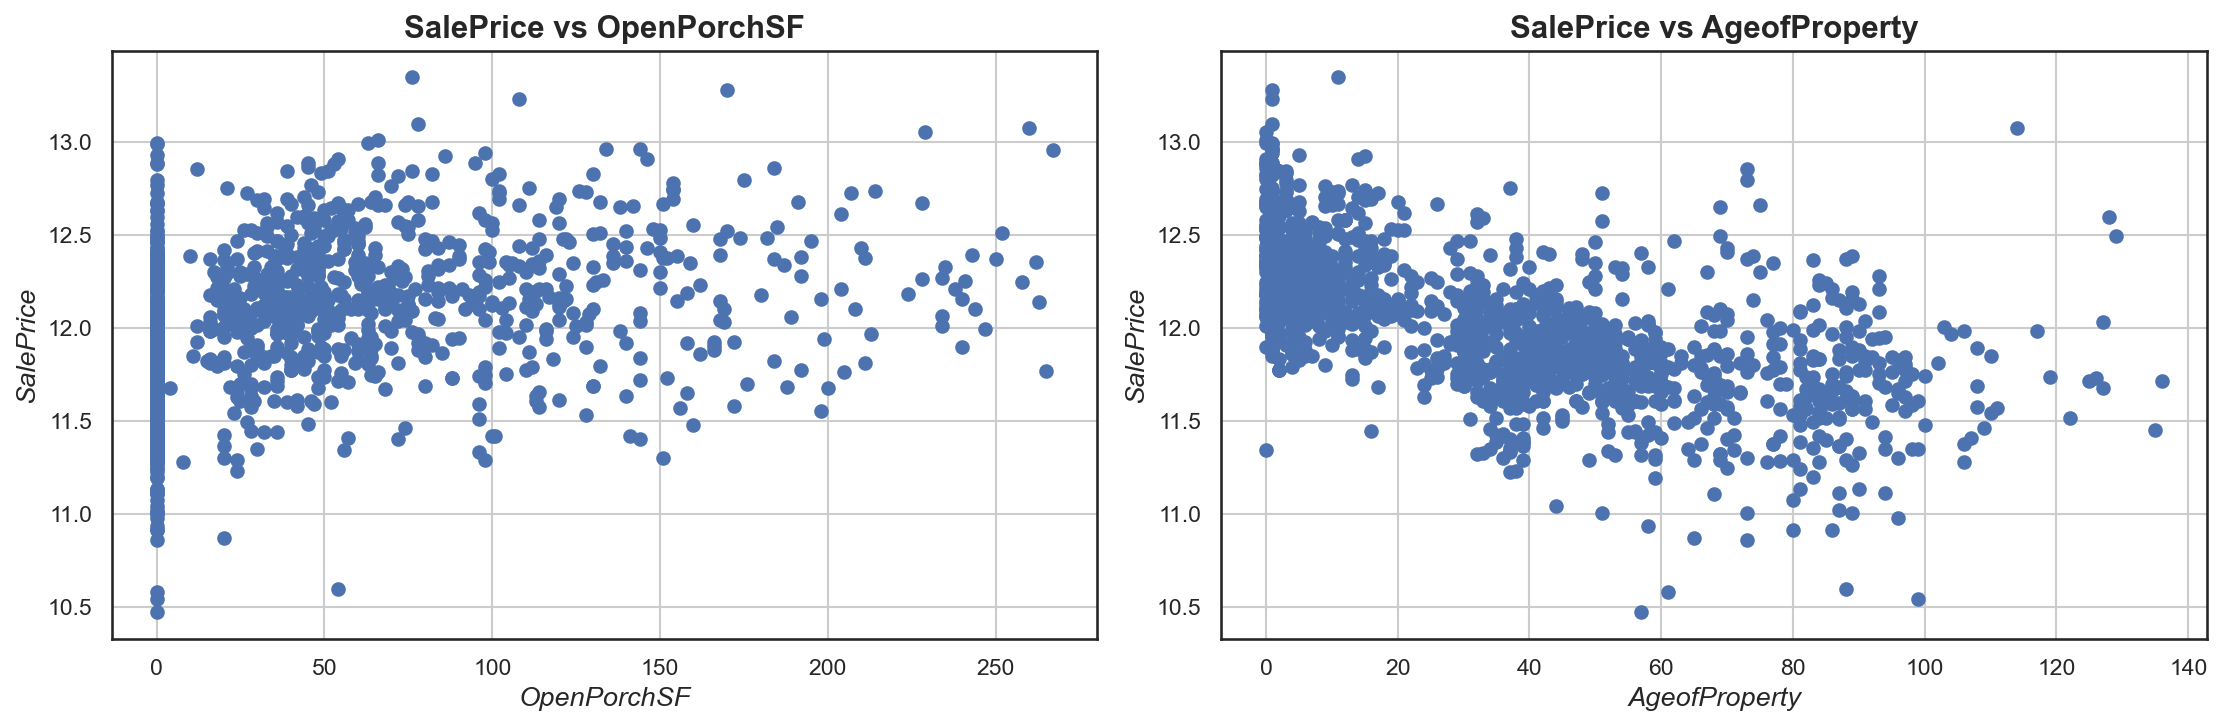

In [58]:
scatter_plt(df,'LotFrontage', 'LotArea','TotalBsmtSF','SalePrice',3)
scatter_plt(df,'MasVnrArea','BsmtFinSF1', 'BsmtUnfSF','SalePrice',3)
scatter_plt(df,'1stFlrSF','2ndFlrSF', 'GrLivArea','SalePrice',3)
scatter_plt(df,'GarageArea', 'WoodDeckSF',0,'SalePrice',2)
scatter_plt(df,'OpenPorchSF', 'AgeofProperty',0,'SalePrice',2)

**Observations**<br>(1) From the scatter plot, we can conclude `'1stFlrSF'`,`'GrLivArea'` show a positive correlation with the SalePrice.<br>(2) Other continuous variables are too scattered and some values are outliers. . Let's eliminate them first.

In [59]:


df = df.loc[~((df['SalePrice']<11.0) & (df['LotFrontage']>150))]
df = df.loc[~((df['SalePrice']>12.0) & (df['MasVnrArea']>1500))]
df = df.loc[~((df['SalePrice']>12.0) & (df['1stFlrSF']>2500))]
df = df.loc[~((df['SalePrice']<12.5) & (df['GarageArea']>1200))]

In [60]:
## Determine the percentage of data retained in the dataset

new_retained_data = round(100*(len(df)/total_records),2)
print(new_retained_data,"%")

95.41 %


In [61]:
def heatmap_corr():
    numeric_vars= df.select_dtypes(include=['int32','float32','int64','float64']).columns
    plt.figure(figsize = (12,10), dpi=120)
    corr_matrix_new = df[numeric_vars].corr()
    my_mask_1 = np.triu(np.ones_like(corr_matrix_new, dtype=np.bool))
    f, ax_corr1 = plt.subplots(figsize=(15, 15), dpi=100)
    ax_corr1 = sns.heatmap(corr_matrix_new, cmap= 'RdYlGn', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,
            square=True, mask=my_mask_1, annot=True)
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.autoscale()
    plt.show()

<Figure size 1440x1200 with 0 Axes>

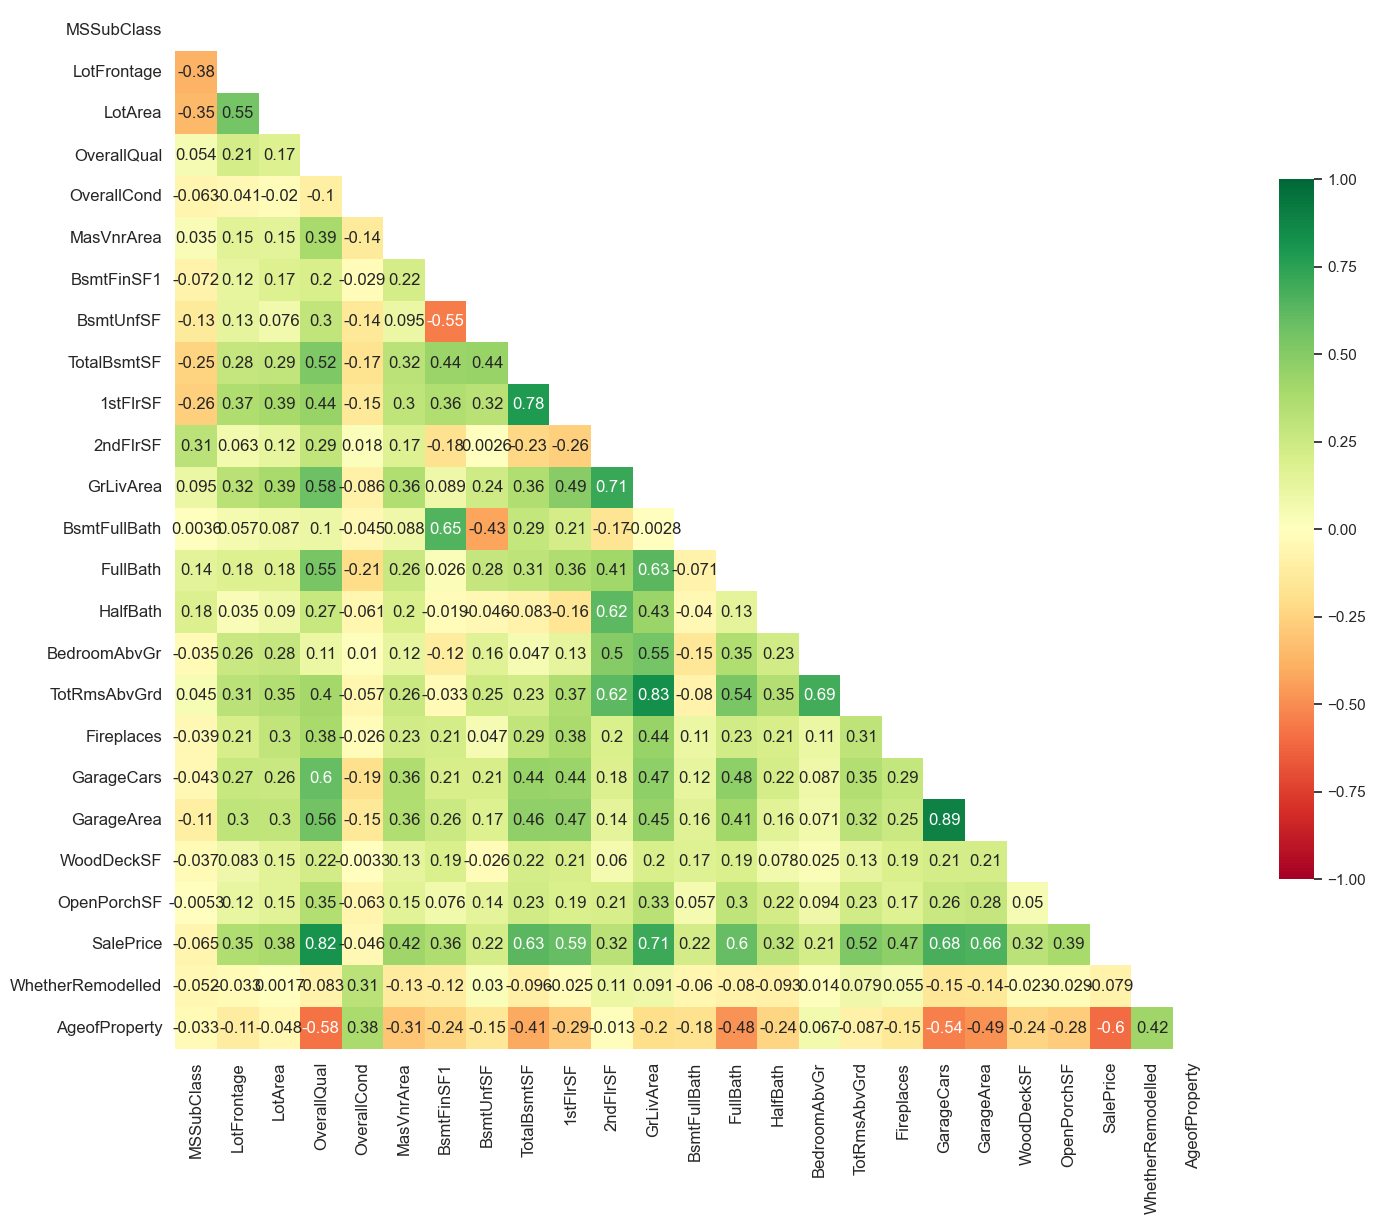

In [62]:
heatmap_corr()

**Observations:**<br>(1)The predictors `'GrLivArea'` and `'TotRmsAbvGrd'` shows (0.83) strong positive correlation. Hence, dropping `'TotRmsAbvGrd'`.<br>(2)The predictors `'GarageCars'` and `'GarageArea'` shows (0.89) strong positive correlation. Hence, dropping `'GarageCars'`.<br>(1)The predictors `'GrLivArea'` and `'2ndFlrSF'` shows (0.71) strong positive correlation. Hence, dropping `'2ndFlrSF'`.<br>(2)The predictors `'1stFlrSF'` and `'TotalBsmtSF'` shows (0.78) strong positive correlation. Hence, dropping `'1stFlrSF'`.<br>

In [63]:
##removing the highly correlated predictors to reduce multicollinearity.

df= df.drop(['TotRmsAbvGrd', 'GarageCars', '2ndFlrSF', '1stFlrSF'], axis = 1)
df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig Neighborhood  \
0          60       RL         65.0     8450      Reg    Inside      CollgCr   
1          20       RL         80.0     9600      Reg       FR2      Veenker   
2          60       RL         68.0    11250      IR1    Inside      CollgCr   
3          70       RL         60.0     9550      IR1    Corner      Crawfor   
4          60       RL         84.0    14260      IR1       FR2      NoRidge   

  HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story            7            5     Gable     VinylSd     VinylSd   
1     1Story            6            8     Gable     MetalSd     MetalSd   
2     2Story            7            5     Gable     VinylSd     VinylSd   
3     2Story            7            5     Gable     Wd Sdng     Wd Shng   
4     2Story            8            5     Gable     VinylSd     VinylSd   

  MasVnrType  MasVnrArea ExterQual Foundation BsmtQual BsmtExposure  \
0    BrkFace       196.0        Gd      PConc       Gd           No   
1       None         0.0        TA     CBlock       Gd           Gd   
2    BrkFace       162.0        Gd      PConc       Gd           Mn   
3       None         0.0        TA     BrkTil       TA           No   
4    BrkFace       350.0        Gd      PConc       Gd           Av   

  BsmtFinType1  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF HeatingQC  GrLivArea  \
0          GLQ         706        150          856        Ex       1710   
1          ALQ         978        284         1262        Ex       1262   
2          GLQ         486        434          920        Ex       1786   
3          ALQ         216        540          756        Gd       1717   
4          GLQ         655        490         1145        Ex       2198   

   BsmtFullBath  FullBath  HalfBath  BedroomAbvGr KitchenQual  Fireplaces  \
0             1         2         1             3          Gd           0   
1             0         2         0             3          TA           1   
2             1         2         1             3          Gd           1   
3             1         1         0             3          Gd           1   
4             1         2         1             4          Gd           1   

  FireplaceQu GarageType GarageFinish  GarageArea  WoodDeckSF  OpenPorchSF  \
0        None     Attchd          RFn         548           0           61   
1          TA     Attchd          RFn         460         298            0   
2          TA     Attchd          RFn         608           0           42   
3          Gd     Detchd          Unf         642           0           35   
4          TA     Attchd          RFn         836         192           84   

   SalePrice  WhetherRemodelled  AgeofProperty  
0  12.247699                  0              5  
1  12.109016                  0             31  
2  12.317171                  1              7  
3  11.849405                  1             91  
4  12.429220                  0              8

<Figure size 1440x1200 with 0 Axes>

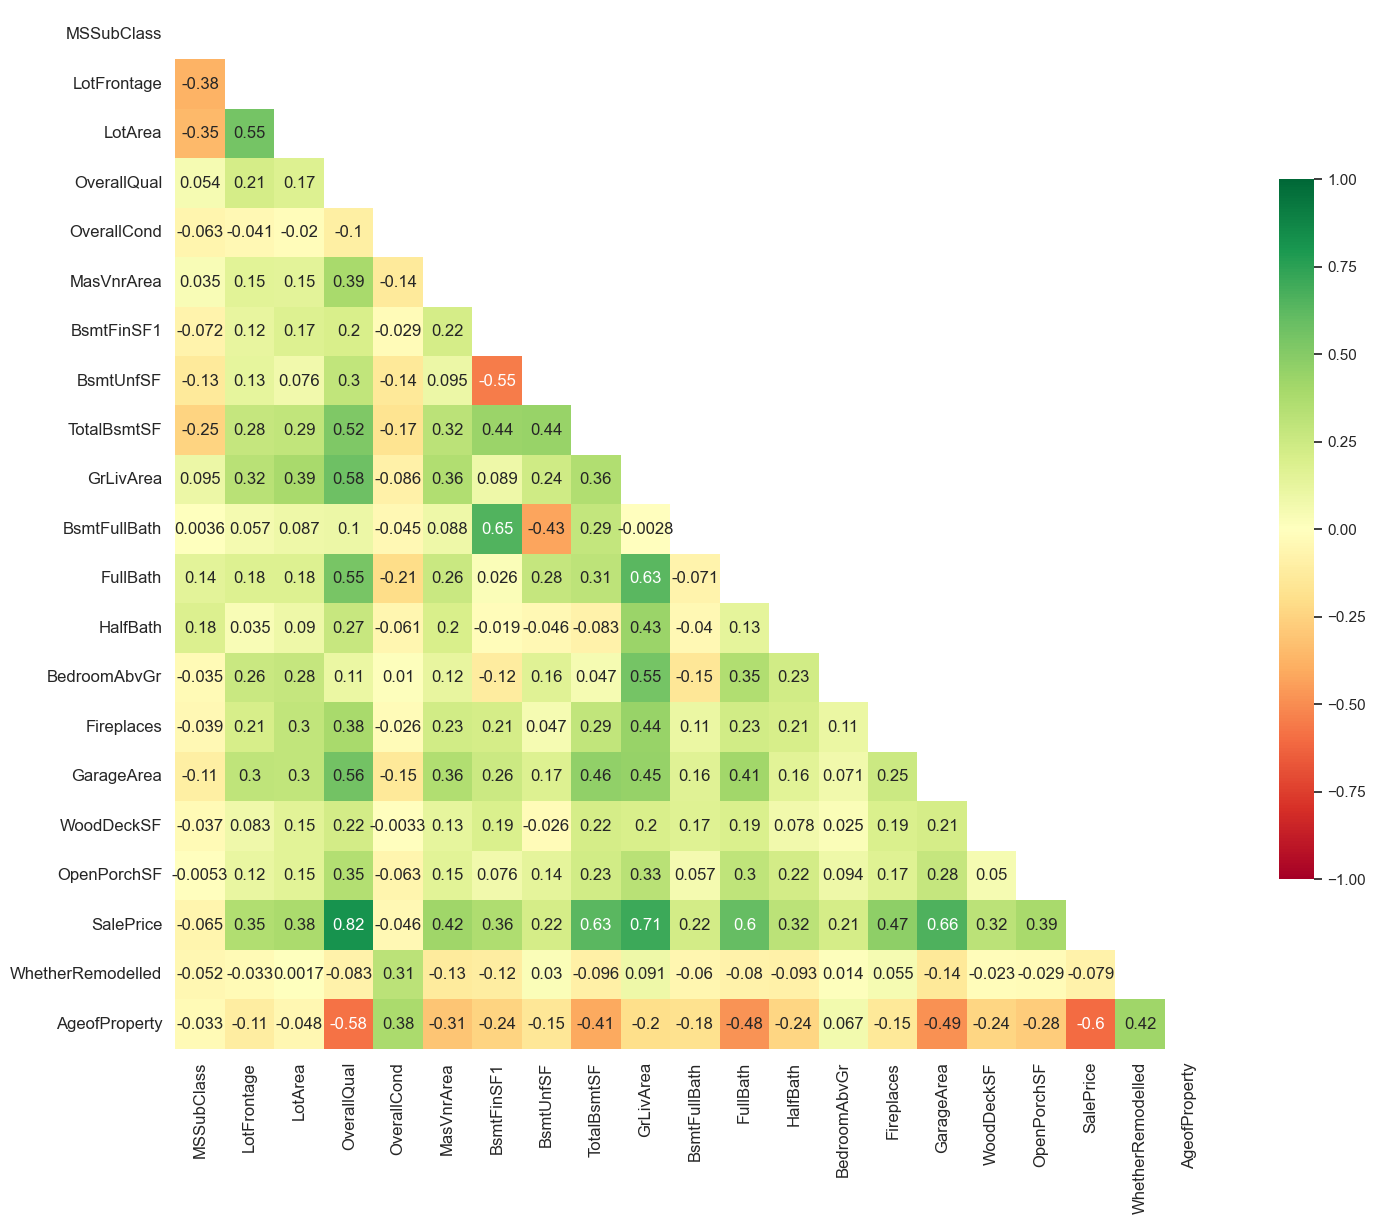

In [64]:
heatmap_corr()

In [65]:
#Housing Dataframe Shape Check
df.shape

(1393, 40)

In [66]:
df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig Neighborhood  \
0          60       RL         65.0     8450      Reg    Inside      CollgCr   
1          20       RL         80.0     9600      Reg       FR2      Veenker   
2          60       RL         68.0    11250      IR1    Inside      CollgCr   
3          70       RL         60.0     9550      IR1    Corner      Crawfor   
4          60       RL         84.0    14260      IR1       FR2      NoRidge   

  HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story            7            5     Gable     VinylSd     VinylSd   
1     1Story            6            8     Gable     MetalSd     MetalSd   
2     2Story            7            5     Gable     VinylSd     VinylSd   
3     2Story            7            5     Gable     Wd Sdng     Wd Shng   
4     2Story            8            5     Gable     VinylSd     VinylSd   

  MasVnrType  MasVnrArea ExterQual Foundation BsmtQual BsmtExposure  \
0    BrkFace       196.0        Gd      PConc       Gd           No   
1       None         0.0        TA     CBlock       Gd           Gd   
2    BrkFace       162.0        Gd      PConc       Gd           Mn   
3       None         0.0        TA     BrkTil       TA           No   
4    BrkFace       350.0        Gd      PConc       Gd           Av   

  BsmtFinType1  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF HeatingQC  GrLivArea  \
0          GLQ         706        150          856        Ex       1710   
1          ALQ         978        284         1262        Ex       1262   
2          GLQ         486        434          920        Ex       1786   
3          ALQ         216        540          756        Gd       1717   
4          GLQ         655        490         1145        Ex       2198   

   BsmtFullBath  FullBath  HalfBath  BedroomAbvGr KitchenQual  Fireplaces  \
0             1         2         1             3          Gd           0   
1             0         2         0             3          TA           1   
2             1         2         1             3          Gd           1   
3             1         1         0             3          Gd           1   
4             1         2         1             4          Gd           1   

  FireplaceQu GarageType GarageFinish  GarageArea  WoodDeckSF  OpenPorchSF  \
0        None     Attchd          RFn         548           0           61   
1          TA     Attchd          RFn         460         298            0   
2          TA     Attchd          RFn         608           0           42   
3          Gd     Detchd          Unf         642           0           35   
4          TA     Attchd          RFn         836         192           84   

   SalePrice  WhetherRemodelled  AgeofProperty  
0  12.247699                  0              5  
1  12.109016                  0             31  
2  12.317171                  1              7  
3  11.849405                  1             91  
4  12.429220                  0              8

## <font color='Blue'> Step 4: Data Preparation

**Using Data Dictionary, to convert the categorical variables into numeric variables**

In [67]:
#lets convert categorical values to numerical
#df['d_LotShape'] = df['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}) 
df['d_ExterQual'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
df['d_BsmtQual'] = df['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

df['d_BsmtExposure'] = df['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
df['d_BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
df['d_HeatingQC'] = df['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

df['d_KitchenQual'] = df['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_FireplaceQu'] = df['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_GarageFinish'] = df['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })

df = df.drop(['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', \
                                'KitchenQual', 'FireplaceQu', 'GarageFinish' ], axis=1)

df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotConfig Neighborhood  \
0          60       RL         65.0     8450    Inside      CollgCr   
1          20       RL         80.0     9600       FR2      Veenker   
2          60       RL         68.0    11250    Inside      CollgCr   
3          70       RL         60.0     9550    Corner      Crawfor   
4          60       RL         84.0    14260       FR2      NoRidge   

  HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story            7            5     Gable     VinylSd     VinylSd   
1     1Story            6            8     Gable     MetalSd     MetalSd   
2     2Story            7            5     Gable     VinylSd     VinylSd   
3     2Story            7            5     Gable     Wd Sdng     Wd Shng   
4     2Story            8            5     Gable     VinylSd     VinylSd   

  MasVnrType  MasVnrArea Foundation  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
0    BrkFace       196.0      PConc         706        150          856   
1       None         0.0     CBlock         978        284         1262   
2    BrkFace       162.0      PConc         486        434          920   
3       None         0.0     BrkTil         216        540          756   
4    BrkFace       350.0      PConc         655        490         1145   

   GrLivArea  BsmtFullBath  FullBath  HalfBath  BedroomAbvGr  Fireplaces  \
0       1710             1         2         1             3           0   
1       1262             0         2         0             3           1   
2       1786             1         2         1             3           1   
3       1717             1         1         0             3           1   
4       2198             1         2         1             4           1   

  GarageType  GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  \
0     Attchd         548           0           61  12.247699   
1     Attchd         460         298            0  12.109016   
2     Attchd         608           0           42  12.317171   
3     Detchd         642           0           35  11.849405   
4     Attchd         836         192           84  12.429220   

   WhetherRemodelled  AgeofProperty  d_ExterQual  d_BsmtQual  d_BsmtExposure  \
0                  0              5            4           4               1   
1                  0             31            3           4               4   
2                  1              7            4           4               2   
3                  1             91            3           3               1   
4                  0              8            4           4               3   

   d_BsmtFinType1  d_HeatingQC  d_KitchenQual  d_FireplaceQu  d_GarageFinish  
0               6            5              4              0               2  
1               5            5              3              3               2  
2               6            5              4              3               2  
3               5            4              4              4               1  
4               6            5              4              3               2

In [68]:
orig_before_dum_cols = ['MSSubClass','MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', \
              'GarageType',  'LotConfig' ,'HouseStyle', 'MasVnrType']

In [69]:
df = create_dummies(df,orig_before_dum_cols,'du_')

In [70]:
df

MSSubClass MSZoning  LotFrontage  LotArea LotConfig Neighborhood  \
0             60       RL         65.0     8450    Inside      CollgCr   
1             20       RL         80.0     9600       FR2      Veenker   
2             60       RL         68.0    11250    Inside      CollgCr   
3             70       RL         60.0     9550    Corner      Crawfor   
4             60       RL         84.0    14260       FR2      NoRidge   
...          ...      ...          ...      ...       ...          ...   
1454          20       FV         62.0     7500    Inside      Somerst   
1455          60       RL         62.0     7917    Inside      Gilbert   
1456          20       RL         85.0    13175    Inside       NWAmes   
1457          70       RL         66.0     9042    Inside      Crawfor   
1458          20       RL         68.0     9717    Inside        NAmes   

     HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0        2Story            7            5     Gable     VinylSd     VinylSd   
1        1Story            6            8     Gable     MetalSd     MetalSd   
2        2Story            7            5     Gable     VinylSd     VinylSd   
3        2Story            7            5     Gable     Wd Sdng     Wd Shng   
4        2Story            8            5     Gable     VinylSd     VinylSd   
...         ...          ...          ...       ...         ...         ...   
1454     1Story            7            5     Gable     VinylSd     VinylSd   
1455     2Story            6            5     Gable     VinylSd     VinylSd   
1456     1Story            6            6     Gable     Plywood     Plywood   
1457     2Story            7            9     Gable     CemntBd     CmentBd   
1458     1Story            5            6       Hip     MetalSd     MetalSd   

     MasVnrType  MasVnrArea Foundation  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
0       BrkFace       196.0      PConc         706        150          856   
1          None         0.0     CBlock         978        284         1262   
2       BrkFace       162.0      PConc         486        434          920   
3          None         0.0     BrkTil         216        540          756   
4       BrkFace       350.0      PConc         655        490         1145   
...         ...         ...        ...         ...        ...          ...   
1454       None         0.0      PConc         410        811         1221   
1455       None         0.0      PConc           0        953          953   
1456      Stone       119.0     CBlock         790        589         1542   
1457       None         0.0      Stone         275        877         1152   
1458       None         0.0     CBlock          49          0         1078   

      GrLivArea  BsmtFullBath  FullBath  HalfBath  BedroomAbvGr  Fireplaces  \
0          1710             1         2         1             3           0   
1          1262             0         2         0             3           1   
2          1786             1         2         1             3           1   
3          1717             1         1         0             3           1   
4          2198             1         2         1             4           1   
...         ...           ...       ...       ...           ...         ...   
1454       1221             1         2         0             2           0   
1455       1647             0         2         1             3           1   
1456       2073             1         2         0             3           2   
1457       2340             0         2         0             4           2   
1458       1078             1         1         0             2           0   

     GarageType  GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  \
0        Attchd         548           0           61  12.247699   
1        Attchd         460         298            0  12.109016   
2        Attchd         608           0           42  12.317171   
3        Detch

In [71]:
df.head(10)

MSSubClass MSZoning  LotFrontage  LotArea LotConfig Neighborhood  \
0          60       RL         65.0     8450    Inside      CollgCr   
1          20       RL         80.0     9600       FR2      Veenker   
2          60       RL         68.0    11250    Inside      CollgCr   
3          70       RL         60.0     9550    Corner      Crawfor   
4          60       RL         84.0    14260       FR2      NoRidge   
5          50       RL         85.0    14115    Inside      Mitchel   
6          20       RL         75.0    10084    Inside      Somerst   
7          60       RL         69.0    10382    Corner       NWAmes   
8          50       RM         51.0     6120    Inside      OldTown   
9         190       RL         50.0     7420    Corner      BrkSide   

  HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story            7            5     Gable     VinylSd     VinylSd   
1     1Story            6            8     Gable     MetalSd     MetalSd   
2     2Story            7            5     Gable     VinylSd     VinylSd   
3     2Story            7            5     Gable     Wd Sdng     Wd Shng   
4     2Story            8            5     Gable     VinylSd     VinylSd   
5     1.5Fin            5            5     Gable     VinylSd     VinylSd   
6     1Story            8            5     Gable     VinylSd     VinylSd   
7     2Story            7            6     Gable     HdBoard     HdBoard   
8     1.5Fin            7            5     Gable     BrkFace     Wd Shng   
9     1.5Unf            5            6     Gable     MetalSd     MetalSd   

  MasVnrType  MasVnrArea Foundation  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
0    BrkFace       196.0      PConc         706        150          856   
1       None         0.0     CBlock         978        284         1262   
2    BrkFace       162.0      PConc         486        434          920   
3       None         0.0     BrkTil         216        540          756   
4    BrkFace       350.0      PConc         655        490         1145   
5       None         0.0       Wood         732         64          796   
6      Stone       186.0      PConc        1369        317         1686   
7      Stone       240.0     CBlock         859        216         1107   
8       None         0.0     BrkTil           0        952          952   
9       None         0.0     BrkTil         851        140          991   

   GrLivArea  BsmtFullBath  FullBath  HalfBath  BedroomAbvGr  Fireplaces  \
0       1710             1         2         1             3           0   
1       1262             0         2         0             3           1   
2       1786             1         2         1             3           1   
3       1717             1         1         0             3           1   
4       2198             1         2         1             4           1   
5       1362             1         1         1             1           0   
6       1694             1         2         0             3           1   
7       2090             1         2         1             3           2   
8       1774             0         2         0             2           2   
9       1077             1         1         0             2           2   

  GarageType  GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  \
0     Attchd         548           0           61  12.247699   
1     Attchd         460         298            0  12.109016   
2     Attchd         608           0           42  12.317171   
3     Detchd         642           0           35  11.849405   
4     Attchd         836         192           84  12.429220   
5     Attchd         480          40           30  11.870607   
6     Attchd         636         255           57  12.634606   
7     Attchd         484         235          204  12.206078   
8     Detchd         468          90            0  11.774528   
9     Attchd         205           0            4  11.678448   

   WhetherRemode

In [72]:


##Dropping columns for which we have created dummies, as we now have new columns derived from these columns
orig_before_dum_cols = ['MSSubClass','MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', \
              'GarageType',  'LotConfig' ,'HouseStyle', 'MasVnrType']
df = df.drop(orig_before_dum_cols, axis=1)

In [73]:
df.head()

LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0         65.0     8450            7            5       196.0         706   
1         80.0     9600            6            8         0.0         978   
2         68.0    11250            7            5       162.0         486   
3         60.0     9550            7            5         0.0         216   
4         84.0    14260            8            5       350.0         655   

   BsmtUnfSF  TotalBsmtSF  GrLivArea  BsmtFullBath  FullBath  HalfBath  \
0        150          856       1710             1         2         1   
1        284         1262       1262             0         2         0   
2        434          920       1786             1         2         1   
3        540          756       1717             1         1         0   
4        490         1145       2198             1         2         1   

   BedroomAbvGr  Fireplaces  GarageArea  WoodDeckSF  OpenPorchSF  SalePrice  \
0             3           0         548           0           61  12.247699   
1             3           1         460         298            0  12.109016   
2             3           1         608           0           42  12.317171   
3             3           1         642           0           35  11.849405   
4             4           1         836         192           84  12.429220   

   WhetherRemodelled  AgeofProperty  d_ExterQual  d_BsmtQual  d_BsmtExposure  \
0                  0              5            4           4               1   
1                  0             31            3           4               4   
2                  1              7            4           4               2   
3                  1             91            3           3               1   
4                  0              8            4           4               3   

   d_BsmtFinType1  d_HeatingQC  d_KitchenQual  d_FireplaceQu  d_GarageFinish  \
0               6            5              4              0               2   
1               5            5              3              3               2   
2               6            5              4              3               2   
3               5            4              4              4               1   
4               6            5              4              3               2   

   du_MSZoning_FV  du_MSZoning_RH  du_MSZoning_RL  du_MSZoning_RM  \
0               0               0               1               0   
1               0               0               1               0   
2               0               0               1               0   
3               0               0               1               0   
4               0               0               1               0   

   du_Neighborhood_Blueste  du_Neighborhood_BrDale  du_Neighborhood_BrkSide  \
0                        0                       0                        0   
1                        0                       0                        0   
2                        0                       0                        0   
3                        0                       0                        0   
4                        0                       0                        0   

   du_Neighborhood_ClearCr  du_Neighborhood_CollgCr  du_Neighborhood_Crawfor  \
0                        0                        1                        0   
1                        0                        0                        0   
2                        0                        1                        0   
3                        0                        0                        1   
4                        0                        0                        0   

   du_Neighborhood_Edwards  du_Neighborhood_Gilbert  du_Neighborhood_IDOTRR  \
0                        0                        0                       0   
1                        0                        0                       0   
2                        0                        

In [74]:
##rechecking and eliminating those predictor variables that have a correlation of (threshold:-0.7 to 0.7) with other predictors.

df_corr = df.drop(['SalePrice'],axis =1)
my_corr_matrix = df_corr.corr().abs()
my_corr_matrix

upper_triangle = my_corr_matrix.where(np.triu(np.ones(my_corr_matrix.shape), k=1).astype(np.bool))
col_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.70)] 
col_to_drop  

['d_ExterQual',
 'd_BsmtFinType1',
 'd_KitchenQual',
 'd_FireplaceQu',
 'du_MSZoning_RM',
 'du_Neighborhood_Somerst',
 'du_RoofStyle_Hip',
 'du_Exterior2nd_CBlock',
 'du_Exterior2nd_CmentBd',
 'du_Exterior2nd_HdBoard',
 'du_Exterior2nd_MetalSd',
 'du_Exterior2nd_Plywood',
 'du_Exterior2nd_Stucco',
 'du_Exterior2nd_VinylSd',
 'du_Exterior2nd_Wd Sdng',
 'du_Foundation_PConc',
 'du_GarageType_Detchd',
 'du_MasVnrType_None']

In [75]:
#drop the column which are highly corelated > 0.7
df = df.drop(col_to_drop, axis=1)

In [76]:
#Recheck Model 
df.shape

(1393, 97)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 0 to 1458
Data columns (total 97 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LotFrontage              1393 non-null   float64
 1   LotArea                  1393 non-null   int64  
 2   OverallQual              1393 non-null   int64  
 3   OverallCond              1393 non-null   int64  
 4   MasVnrArea               1393 non-null   float64
 5   BsmtFinSF1               1393 non-null   int64  
 6   BsmtUnfSF                1393 non-null   int64  
 7   TotalBsmtSF              1393 non-null   int64  
 8   GrLivArea                1393 non-null   int64  
 9   BsmtFullBath             1393 non-null   int64  
 10  FullBath                 1393 non-null   int64  
 11  HalfBath                 1393 non-null   int64  
 12  BedroomAbvGr             1393 non-null   int64  
 13  Fireplaces               1393 non-null   int64  
 14  GarageArea              

We have converted all the columns to numeric.

In [79]:
##keeping one copy as we need to solve subjective questions
df_new1 = df.copy()

## <font color='Blue'> Step 5: Train Test Split

In [80]:
##split into train and test

from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size=0.7, test_size = 0.3, random_state=100)

In [81]:

binary_cols = binary_val_cols(df)
print(binary_cols)

['WhetherRemodelled', 'du_MSZoning_FV', 'du_MSZoning_RH', 'du_MSZoning_RL', 'du_Neighborhood_Blueste', 'du_Neighborhood_BrDale', 'du_Neighborhood_BrkSide', 'du_Neighborhood_ClearCr', 'du_Neighborhood_CollgCr', 'du_Neighborhood_Crawfor', 'du_Neighborhood_Edwards', 'du_Neighborhood_Gilbert', 'du_Neighborhood_IDOTRR', 'du_Neighborhood_MeadowV', 'du_Neighborhood_Mitchel', 'du_Neighborhood_NAmes', 'du_Neighborhood_NPkVill', 'du_Neighborhood_NWAmes', 'du_Neighborhood_NoRidge', 'du_Neighborhood_NridgHt', 'du_Neighborhood_OldTown', 'du_Neighborhood_SWISU', 'du_Neighborhood_Sawyer', 'du_Neighborhood_SawyerW', 'du_Neighborhood_StoneBr', 'du_Neighborhood_Timber', 'du_Neighborhood_Veenker', 'du_RoofStyle_Gable', 'du_RoofStyle_Gambrel', 'du_RoofStyle_Mansard', 'du_RoofStyle_Shed', 'du_Exterior1st_AsphShn', 'du_Exterior1st_BrkComm', 'du_Exterior1st_BrkFace', 'du_Exterior1st_CBlock', 'du_Exterior1st_CemntBd', 'du_Exterior1st_HdBoard', 'du_Exterior1st_ImStucc', 'du_Exterior1st_MetalSd', 'du_Exterior1s

**Feature Scaling**

In [82]:
##Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop(binary_cols, axis=1)
df_test = df_test.drop(binary_cols, axis=1)

##StandardScaler

from sklearn.preprocessing import StandardScaler
all_cols = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [83]:
print(df_train.shape)
print(df_test.shape)

(975, 97)
(418, 97)


In [84]:
##Storing target variable to y_train and y_test respectively

y_train = df_train['SalePrice']
y_test = df_test['SalePrice']

In [85]:
##Storing all feature variables to X_train and X_test
X_train = df_train.drop('SalePrice',axis=1)
X_test = df_test.drop('SalePrice',axis=1)

## <font color='Blue'> Step 6: Recursive Feature Elimination

Since there are around 98 features, we will use RFE to get the best 50 features out of the 98 features and use the new features for further analysis.

In [86]:
##Running RFE with the output number of the variable equal to 50
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select = 50 ,step = 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [87]:
##test_zip file zips features, rfe.support_ and rfe.ranking_
test_zip = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
test_zip

[('LotFrontage', False, 4),
 ('LotArea', False, 4),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', False, 5),
 ('BsmtFinSF1', False, 4),
 ('BsmtUnfSF', False, 4),
 ('TotalBsmtSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 4),
 ('FullBath', False, 5),
 ('HalfBath', False, 4),
 ('BedroomAbvGr', False, 5),
 ('Fireplaces', False, 4),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 4),
 ('OpenPorchSF', False, 4),
 ('AgeofProperty', True, 1),
 ('d_BsmtQual', False, 5),
 ('d_BsmtExposure', False, 4),
 ('d_HeatingQC', False, 4),
 ('d_GarageFinish', False, 5),
 ('WhetherRemodelled', False, 5),
 ('du_MSZoning_FV', True, 1),
 ('du_MSZoning_RH', False, 2),
 ('du_MSZoning_RL', True, 1),
 ('du_Neighborhood_Blueste', True, 1),
 ('du_Neighborhood_BrDale', True, 1),
 ('du_Neighborhood_BrkSide', False, 3),
 ('du_Neighborhood_ClearCr', False, 3),
 ('du_Neighborhood_CollgCr', False, 3),
 ('du_Neighborhood_Crawfor', True, 1),
 ('du_Neighborhood_Edwards', True, 1),


In [88]:
##Checking columns that have RFE support
col_rfe_sup = X_train.columns[rfe.support_]
col_rfe_sup

Index(['OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea', 'GarageArea',
       'AgeofProperty', 'du_MSZoning_FV', 'du_MSZoning_RL',
       'du_Neighborhood_Blueste', 'du_Neighborhood_BrDale',
       'du_Neighborhood_Crawfor', 'du_Neighborhood_Edwards',
       'du_Neighborhood_IDOTRR', 'du_Neighborhood_MeadowV',
       'du_Neighborhood_Mitchel', 'du_Neighborhood_NAmes',
       'du_Neighborhood_NPkVill', 'du_Neighborhood_NWAmes',
       'du_Neighborhood_NridgHt', 'du_Neighborhood_OldTown',
       'du_Neighborhood_Sawyer', 'du_Neighborhood_StoneBr',
       'du_Neighborhood_Veenker', 'du_RoofStyle_Gambrel', 'du_RoofStyle_Shed',
       'du_Exterior1st_BrkComm', 'du_Exterior1st_BrkFace',
       'du_Exterior1st_CemntBd', 'du_Exterior1st_HdBoard',
       'du_Exterior1st_MetalSd', 'du_Exterior1st_Plywood',
       'du_Exterior1st_Stone', 'du_Exterior1st_Stucco',
       'du_Exterior1st_VinylSd', 'du_Exterior1st_Wd Sdng',
       'du_Exterior1st_WdShing', 'du_Exterior2nd_BrkFace',
       'du

In [89]:
##Creating a dataframe for RFE supported top 50 indepedent variables. Assign the 50 features selected using RFE to a dataframe and view them

top50_df = pd.DataFrame(test_zip, columns=['Features', 'rfe_support', 'rfe_ranking'])
top50_df = top50_df.loc[top50_df['rfe_support'] == True]
top50_df.reset_index(drop=True, inplace=True)
top50_df

Features  rfe_support  rfe_ranking
0               OverallQual         True            1
1               OverallCond         True            1
2               TotalBsmtSF         True            1
3                 GrLivArea         True            1
4                GarageArea         True            1
5             AgeofProperty         True            1
6            du_MSZoning_FV         True            1
7            du_MSZoning_RL         True            1
8   du_Neighborhood_Blueste         True            1
9    du_Neighborhood_BrDale         True            1
10  du_Neighborhood_Crawfor         True            1
11  du_Neighborhood_Edwards         True            1
12   du_Neighborhood_IDOTRR         True            1
13  du_Neighborhood_MeadowV         True            1
14  du_Neighborhood_Mitchel         True            1
15    du_Neighborhood_NAmes         True            1
16  du_Neighborhood_NPkVill         True            1
17   du_Neighborhood_NWAmes         True            1
18  du_Neighborhood_NridgHt         True            1
19  du_Neighborhood_OldTown         True            1
20   du_Neighborhood_Sawyer         True            1
21  du_Neighborhood_StoneBr         True            1
22  du_Neighborhood_Veenker         True            1
23     du_RoofStyle_Gambrel         True            1
24        du_RoofStyle_Shed         True            1
25   du_Exterior1st_BrkComm         True            1
26   du_Exterior1st_BrkFace         True            1
27   du_Exterior1st_CemntBd         True            1
28   du_Exterior1st_HdBoard         True            1
29   du_Exterior1st_MetalSd         True            1
30   du_Exterior1st_Plywood         True            1
31     du_Exterior1st_Stone         True            1
32    du_Exterior1st_Stucco         True            1
33   du_Exterior1st_VinylSd         True            1
34   du_Exterior1st_Wd Sdng         True            1
35   du_Exterior1st_WdShing         True            1
36   du_Exterior2nd_BrkFace         True            1
37   du_Exterior2nd_Wd Shng         True            1
38      du_Foundation_Stone         True            1
39       du_Foundation_Wood         True            1
40     du_GarageType_Attchd         True            1
41    du_GarageType_BuiltIn         True            1
42    du_GarageType_CarPort         True            1
43       du_GarageType_None         True            1
44     du_LotConfig_CulDSac         True            1
45         du_LotConfig_FR2         True            1
46         du_LotConfig_FR3         True            1
47     du_HouseStyle_SFoyer         True            1
48       du_HouseStyle_SLvl         True            1
49      du_MasVnrType_Stone         True            1

In [90]:
##Let's Assign top 50 columns to X_train_rfe

X_train_rfe = X_train[col_rfe_sup]

In [91]:
X_train_rfe

OverallQual  OverallCond  TotalBsmtSF  GrLivArea  GarageArea  \
638     -0.800160     1.228673    -0.573010  -1.421555   -2.236869   
1054     1.469934    -0.534324     0.130643   1.023981    0.588854   
927      0.713236    -0.534324    -0.478840   1.001432    0.106649   
340      1.469934    -0.534324    -0.125706   0.857938   -0.158564   
829      0.713236    -0.534324    -1.085708  -0.546246    0.077717   
1016     0.713236    -0.534324     1.278983   0.029777    0.068073   
601     -0.043462     0.347175    -0.614862  -0.234660    0.386328   
1177    -0.043462     2.110171    -0.515462  -0.544196   -1.224238   
567      0.713236    -0.534324     1.312988   0.093324    0.328463   
1039    -1.556858    -1.415822    -1.007234  -1.761839   -0.857762   
1076    -0.800160     2.110171    -0.573010  -0.048119    0.492413   
536      0.713236    -0.534324    -0.353282   0.480756    0.304353   
1078    -0.043462    -0.534324    -0.436988  -1.314960   -0.211607   
274     -0.800160     1.228673    -0.520693  -1.380557   -0.963847   
190      1.469934     2.110171    -0.423908   2.536810   -0.115165   
108     -0.800160     1.228673    -0.580857   0.056426   -2.236869   
1073    -0.043462     0.347175    -0.850285  -0.130115   -0.115165   
1299    -0.800160     1.228673     0.604104  -0.499098   -0.766143   
1386     0.713236    -0.534324     0.986012   2.653654    0.482769   
985     -0.800160    -0.534324     0.389608  -0.667190   -1.079576   
167      1.469934    -0.534324     1.483016   1.376564    1.567731   
1383    -0.800160     1.228673    -0.520693  -0.150614    0.540634   
977      0.713236    -0.534324     0.591025  -0.509347    0.506879   
846      0.713236    -0.534324    -0.719495   0.585301   -0.187496   
1390     0.713236    -0.534324     1.333915   0.072825    0.371862   
1284    -0.043462     1.228673    -0.552083   1.962837   -0.616659   
28      -0.800160     0.347175     1.226666   0.226568   -0.698634   
337      0.713236    -0.534324     1.362688   0.095374    0.328463   
544      0.713236    -0.534324    -0.944454   0.013378   -0.182674   
1260    -0.043462    -0.534324    -0.455298   0.380311    0.183802   
1270     0.713236     0.347175     0.829064   0.070775    0.588854   
1378    -0.043462    -0.534324    -1.391757  -1.030023   -0.963847   
419     -0.800160     0.347175     0.107101  -0.888580   -0.770965   
612      1.469934    -0.534324     0.742742   0.784142    0.323641   
667     -0.043462    -0.534324     1.027865   0.388510    0.535812   
599     -0.043462     0.347175    -0.782274   0.136372   -0.057301   
934      0.713236     1.228673    -1.124945   1.187973    0.198268   
1237     0.713236    -0.534324    -0.439603   0.939935   -0.144098   
1028    -0.800160    -0.534324    -0.646252  -0.232610   -1.079576   
1325    -1.556858    -1.415822    -0.573010  -1.421555   -2.236869   
438     -0.800160     0.347175    -1.504237  -1.630645   -0.539506   
44      -0.800160     0.347175     0.352987  -0.695889   -0.790253   
417     -0.043462     0.347175     0.928464   2.325670    1.929385   
1397    -0.800160     2.110171    -0.198949   0.048226   -1.368900   
1034    -0.800160     1.228673    -0.248649  -1.097670   -1.079576   
310     -0.043462    -0.534324    -0.831975   0.023628   -0.211607   
620     -2.313556    -2.297320    -0.395135  -1.282161   -2.236869   
605      0.713236     0.347175    -0.646252   1.017831    0.106649   
404     -0.043462    -0.534324    -0.546851   0.169171   -0.438243   
682     -0.043462    -0.534324     0.721815  -0.406852   -0.158564   
856     -0.043462     0.347175    -0.196333  -0.950077    0.540634   
50      -0.043462     0.347175    -0.578241  -0.039920   -0.365912   
589     -0.800160     0.347175    -0.714263  -1.136618   -0.751677   
158      0.713236    -0.534324    -0.062927   0.937885    1.032483   
757     -0.043462    -0.534324    -0.897370  -0.212111   -0.115165   
561     -0.800160    -0.534324     0.978165  -0.205962   -0.221251   
1415     0.71323

In [92]:
##Making sure that we have only 50 features (supported by RFE) in X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

## <font color='Blue'> Step 7: Model Building and Evaluation

### **Ridge Regression**

In [93]:
## list of alphas (lambda parameter): Ridge Regression Model

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0,11,12,13,14,15,16,17,18,19,20, 50, 100, 500, 1000 ]}

ridge = Ridge()

##Cross-Validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 11, 12, 13, 14, 15,
                                   16, 17, 18, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [94]:
##Display Mean Scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
15         4.0         -0.224397        -0.238813                1
16         5.0         -0.224907        -0.238816                2
14         3.0         -0.223806        -0.238823                3
17         6.0         -0.225371        -0.238857                4
18         7.0         -0.225778        -0.238874                5
13         2.0         -0.223087        -0.238886                6
19         8.0         -0.226150        -0.238926                7
20         9.0         -0.226509        -0.238989                8
21        10.0         -0.226869        -0.239059                9
22          11         -0.227216        -0.239130               10
12         1.0         -0.222113        -0.239167               11
11         0.9         -0.221998        -0.239202               12
23          12         -0.227542        -0.239212               13
10         0.8         -0.221879        -0.239266               14
24          13         -0.227850        -0.239290               15
9          0.7         -0.221749        -0.239357               16
25          14         -0.228143        -0.239386               17
8          0.6         -0.221614        -0.239459               18
26          15         -0.228420        -0.239487               19
27          16         -0.228687        -0.239578               20
7          0.5         -0.221477        -0.239586               21
28          17         -0.228942        -0.239660               22
29          18         -0.229191        -0.239734               23
6          0.4         -0.221329        -0.239735               24
30          19         -0.229431        -0.239802               25
31          20         -0.229661        -0.239877               26
5          0.3         -0.221165        -0.239914               27
4          0.2         -0.220983        -0.240133               28
3          0.1         -0.220776        -0.240385               29
2         0.01         -0.220576        -0.240647               30
1        0.001         -0.220555        -0.240678               31
0       0.0001         -0.220553        -0.240681               32
32          50         -0.234516        -0.242417               33
33         100         -0.239878        -0.246178               34
34         500         -0.280022        -0.283766               35
35        1000         -0.337345        -0.340583               36

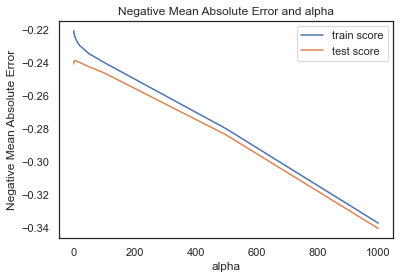

In [95]:
##Plot mean test and train scores with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [97]:
##Finding the best estimator for alpha (lambda parameter)
ridge_model_cv.best_estimator_

Ridge(alpha=4.0)

In [170]:
##Checking the coefficient values with lambda (alpha) = 8

ridge = Ridge(alpha=4.0)

ridge.fit(X_train, y_train)
print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Intercept:  0.12847670918683946
Coefficients:
 [-0.19629019 -1.08781314 -0.93349747 -0.83655578 -1.38929326 -1.72350351
  1.16257422  1.20547302 -0.86575343 -0.67317397  0.95509198  0.59525743
 -0.38025986  0.61997309  0.56219179]


**Model Prediction and Evaluation Metrics:**

In [100]:
##lets predict and evaluate of the model
y_pred_train_r = ridge.predict(X_train)
y_pred_test_r = ridge.predict(X_test)

r2_score_ridge_train = r2_score(y_true= y_train, y_pred= y_pred_train_r)
r2_score_ridge_test = r2_score(y_true= y_test, y_pred= y_pred_test_r)


MSE_ridge_train = mean_squared_error(y_train, y_pred_train_r)
MSE_ridge_test = mean_squared_error(y_test, y_pred_test_r)


MAE_ridge_train = mean_absolute_error(y_train, y_pred_train_r)
MAE_ridge_test = mean_absolute_error(y_test, y_pred_test_r)

RMSE_ridge_train = np.sqrt(MSE_ridge_train)
RMSE_ridge_test = np.sqrt(MSE_ridge_test)


print("For Ridge Regression Model (Original Model, alpha=4.0):\n","*"*40)
print("\nFor Train Set:\nR2 score:",r2_score_ridge_train,"\nMSE score:",MSE_ridge_train,"\nMAE score:",MAE_ridge_train,\
     "\nRMSE score:",RMSE_ridge_train)
print("\nFor Test Set:\nR2 score:",r2_score_ridge_test,"\nMSE score:",MSE_ridge_test,"\nMAE score:",MAE_ridge_test,\
      "\nRMSE score:",RMSE_ridge_test,"\n","*"*40)

For Ridge Regression Model (Original Model, alpha=4.0):
 ****************************************

For Train Set:
R2 score: 0.9048082182782321 
MSE score: 0.09519178172176788 
MAE score: 0.2253836152883687 
RMSE score: 0.3085316543270202

For Test Set:
R2 score: 0.8800912121307629 
MSE score: 0.11812151385446687 
MAE score: 0.2549838609326464 
RMSE score: 0.34368810548878015 
 ****************************************


In [101]:
##Creating a dataframe of features and coefficients

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4), 
                         'Abs_Coefficient_Ridge(Desc_Sort)':abs(ridge.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
ridge_df = ridge_df.sort_values(by='Abs_Coefficient_Ridge(Desc_Sort)', ascending=False)
ridge_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
ridge_df.head(10)  #Top10

Features  Coefficient  Abs_Coefficient_Ridge(Desc_Sort)
0                GrLivArea       0.3681                            0.3681
1   du_Exterior1st_BrkComm      -0.3540                            0.3540
2  du_Neighborhood_MeadowV      -0.2865                            0.2865
3   du_Neighborhood_BrDale      -0.2630                            0.2630
4  du_Neighborhood_Crawfor       0.2554                            0.2554
5            AgeofProperty      -0.2475                            0.2475
6              OverallQual       0.2211                            0.2211
7  du_Neighborhood_StoneBr       0.2164                            0.2164
8   du_Exterior1st_BrkFace       0.1973                            0.1973
9              TotalBsmtSF       0.1819                            0.1819

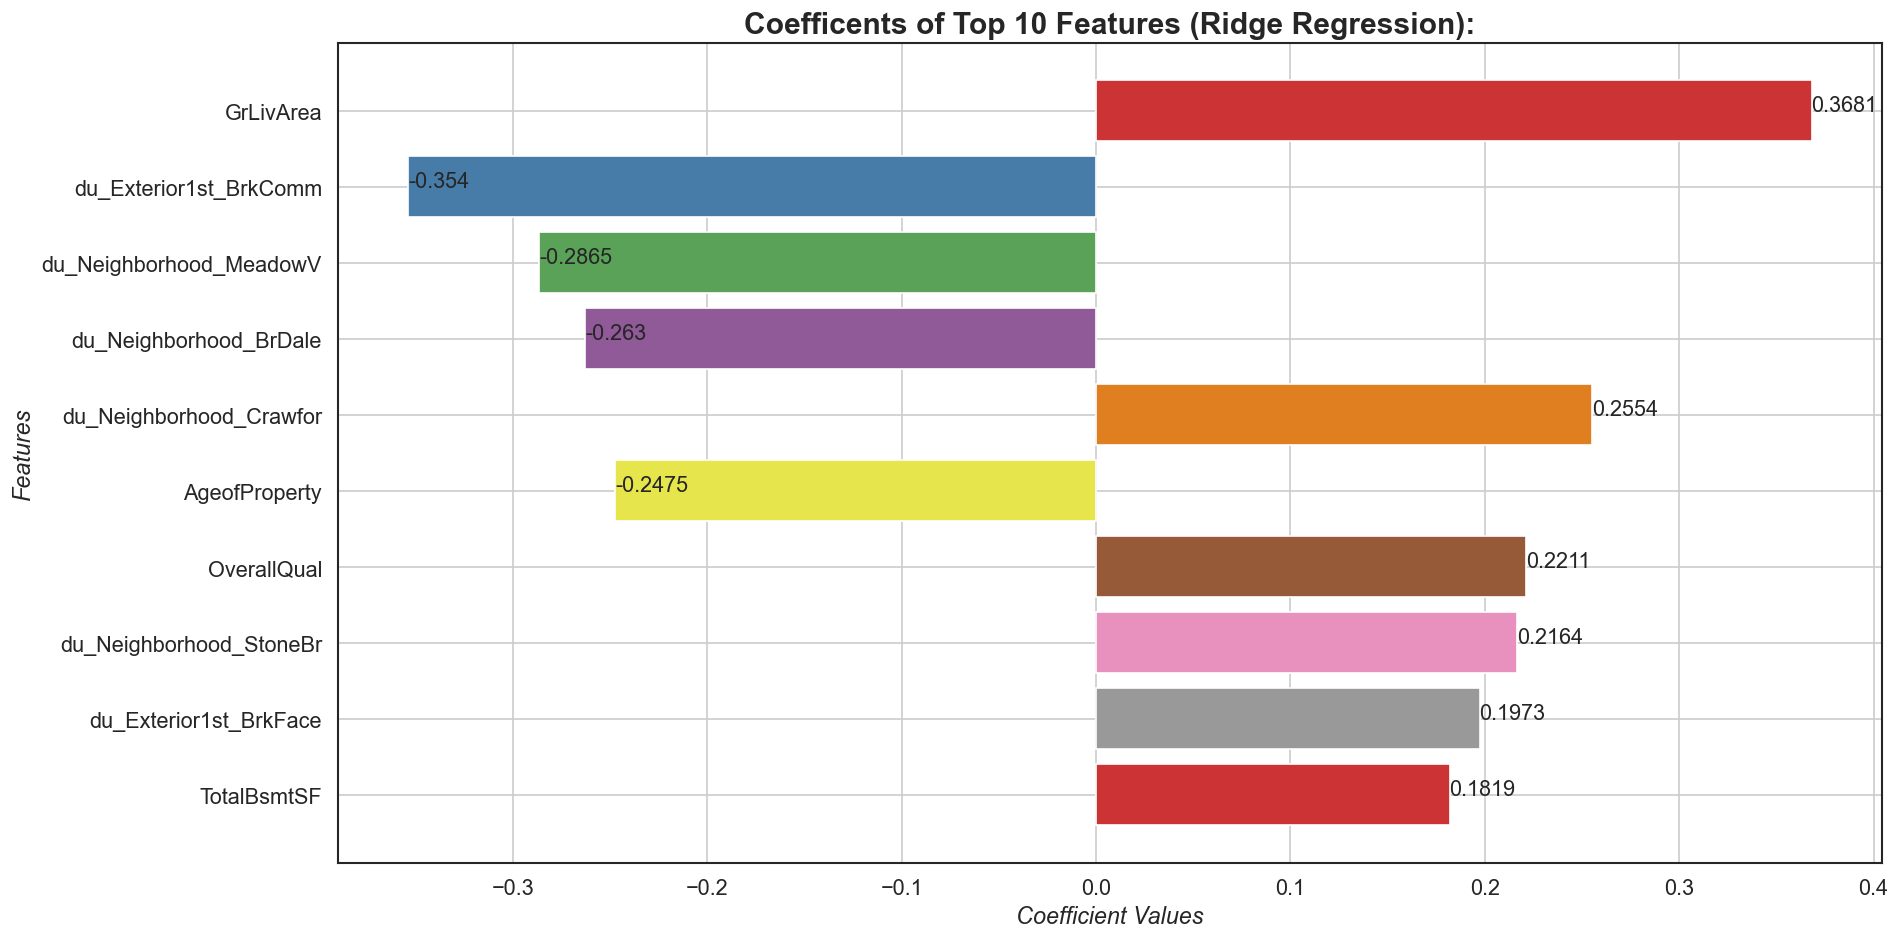

In [102]:
##Coefficient value plot (Ridge Regression)

top10_ridge_df= ridge_df.loc[:9] #Ridge_df with top 10 coefficients

sns.set(style='white')
plt.figure(figsize=(16,8), dpi=120)
ax3= sns.barplot(y=top10_ridge_df['Features'], x=top10_ridge_df['Coefficient'], palette='Set1')

plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
plt.title('Coefficents of Top 10 Features (Ridge Regression):', fontsize=18,fontweight='bold')

coef= top10_ridge_df['Coefficient'] #Storing coefficient values
for index, value in enumerate(coef):
    plt.text(value, index, str(value), fontsize=13)

plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.autoscale()
plt.tight_layout()
plt.show()


The Top 10 predictors based on the Ridge Regression model which will inflence the price the house

**Residual Analysis of Model**

Lets check error term , it should be normal distriution as it is primary requirement for linear regression

**For Train Set:**

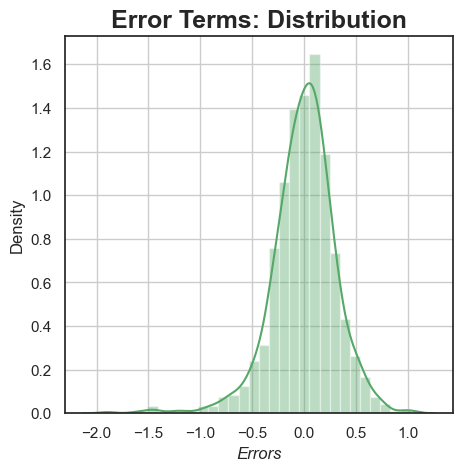

In [103]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res = (y_train - y_pred_train_r)     #residuals
sns.distplot(res , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

As per above fig, it is approx normal distributed with mean 0. So we are good to keep this model as it satisfies the linearlity.

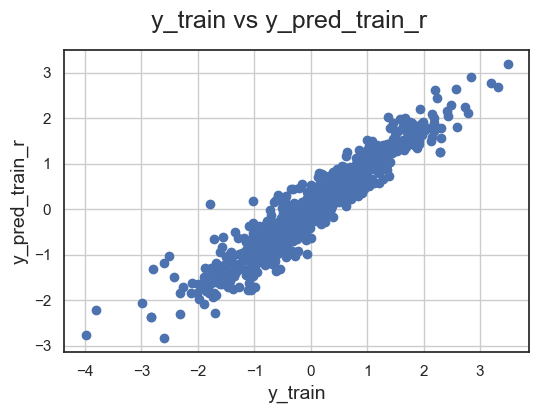

In [105]:
create_scatter_plt_test_pred(y_train,y_pred_train_r,'y_train vs y_pred_train_r','y_train','y_pred_train_r')

In [106]:
count = len(y_train)
print(count)

975


In [107]:
y_train_series = [i for i in range(0,count,1)]
y_pred_train_series =[i for i in range(0,count,1)]

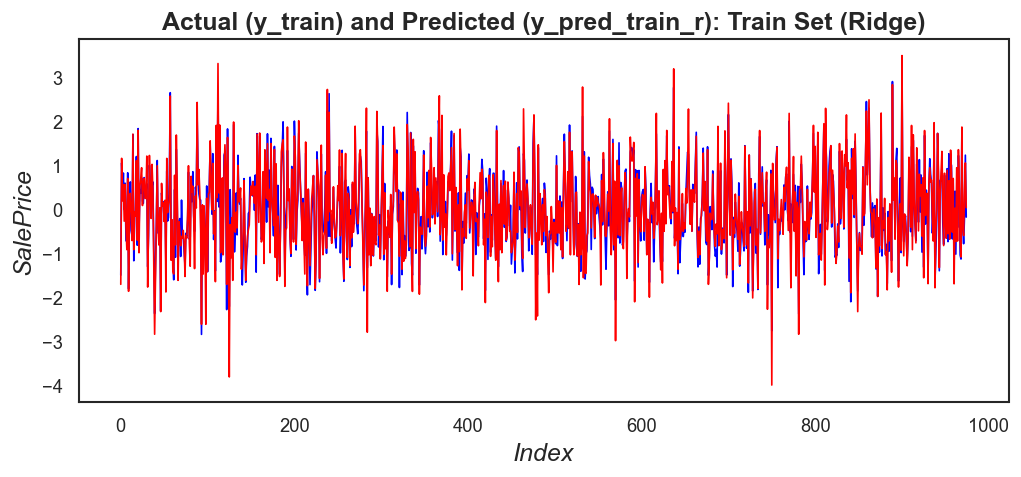

In [108]:
count = len(y_train)
y_train_series = [i for i in range(0,count,1)]
y_pred_train_series =[i for i in range(0,count,1)]
create_plt_act_pred(y_train,y_pred_train_r,y_train_series,y_pred_train_series,'Actual (y_train) and Predicted (y_pred_train_r): Train Set (Ridge)','Index','SalePrice')

<b><font color=Blue>Blue: Predicted (y_pred_train_r)</font></b><b><b>- - - - - - - - - - - - - -</b><font color=Red>  Red: Actual (y_train)</font></b>

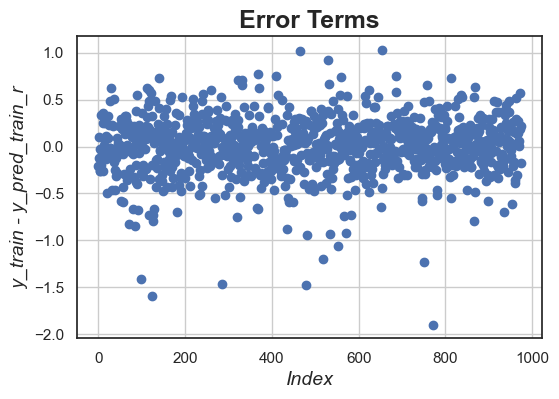

In [109]:
# Error terms for train set
sns.set_style('white')
plt.figure(figsize = (6,4), dpi=100)
j = [i for i in range(0,975,1)] 
res_train = (y_train-y_pred_train_r) #residuals (train set)
plt.scatter(j, res_train)

plt.title('Error Terms', fontsize=18, fontweight='bold')              
plt.xlabel('Index', fontstyle='italic', fontsize=14)                      
plt.ylabel('y_train - y_pred_train_r', fontstyle='italic', fontsize=14)   
plt.grid(True)
plt.show()

The above diagram shows the residuals are scattered around zero , so our assumption hods true

**For Test Set:**

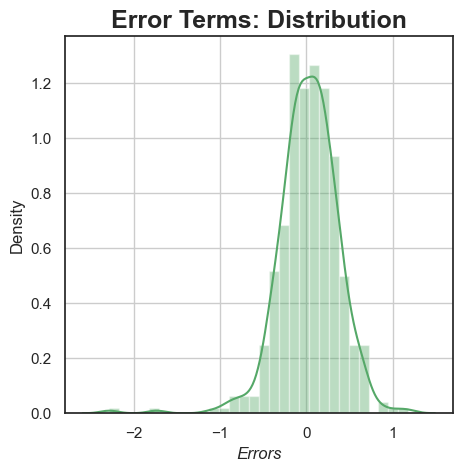

In [110]:
# Plot the histogram of the error terms (test set)
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res = (y_test - y_pred_test_r)     #residuals
sns.distplot(res , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

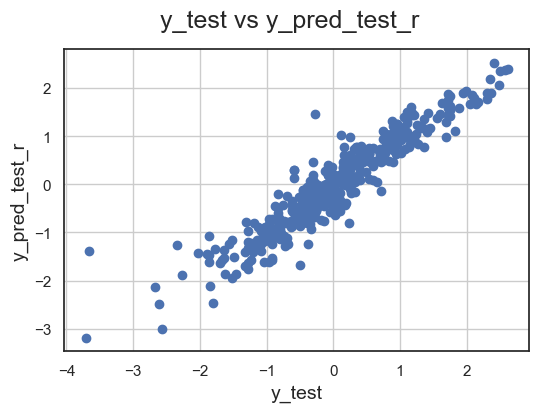

In [111]:
# Plotting y_test and y_pred_test_r to understand the spread.
sns.set_style('white')
fig = plt.figure(figsize=(6,4), dpi=100)
plt.scatter(y_test,y_pred_test_r)
fig.suptitle('y_test vs y_pred_test_r', fontsize=18)             
plt.xlabel('y_test', fontsize=14)                       
plt.ylabel('y_pred_test_r', fontsize=14)  
plt.grid(True)
plt.show()

In [112]:
count= len(y_test)
print(count)

418


In [113]:
y_pred_test_r

array([ 1.47628374e+00,  2.13521574e-01,  1.46618117e-01,  1.29280431e+00,
        1.37121839e+00,  1.16370201e+00,  4.76362491e-01, -7.52962539e-01,
       -1.38441355e+00,  4.97363509e-01, -1.76599417e+00, -9.15999189e-01,
       -1.26328965e-01,  1.91611180e-01,  2.58494965e-02,  9.60201895e-01,
       -1.17943359e+00, -7.67669739e-01,  8.49133272e-01, -1.56374206e+00,
       -7.57982640e-02,  7.56920595e-02,  6.02455175e-01, -1.58047310e+00,
       -2.13408601e+00,  1.90032450e+00, -4.94873184e-01, -8.64484318e-01,
        4.99051367e-02,  1.34949478e+00, -4.48827268e-01, -9.22234609e-01,
       -1.02452269e+00, -9.79203241e-01, -9.71181764e-01,  4.54656253e-01,
       -5.11228772e-01,  2.68380139e-01, -1.65292410e-01,  4.60290562e-01,
       -7.81202506e-01,  6.24183778e-01, -6.65092137e-01,  1.66938657e+00,
        1.86510465e+00,  1.25679052e+00, -4.94873184e-01,  2.94811597e-01,
       -8.78507610e-01,  6.13502929e-01, -5.91839603e-01,  3.54053335e-01,
        1.77700072e+00, -

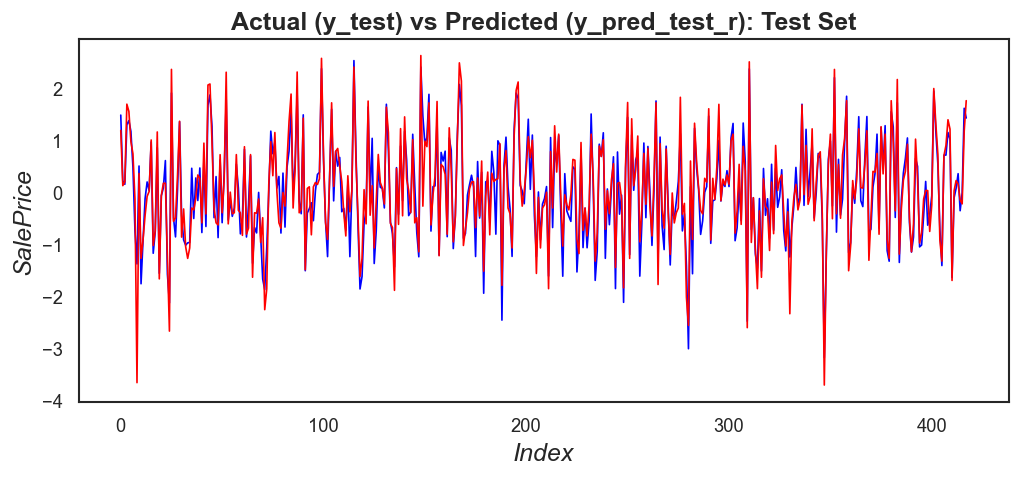

In [114]:
# Actual vs Predicted (Test Set)
plt.figure(figsize = (10,4), dpi=120)
p = [i for i in range(0,418,1)] #As test set has 415 observations
l = [i for i in range(0,418,1)]
plt.plot(p, y_pred_test_r, color="blue", linewidth=1, linestyle="-")   #Predicted 'y_pred_test_r' plot(test pred)
plt.plot(l, y_test, color="red",  linewidth=1, linestyle="-")   #Actual 'y_test' plot
plt.title('Actual (y_test) vs Predicted (y_pred_test_r): Test Set', fontsize=15, fontweight='bold')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.xlabel('Index', fontsize=15, fontstyle='italic')
plt.show()

<b><font color=Blue>Blue: Predicted (y_pred_test_r)</font></b><b><b>- - - - - - - - - - - - - -</b><font color=Red>  Red: Actual (y_test)</font></b>

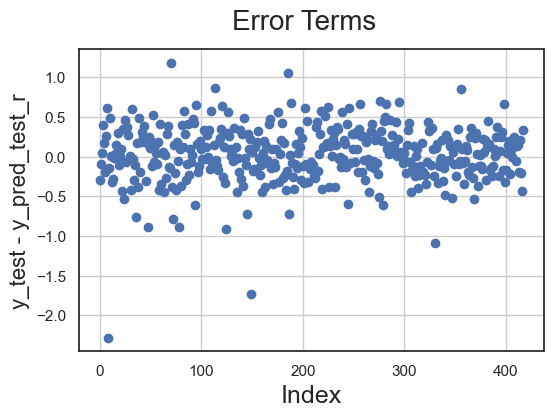

In [115]:
# Error terms
fig = plt.figure(figsize=(6,4), dpi=100)
o = [i for i in range(0,418,1)] #For 415 observations in the test set
res_test = (y_test-y_pred_test_r) #residuals test set
plt.scatter(o,res_test)

fig.suptitle('Error Terms', fontsize=20)              
plt.xlabel('Index', fontsize=18)                     
plt.ylabel('y_test - y_pred_test_r', fontsize=16)    
plt.grid(True)
plt.show()

The residuals are scattered along (y=0) and are independent of each other.

## Lasso Regression:

In [116]:
##Lasso Regression Model. 
lasso = Lasso()

##List of alphas (lambda parameter)

params_1 = {'alpha': [0.00001, 0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007,0.0008, 0.0009, 0.001, 0.002,0.003,0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                      0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

##Cross-Validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params_1, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.0002, 0.0003, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002,
                                   0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [117]:
##Display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
5       0.0006         -0.223059        -0.239797                1
4       0.0005         -0.222590        -0.239799                2
6       0.0007         -0.223547        -0.239825                3
3       0.0003         -0.221665        -0.239910                4
7       0.0008         -0.224061        -0.239993                5
2       0.0002         -0.221223        -0.240030                6
8       0.0009         -0.224527        -0.240130                7
1       0.0001         -0.220788        -0.240242                8
9        0.001         -0.224972        -0.240364                9
0      0.00001         -0.220559        -0.240608               10
10       0.002         -0.229878        -0.242275               11
11       0.003         -0.233240        -0.243001               12
12       0.004         -0.236149        -0.244362               13
13       0.005         -0.239073        -0.246205               14
14        0.01         -0.246361        -0.252455               15
15        0.05         -0.261223        -0.265225               16
16         0.1         -0.291681        -0.295283               17
17         0.2         -0.349607        -0.351777               18
18         0.3         -0.428559        -0.430281               19
19         0.4         -0.508886        -0.510997               20
20         0.5         -0.581122        -0.582353               21
21         0.6         -0.645137        -0.645927               22
22         0.7         -0.708042        -0.708792               23
23         0.8         -0.772365        -0.772957               24
37         100         -0.784926        -0.785211               25
36          50         -0.784926        -0.785211               25
35          20         -0.784926        -0.785211               25
34        10.0         -0.784926        -0.785211               25
33         9.0         -0.784926        -0.785211               25
32         8.0         -0.784926        -0.785211               25
31         7.0         -0.784926        -0.785211               25
29         5.0         -0.784926        -0.785211               25
38         500         -0.784926        -0.785211               25
28         4.0         -0.784926        -0.785211               25
27         3.0         -0.784926        -0.785211               25
26         2.0         -0.784926        -0.785211               25
25         1.0         -0.784926        -0.785211               25
24         0.9         -0.784926        -0.785211               25
30         6.0         -0.784926        -0.785211               25
39        1000         -0.784926        -0.785211               25

In [118]:
##Plotting a magnified graph for a lower range of alpha.

lasso = Lasso()

##List of alphas (lambda parameter: consider smaller range on the basis of lasso_cv_results table ranking)

params_2 = {'alpha': [0.00001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001,0.002,0.003, 0.005, 0.01, 0.02, 0.05]}

##Cross-Validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params_2, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 17 candidates, totalling 85 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.0002, 0.0003, 0.0004,
                                   0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
                                   0.001, 0.002, 0.003, 0.005, 0.01, 0.02,
                                   0.05]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [119]:
##ReDisplay the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
6       0.0006         -0.223059        -0.239797                1
5       0.0005         -0.222590        -0.239799                2
4       0.0004         -0.222124        -0.239820                3
7       0.0007         -0.223547        -0.239825                4
3       0.0003         -0.221665        -0.239910                5
8       0.0008         -0.224061        -0.239993                6
2       0.0002         -0.221223        -0.240030                7
9       0.0009         -0.224527        -0.240130                8
1       0.0001         -0.220788        -0.240242                9
10       0.001         -0.224972        -0.240364               10
0      0.00001         -0.220559        -0.240608               11
11       0.002         -0.229878        -0.242275               12
12       0.003         -0.233240        -0.243001               13
13       0.005         -0.239073        -0.246205               14
14        0.01         -0.246361        -0.252455               15
15        0.02         -0.250757        -0.255621               16
16        0.05         -0.261223        -0.265225               17

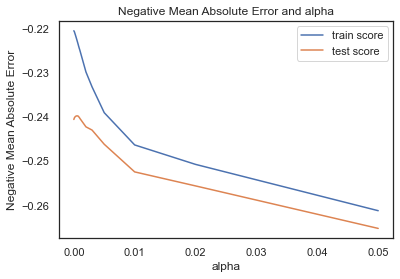

In [120]:
##Plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

##plotting
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [121]:
# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0006)

In [122]:
# check the coefficient values with lambda = 0.006

lasso = Lasso(alpha=0.006)
        
lasso.fit(X_train, y_train) 
print("Intercept: ",lasso.intercept_)
print("Coefficients:\n ",lasso.coef_)

Intercept:  -0.14895166666271625
Coefficients:
  [ 0.27520321  0.17424987  0.18837596  0.3664643   0.13012903 -0.28003936
  0.00123118  0.13173145 -0.         -0.          0.18576973 -0.
 -0.         -0.         -0.         -0.         -0.         -0.00694232
  0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.03050991 -0.         -0.00770291  0.0162174
 -0.01333852  0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.05375038  0.
 -0.         -0.          0.01406944 -0.          0.          0.
  0.          0.07302261]


In [123]:
##Making predictions for train and test sets: Lasso Regression Model
y_pred_train_l = lasso.predict(X_train)
y_pred_test_l = lasso.predict(X_test)

##R2 score for Lasso Regression Model
r2_score_lasso_train = r2_score(y_true= y_train, y_pred= y_pred_train_l)
r2_score_lasso_test = r2_score(y_true= y_test, y_pred= y_pred_test_l)

##Check the mean squared error (MSE) for Lasso Regression Model
MSE_lasso_train = mean_squared_error(y_train, y_pred_train_l)
MSE_lasso_test = mean_squared_error(y_test, y_pred_test_l)

##Mean Absolute error for train and test sets
MAE_lasso_train = mean_absolute_error(y_train, y_pred_train_l)
MAE_lasso_test = mean_absolute_error(y_test, y_pred_test_l)

##Root Mean Squared Error for Train and Test Sets
RMSE_lasso_train = np.sqrt(MSE_lasso_train)
RMSE_lasso_test = np.sqrt(MSE_lasso_test)

print("For Lasso Regression Model (Original Model: alpha=0.006):\n","*"*40)
print("\nFor Train Set:\nR2 score:",r2_score_lasso_train,"\nMSE score:",MSE_lasso_train,"\nMAE score:",MAE_lasso_train,\
     "\nRMSE score:",RMSE_lasso_train)
print("\nFor Test Set:\nR2 score:",r2_score_lasso_test,"\nMSE score:",MSE_lasso_test,"\nMAE score:",MAE_lasso_test,\
      "\nRMSE score:",RMSE_lasso_test,"\n","*"*40)


For Lasso Regression Model (Original Model: alpha=0.006):
 ****************************************

For Train Set:
R2 score: 0.8878591100751259 
MSE score: 0.1121408899248741 
MAE score: 0.2420133854720729 
RMSE score: 0.33487443904376174

For Test Set:
R2 score: 0.8734856416234527 
MSE score: 0.12462862648616828 
MAE score: 0.26439066011547274 
RMSE score: 0.35302779846092613 
 ****************************************


As the training set and test set R2 score is almost same, our assumption holds true

In [124]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), \
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})
##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#lasso df
lasso_df.head(10)  #Top10 features display

Features  Coefficient  Abs_Coefficient_Lasso(Desc_Sort)
0                GrLivArea       0.3665                            0.3665
1            AgeofProperty      -0.2800                            0.2800
2              OverallQual       0.2752                            0.2752
3              TotalBsmtSF       0.1884                            0.1884
4  du_Neighborhood_Crawfor       0.1858                            0.1858
5              OverallCond       0.1742                            0.1742
6           du_MSZoning_RL       0.1317                            0.1317
7               GarageArea       0.1301                            0.1301
8      du_MasVnrType_Stone       0.0730                            0.0730
9     du_GarageType_Attchd       0.0538                            0.0538

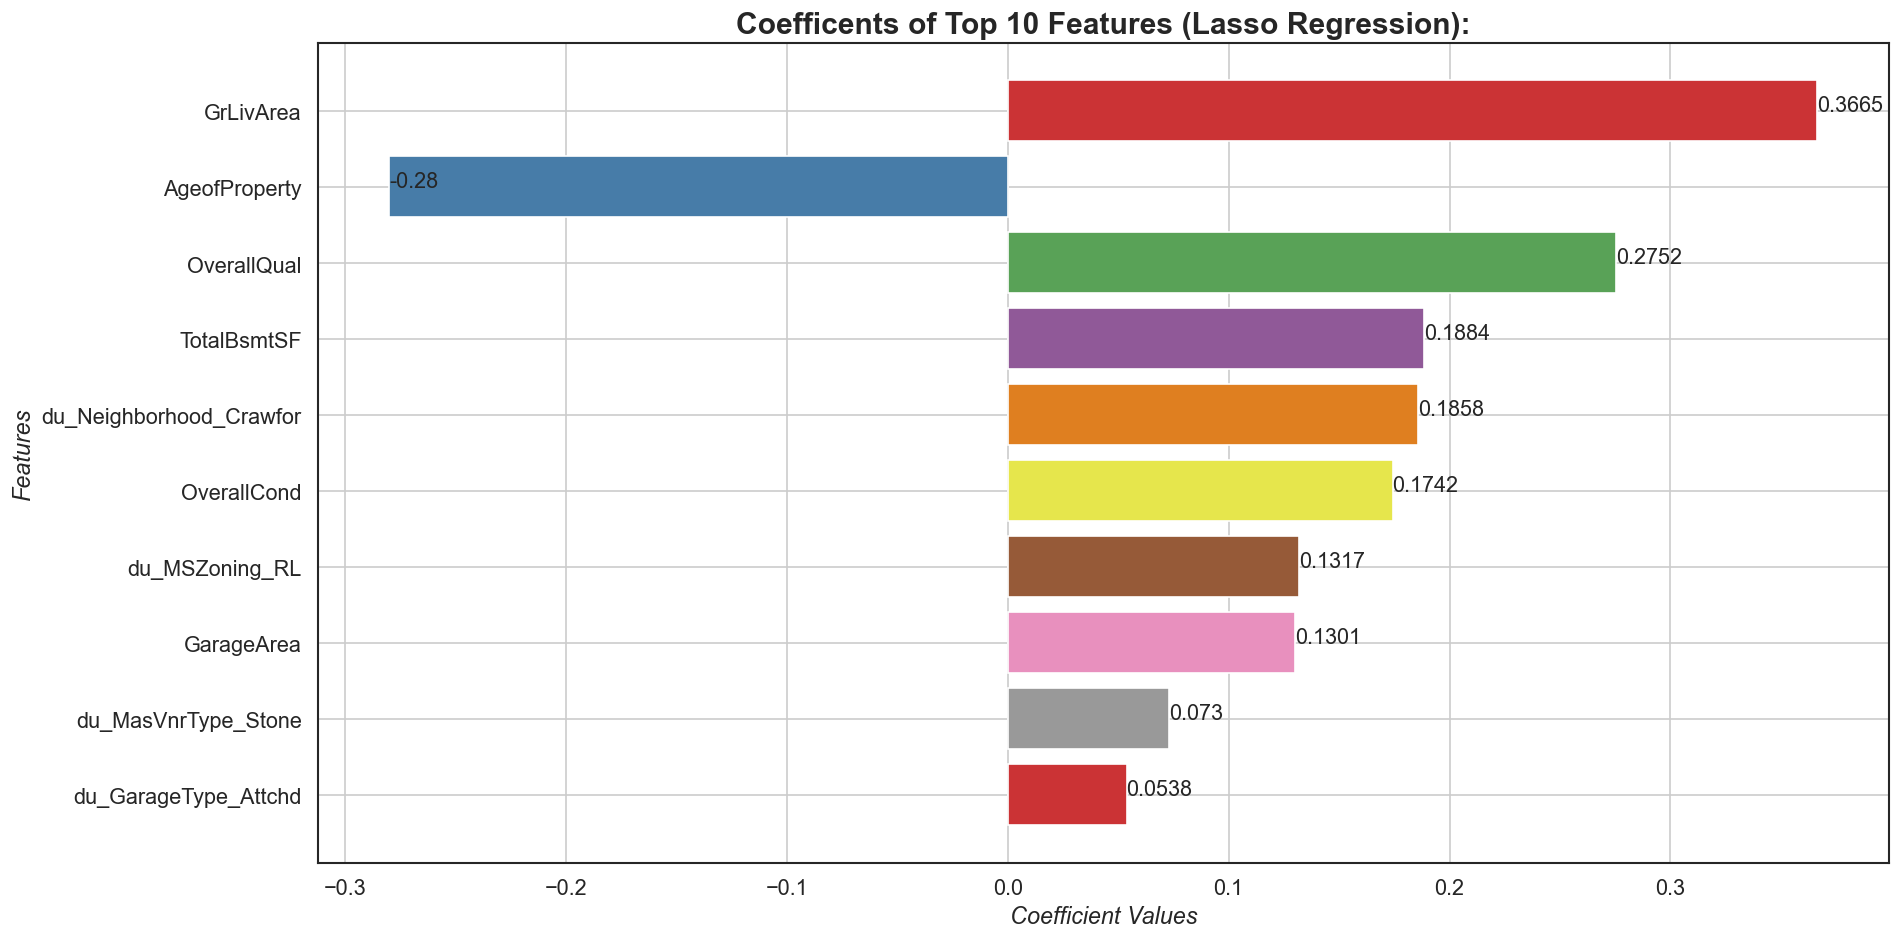

In [125]:
##Coefficient value plot (Lasso Regression)

top10_lasso_df= lasso_df.loc[:9] #Lasso_df with top 10 coefficients

sns.set(style='white')
plt.figure(figsize=(16,8), dpi=120)
ax4= sns.barplot(y=top10_lasso_df['Features'], x=top10_lasso_df['Coefficient'], palette='Set1')

plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
plt.title('Coefficents of Top 10 Features (Lasso Regression):', fontsize=18,fontweight='bold')

c= top10_lasso_df['Coefficient'] #Storing coefficient values
for index, value in enumerate(c):
    plt.text(value, index, str(value), fontsize=13)

plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.autoscale()
plt.tight_layout()
plt.show()


The above figure shows top10 features using lasso algorithm. Lets store top 5 values as it requires subjective question

In [126]:

top5_original_lasso_features = list(top10_lasso_df['Features'].iloc[0:5])
top5_original_lasso_features

['GrLivArea',
 'AgeofProperty',
 'OverallQual',
 'TotalBsmtSF',
 'du_Neighborhood_Crawfor']

**Residual Analysis of Model**

Checking for the error terms distribution. 

**For Train Set:**

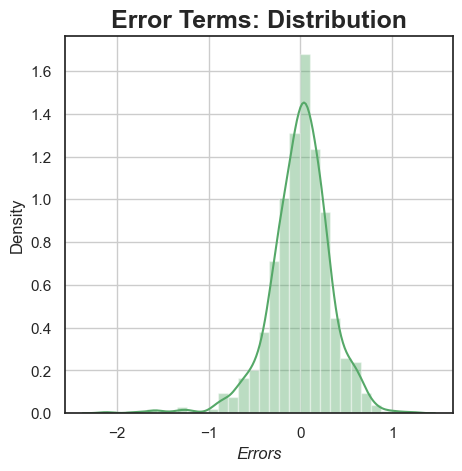

In [127]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res1 = (y_train - y_pred_train_l)     #residuals
sns.distplot(res1 , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

It  normally distributed with mean 0, so our assumption holds true.

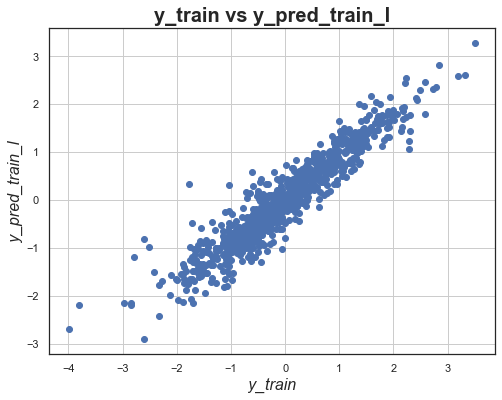

In [128]:
# Plotting y_train and y_train_pred to understand the residuals.
sns.set_style('white')
plt.figure(figsize = (8,6))
plt.scatter(y_train,y_pred_train_l)
plt.title('y_train vs y_pred_train_l', fontweight='bold', fontsize = 20)           
plt.xlabel('y_train', fontstyle='italic', fontsize = 16)              
plt.ylabel('y_pred_train_l', fontstyle='italic', fontsize = 16) 
plt.grid(True)
plt.show()

In [129]:
y_train.shape

(975,)

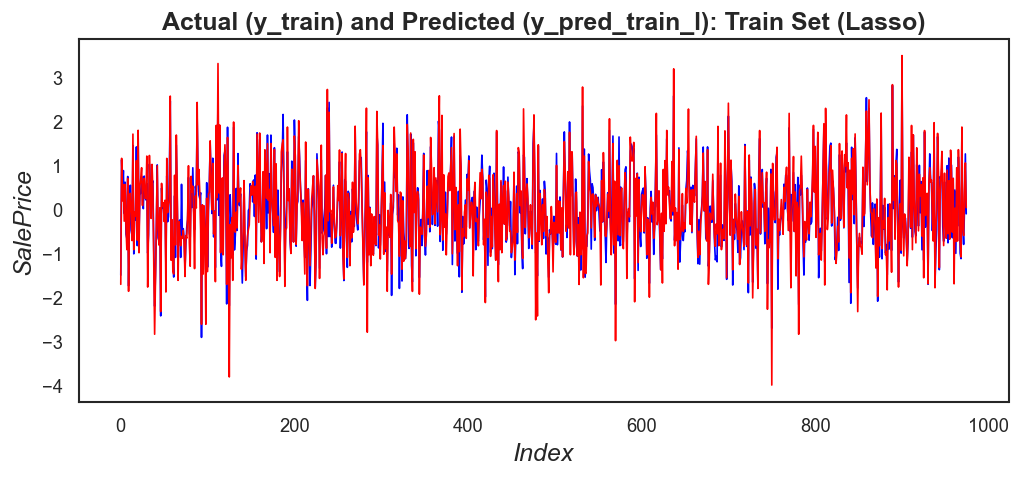

In [130]:
# Actual and Predicted (Train Set)
sns.set_style('white')
plt.figure(figsize = (10,4), dpi=120)
f1 = [i for i in range(0,975,1)] #Since y_train has 966 observations
g1 = [i for i in range(0,975,1)]
plt.plot(f1, y_pred_train_l, color="blue", linewidth=1, linestyle="-")     #Predicted 'y_pred_train_l' plot
plt.plot(g1, y_train, color="red",  linewidth=1, linestyle="-")  #Actual 'y_train' plot
plt.title("Actual (y_train) and Predicted (y_pred_train_l): Train Set (Lasso)", fontsize=15, fontweight='bold')    
plt.xlabel('Index', fontsize=15, fontstyle='italic')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.show()

<b><font color=Blue>Blue: Predicted (y_pred_train_l)</font></b><b><b>- - - - - - - - - - - - - -</b><font color=Red>  Red: Actual (y_train)</font></b>

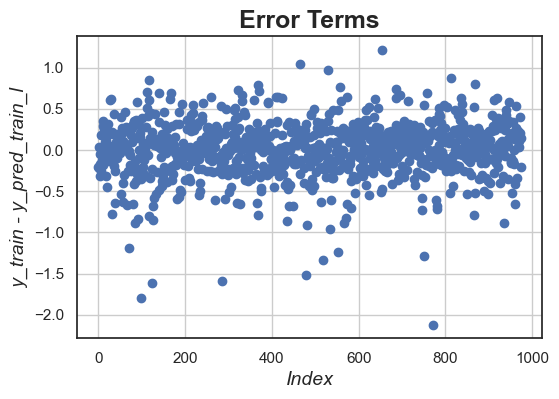

In [131]:
# Error terms for train set
sns.set_style('white')
plt.figure(figsize = (6,4), dpi=100)
j1 = [i for i in range(0,975,1)] 
res_train1 = (y_train-y_pred_train_l)
plt.scatter(j1, res_train1)

plt.title('Error Terms', fontsize=18, fontweight='bold')              
plt.xlabel('Index', fontstyle='italic', fontsize=14)                      
plt.ylabel('y_train - y_pred_train_l', fontstyle='italic', fontsize=14)   
plt.grid(True)
plt.show()

The residuals are scattered along (y=0) and are independent of each other.

**For Test Set:**

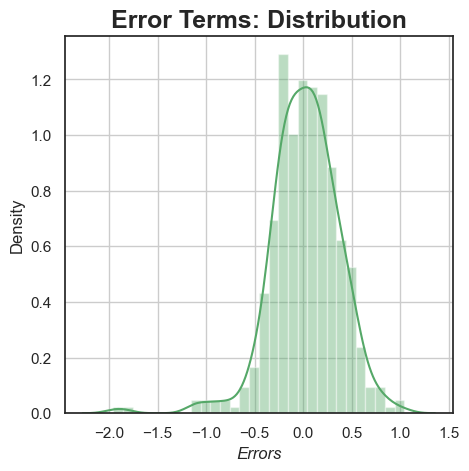

In [132]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res1 = (y_test - y_pred_test_l)     #residuals
sns.distplot(res1 , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

Error terms seem to be approximately normally distributed with mean 0.

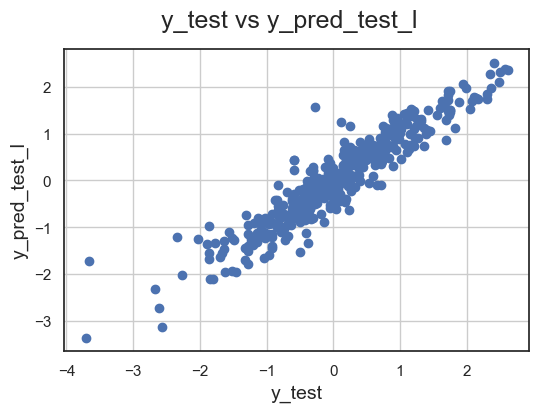

In [133]:
# Plotting y_test and y_pred_test_l to understand the spread.
sns.set_style('white')
fig = plt.figure(figsize=(6,4), dpi=100)
plt.scatter(y_test,y_pred_test_l)
fig.suptitle('y_test vs y_pred_test_l', fontsize=18)             
plt.xlabel('y_test', fontsize=14)                       
plt.ylabel('y_pred_test_l', fontsize=14)  
plt.grid(True)
plt.show()

In [134]:
y_test.shape

(418,)

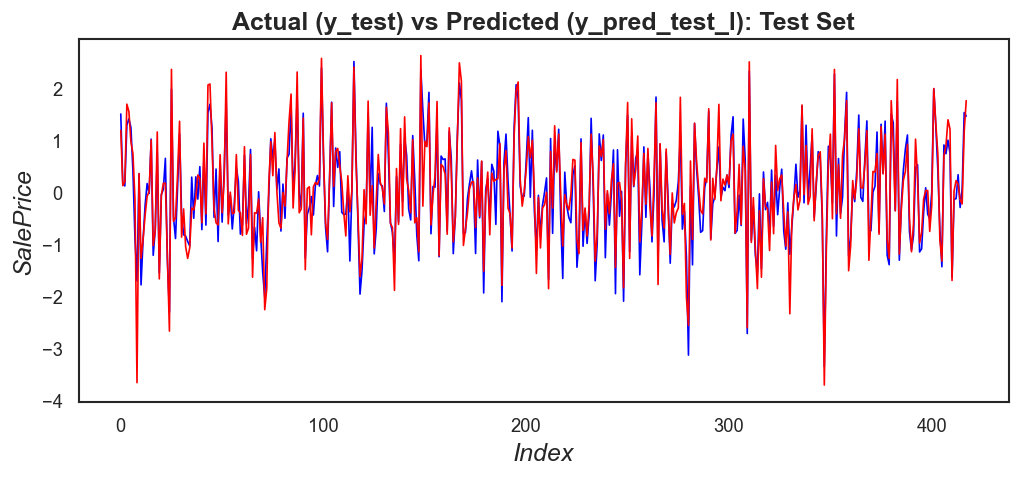

In [135]:
# Actual vs Predicted (Test Set)
plt.figure(figsize = (10,4), dpi=120)
p2 = [i for i in range(0,418,1)] #As test set has 415 observations
l2 = [i for i in range(0,418,1)]
plt.plot(p2, y_pred_test_l, color="blue", linewidth=1, linestyle="-")   #Predicted 'y_pred_test_l' plot(test pred)
plt.plot(l2, y_test, color="red",  linewidth=1, linestyle="-")   #Actual 'y_test' plot
plt.title('Actual (y_test) vs Predicted (y_pred_test_l): Test Set', fontsize=15, fontweight='bold')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.xlabel('Index', fontsize=15, fontstyle='italic')
plt.show()

<b><font color=Blue>Blue: Predicted (y_pred_test_l)</font></b><b><b>- - - - - - - - - - - - - -</b><font color=Red>  Red: Actual (y_test)</font></b>

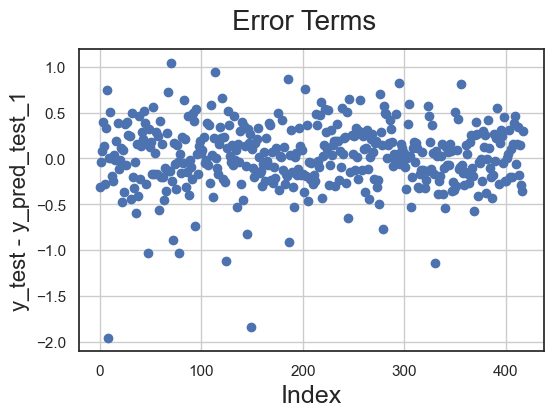

In [136]:
# Error terms
fig = plt.figure(figsize=(6,4), dpi=100)
o1 = [i for i in range(0,418,1)] #For 415 observations in the test set
res_test1 = (y_test-y_pred_test_l) #residuals test set
plt.scatter(o1,res_test1)

fig.suptitle('Error Terms', fontsize=20)              
plt.xlabel('Index', fontsize=18)                     
plt.ylabel('y_test - y_pred_test_1', fontsize=16)    
plt.grid(True)
plt.show()

The residuals are scattered along (y=0) and are independent of each other.

# <font color = 'Green'>Subjective Questions:

**<font color = 'Brown'>Question 1**

`What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?`

In [590]:


optimal_alpha_ridge = 4.0       
optimal_alpha_lasso = 0.006   

*`Changes to the model when we double the value of alpha for both ridge and lasso regression`*

**Ridge Regression**

In [137]:
##Checking the outcome: coefficient values with double the value of alpha = 8*2 = 16

ridge = Ridge(alpha=8.0)

ridge.fit(X_train, y_train)
print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Intercept:  -0.2258330097152521
Coefficients:
 [ 0.2295351   0.17651258  0.18386675  0.36637628  0.12121334 -0.24828328
  0.15877587  0.16525868 -0.06026601 -0.20226887  0.23678301 -0.07130912
 -0.12961878 -0.20306801 -0.0765367  -0.11272178 -0.04706075 -0.14963093
  0.10187346 -0.0978615  -0.10201242  0.17720319  0.10130745  0.11166032
  0.0293422  -0.19947975  0.1606665   0.00923198 -0.00363998  0.08049323
 -0.04655492  0.02451216  0.0889672   0.01915777  0.03736405  0.08005447
  0.09932276 -0.07603627  0.04937745 -0.06888772  0.12445891  0.11049532
 -0.10844612 -0.06790308  0.10321021 -0.03944451 -0.00714823  0.07551429
  0.04952172  0.13256778]


making predictions for train and test sets: Ridge Regression Model

In [171]:

y_pred_train_r = ridge.predict(X_train)
y_pred_test_r = ridge.predict(X_test)

r2_score_ridge_train = r2_score(y_true= y_train, y_pred= y_pred_train_r)
r2_score_ridge_test = r2_score(y_true= y_test, y_pred= y_pred_test_r)

MSE_ridge_train = mean_squared_error(y_train, y_pred_train_r)
MSE_ridge_test = mean_squared_error(y_test, y_pred_test_r)

MAE_ridge_train = mean_absolute_error(y_train, y_pred_train_r)
MAE_ridge_test = mean_absolute_error(y_test, y_pred_test_r)

RMSE_ridge_train = np.sqrt(MSE_ridge_train)
RMSE_ridge_test = np.sqrt(MSE_ridge_test)


print("For Ridge Regression Model (Doubled alpha model, alpha=4*2=8):\n","*"*40)
print("\nFor Train Set:\nR2 score:",r2_score_ridge_train,"\nMSE score:",MSE_ridge_train,"\nMAE score:",MAE_ridge_train,\
     "\nRMSE score:",RMSE_ridge_train)
print("\nFor Test Set:\nR2 score:",r2_score_ridge_test,"\nMSE score:",MSE_ridge_test,"\nMAE score:",MAE_ridge_test,\
      "\nRMSE score:",RMSE_ridge_test,"\n","*"*40)

For Ridge Regression Model (Doubled alpha model, alpha=4*2=8):
 ****************************************

For Train Set:
R2 score: 0.4739014210607869 
MSE score: 0.5260985789392129 
MAE score: 0.5588352308469113 
RMSE score: 0.7253265326314852

For Test Set:
R2 score: 0.47108222692302015 
MSE score: 0.5210341057614408 
MAE score: 0.5563876349510999 
RMSE score: 0.7218269223030136 
 ****************************************


In [139]:
##Creating a dataframe of features and coefficients

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4), 
                         'Abs_Coefficient_Ridge(Desc_Sort)':abs(ridge.coef_.round(4))})

##Sorting coefficient in descending order of absolute values and reset index
ridge_df = ridge_df.sort_values(by='Abs_Coefficient_Ridge(Desc_Sort)', ascending=False)
ridge_df.reset_index(drop=True, inplace=True)  

#Dataframe rdige_df
ridge_df.head(10)    #Top10 features display

Features  Coefficient  Abs_Coefficient_Ridge(Desc_Sort)
0                GrLivArea       0.3664                            0.3664
1            AgeofProperty      -0.2483                            0.2483
2  du_Neighborhood_Crawfor       0.2368                            0.2368
3              OverallQual       0.2295                            0.2295
4  du_Neighborhood_MeadowV      -0.2031                            0.2031
5   du_Neighborhood_BrDale      -0.2023                            0.2023
6   du_Exterior1st_BrkComm      -0.1995                            0.1995
7              TotalBsmtSF       0.1839                            0.1839
8  du_Neighborhood_StoneBr       0.1772                            0.1772
9              OverallCond       0.1765                            0.1765

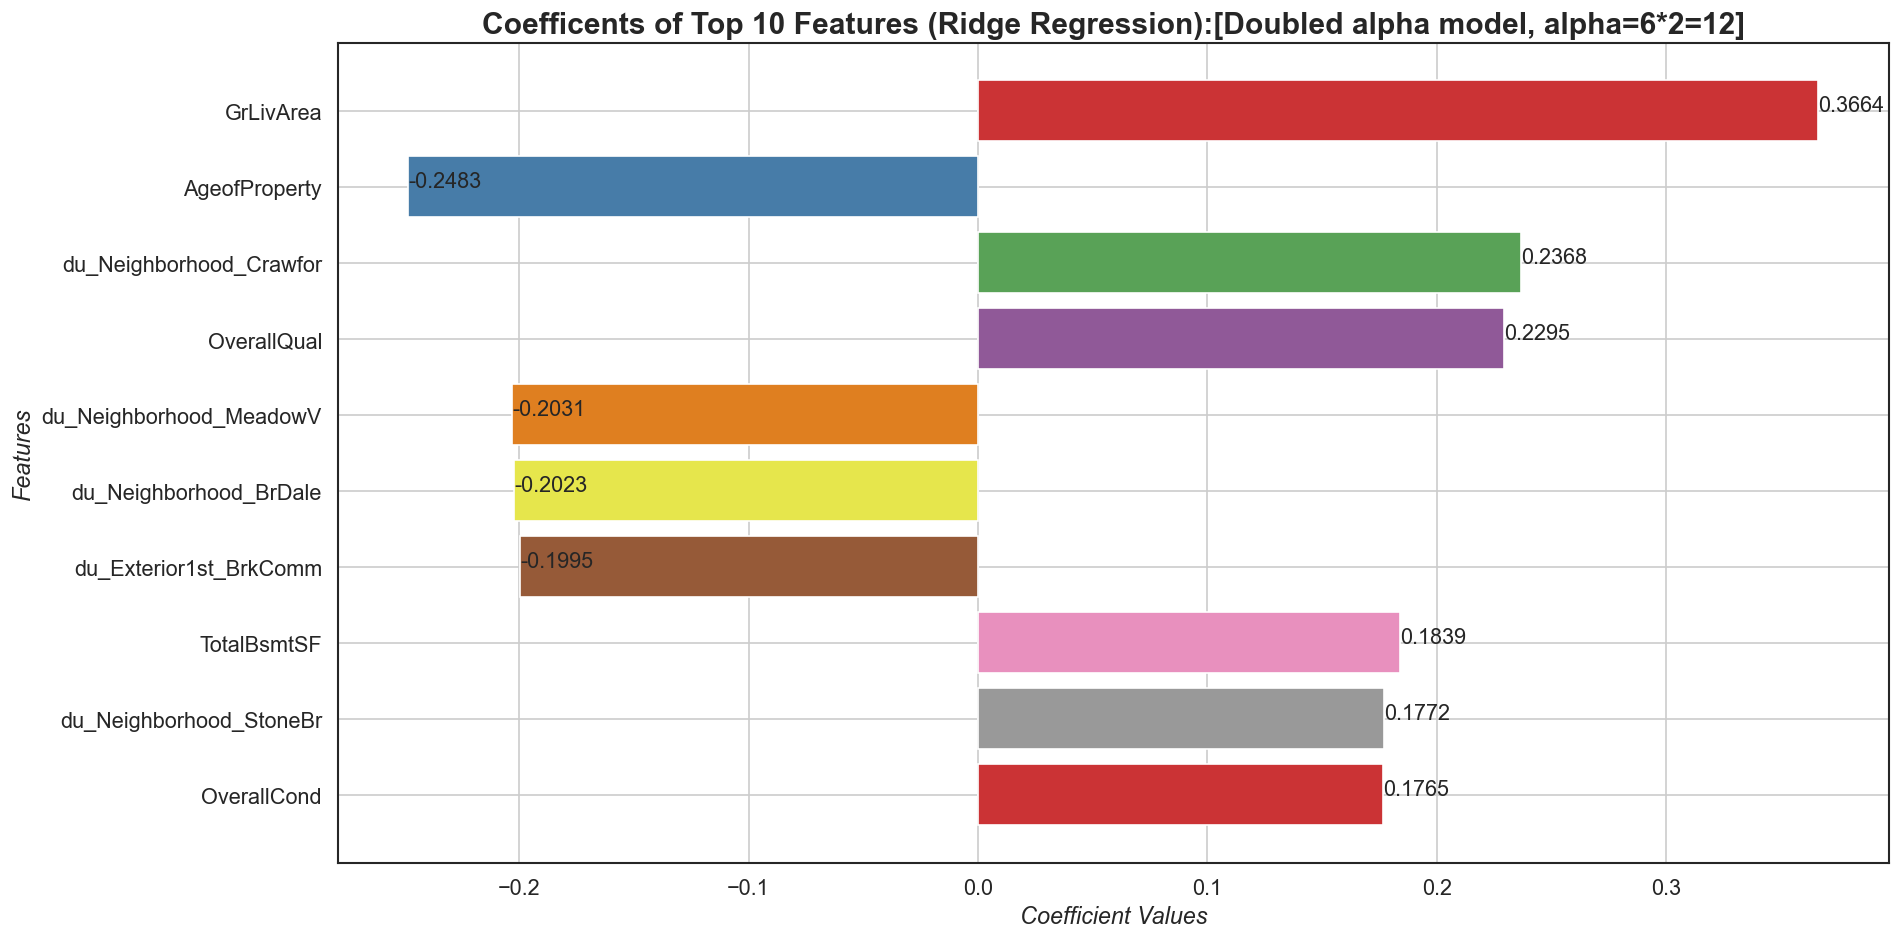

In [140]:
##Coefficient value plot (Ridge Regression)

top10_ridge_df= ridge_df.loc[:9] #Ridge_df with top 10 coefficients

sns.set(style='white')
plt.figure(figsize=(16,8), dpi=120)
ax3= sns.barplot(y=top10_ridge_df['Features'], x=top10_ridge_df['Coefficient'], palette='Set1')

plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
plt.title('Coefficents of Top 10 Features (Ridge Regression):[Doubled alpha model, alpha=6*2=12]', fontsize=18,fontweight='bold')

coef= top10_ridge_df['Coefficient'] #Storing coefficient values
for index, value in enumerate(coef):
    plt.text(value, index, str(value), fontsize=13)

plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.autoscale()
plt.tight_layout()
plt.show()

In [142]:
print("For Ridge Regression (Doubled alpha model, alpha=4*2=8): \n","*"*114)
print("The most important top10 predictor variables after the change is implemented are as follows:\n\n",\
      list(top10_ridge_df['Features']),"\n", "*"*114)

For Ridge Regression (Doubled alpha model, alpha=4*2=8): 
 ******************************************************************************************************************
The most important top10 predictor variables after the change is implemented are as follows:

 ['GrLivArea', 'AgeofProperty', 'du_Neighborhood_Crawfor', 'OverallQual', 'du_Neighborhood_MeadowV', 'du_Neighborhood_BrDale', 'du_Exterior1st_BrkComm', 'TotalBsmtSF', 'du_Neighborhood_StoneBr', 'OverallCond'] 
 ******************************************************************************************************************


**Lasso Regression**

In [143]:
##Lets double alpha for lasso algorithm = 0.006*2 = 0.012 

lasso = Lasso(alpha=0.012)
        
lasso.fit(X_train, y_train) 
print("Intercept: ", lasso.intercept_)
print("Coefficients:\n ", lasso.coef_)

Intercept:  -0.10140205374917127
Coefficients:
  [ 0.2859204   0.16832665  0.19531545  0.36141861  0.12930628 -0.27157145
  0.          0.10733694 -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.02980148  0.
 -0.         -0.          0.         -0.          0.          0.
  0.          0.        ]


##making prediction for Lasso Regression Model

In [144]:

y_pred_train_l = lasso.predict(X_train)
y_pred_test_l = lasso.predict(X_test)

r2_score_lasso_train = r2_score(y_true= y_train, y_pred= y_pred_train_l)
r2_score_lasso_test = r2_score(y_true= y_test, y_pred= y_pred_test_l)

MSE_lasso_train = mean_squared_error(y_train, y_pred_train_l)
MSE_lasso_test = mean_squared_error(y_test, y_pred_test_l)


MAE_lasso_train = mean_absolute_error(y_train, y_pred_train_l)
MAE_lasso_test = mean_absolute_error(y_test, y_pred_test_l)

RMSE_lasso_train = np.sqrt(MSE_lasso_train)
RMSE_lasso_test = np.sqrt(MSE_lasso_test)

print("For Lasso Regression Model: (Doubled alpha model: alpha:0.006*2 = 0.012)\n","*"*100)
print("\nFor Train Set:\nR2 score:",r2_score_lasso_train,"\nMSE score:",MSE_lasso_train,"\nMAE score:",MAE_lasso_train,\
     "\nRMSE score:",RMSE_lasso_train)
print("\nFor Test Set:\nR2 score:",r2_score_lasso_test,"\nMSE score:",MSE_lasso_test,"\nMAE score:",MAE_lasso_test,\
      "\nRMSE score:",RMSE_lasso_test,"\n","*"*100)

For Lasso Regression Model: (Doubled alpha model: alpha:0.006*2 = 0.012)
 ****************************************************************************************************

For Train Set:
R2 score: 0.881192627883006 
MSE score: 0.11880737211699395 
MAE score: 0.24918796060951431 
RMSE score: 0.3446844529667591

For Test Set:
R2 score: 0.86764412668961 
MSE score: 0.13038307200638682 
MAE score: 0.2673679510069974 
RMSE score: 0.36108596207328086 
 ****************************************************************************************************


In [145]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), \
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})
##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#lasso df
lasso_df.head(10)   #Top10 features display

Features  Coefficient  Abs_Coefficient_Lasso(Desc_Sort)
0               GrLivArea       0.3614                            0.3614
1             OverallQual       0.2859                            0.2859
2           AgeofProperty      -0.2716                            0.2716
3             TotalBsmtSF       0.1953                            0.1953
4             OverallCond       0.1683                            0.1683
5              GarageArea       0.1293                            0.1293
6          du_MSZoning_RL       0.1073                            0.1073
7    du_GarageType_Attchd       0.0298                            0.0298
8  du_Exterior1st_Plywood      -0.0000                            0.0000
9     du_Foundation_Stone       0.0000                            0.0000

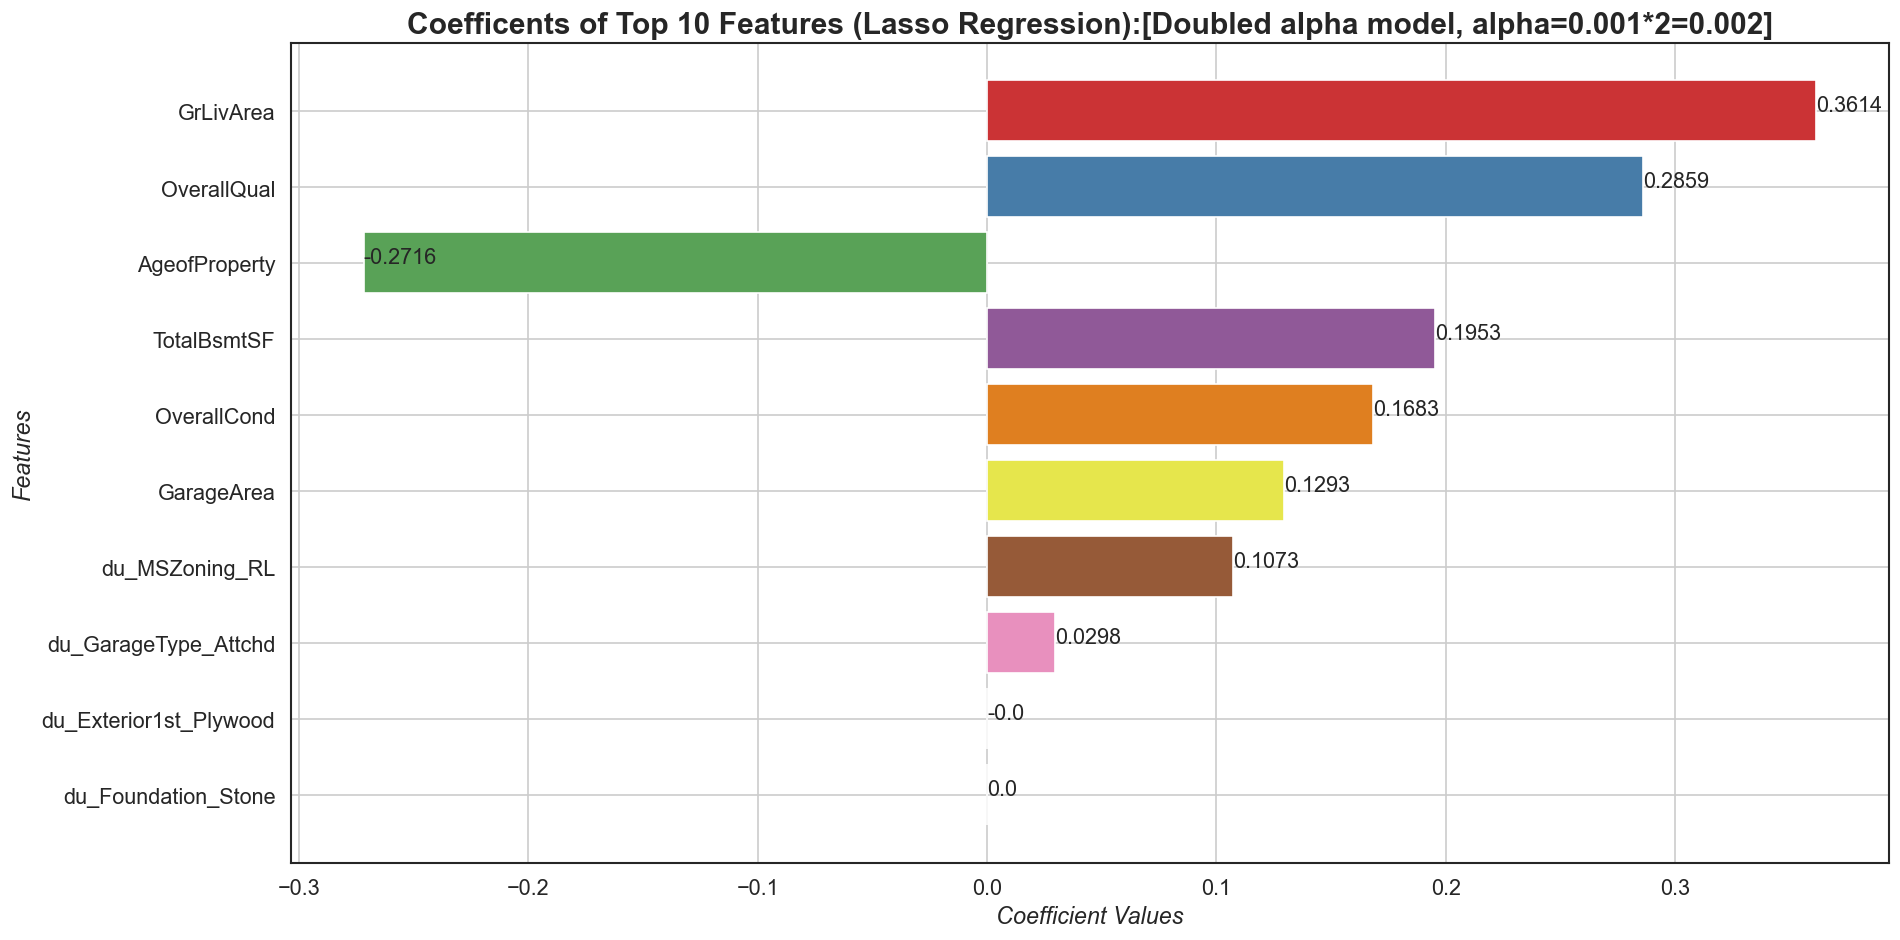

In [146]:
##Coefficient value plot (Lasso Regression)

top10_lasso_df= lasso_df.loc[:9] #Lasso_df with top 10 coefficients

sns.set(style='white')
plt.figure(figsize=(16,8), dpi=120)
ax4= sns.barplot(y=top10_lasso_df['Features'], x=top10_lasso_df['Coefficient'], palette='Set1')

plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
plt.title('Coefficents of Top 10 Features (Lasso Regression):[Doubled alpha model, alpha=0.001*2=0.002]', fontsize=18,fontweight='bold')

c= top10_lasso_df['Coefficient'] #Storing coefficient values
for index, value in enumerate(c):
    plt.text(value, index, str(value), fontsize=13)

plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.autoscale()
plt.tight_layout()
plt.show()


In [147]:
print("For Lasso Regression (Doubled alpha model: alpha:0.006*2 = 0.012): \n","*"*114)
print("The most important top10 predictor variables after the change is implemented are as follows:\n\n",\
      list(top10_lasso_df['Features']),"\n", "*"*114)

For Lasso Regression (Doubled alpha model: alpha:0.006*2 = 0.012): 
 ******************************************************************************************************************
The most important top10 predictor variables after the change is implemented are as follows:

 ['GrLivArea', 'OverallQual', 'AgeofProperty', 'TotalBsmtSF', 'OverallCond', 'GarageArea', 'du_MSZoning_RL', 'du_GarageType_Attchd', 'du_Exterior1st_Plywood', 'du_Foundation_Stone'] 
 ******************************************************************************************************************


**<font color = 'Brown'>Question 2**

`You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?`

**(Solution in Subjective Questions pdf File)**

**<font color = 'Brown'>Question 3**

`After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?`

In [148]:
##from Original Lasso Regression Model, import 'top5_original_lasso_features': Top5 features
print("Top 5 features in original lasso model (dropped):\n", top5_original_lasso_features)

df= df_new1

##Removing these top5 features (as per Original Lasso Model) from 'df'
df= df.drop(top5_original_lasso_features, axis=1)
df.head()

Top 5 features in original lasso model (dropped):
 ['GrLivArea', 'AgeofProperty', 'OverallQual', 'TotalBsmtSF', 'du_Neighborhood_Crawfor']


LotFrontage  LotArea  OverallCond  MasVnrArea  BsmtFinSF1  BsmtUnfSF  \
0         65.0     8450            5       196.0         706        150   
1         80.0     9600            8         0.0         978        284   
2         68.0    11250            5       162.0         486        434   
3         60.0     9550            5         0.0         216        540   
4         84.0    14260            5       350.0         655        490   

   BsmtFullBath  FullBath  HalfBath  BedroomAbvGr  Fireplaces  GarageArea  \
0             1         2         1             3           0         548   
1             0         2         0             3           1         460   
2             1         2         1             3           1         608   
3             1         1         0             3           1         642   
4             1         2         1             4           1         836   

   WoodDeckSF  OpenPorchSF  SalePrice  WhetherRemodelled  d_BsmtQual  \
0           0           61  12.247699                  0           4   
1         298            0  12.109016                  0           4   
2           0           42  12.317171                  1           4   
3           0           35  11.849405                  1           3   
4         192           84  12.429220                  0           4   

   d_BsmtExposure  d_HeatingQC  d_GarageFinish  du_MSZoning_FV  \
0               1            5               2               0   
1               4            5               2               0   
2               2            5               2               0   
3               1            4               1               0   
4               3            5               2               0   

   du_MSZoning_RH  du_MSZoning_RL  du_Neighborhood_Blueste  \
0               0               1                        0   
1               0               1                        0   
2               0               1                        0   
3               0               1                        0   
4               0               1                        0   

   du_Neighborhood_BrDale  du_Neighborhood_BrkSide  du_Neighborhood_ClearCr  \
0                       0                        0                        0   
1                       0                        0                        0   
2                       0                        0                        0   
3                       0                        0                        0   
4                       0                        0                        0   

   du_Neighborhood_CollgCr  du_Neighborhood_Edwards  du_Neighborhood_Gilbert  \
0                        1                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   du_Neighborhood_IDOTRR  du_Neighborhood_MeadowV  du_Neighborhood_Mitchel  \
0                       0                        0                        0   
1                       0                        0                        0   
2                       0                        0                        0   
3                       0                        0                        0   
4                       0                        0                        0   

   du_Neighborhood_NAmes  du_Neighborhood_NPkVill  du_Neighborhood_NWAmes  \
0                      0                        0                       0   
1                      0                        0                       0   
2                      0                        0                       0   
3                      0                        0                       0   
4                      0                        0                     

In [149]:
##Creating a function to find binary value columns from the 'df' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df)

**Train Test Split**

In [150]:
##split into train and test

from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size=0.7, test_size = 0.3, random_state=100)

**Feature Scaling**

In [151]:
##Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop(binary_cols, axis=1)
df_test = df_test.drop(binary_cols, axis=1)

##StandardScaler

from sklearn.preprocessing import StandardScaler
all_cols =df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler fit_transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [152]:
##Storing target variable to y_train and y_test respectively

y_train = df_train['SalePrice']
y_test = df_test['SalePrice']

In [153]:
##Storing all feature variables to X_train and X_test
X_train = df_train.drop('SalePrice',axis=1)
X_test = df_test.drop('SalePrice',axis=1)

**Recursive Feature Elimination**

In [154]:
##Running RFE with the output number of the variable equal to 50
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm,n_features_to_select = 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [155]:
##my_zip file zips features, rfe.support_ and rfe.ranking_
my_zip = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
my_zip

[('LotFrontage', False, 50),
 ('LotArea', False, 67),
 ('OverallCond', False, 39),
 ('MasVnrArea', False, 68),
 ('BsmtFinSF1', False, 15),
 ('BsmtUnfSF', False, 17),
 ('BsmtFullBath', False, 61),
 ('FullBath', False, 37),
 ('HalfBath', False, 40),
 ('BedroomAbvGr', False, 62),
 ('Fireplaces', False, 46),
 ('GarageArea', False, 21),
 ('WoodDeckSF', False, 69),
 ('OpenPorchSF', False, 63),
 ('d_BsmtQual', False, 44),
 ('d_BsmtExposure', False, 59),
 ('d_HeatingQC', False, 56),
 ('d_GarageFinish', False, 64),
 ('WhetherRemodelled', False, 76),
 ('du_MSZoning_FV', False, 77),
 ('du_MSZoning_RH', False, 66),
 ('du_MSZoning_RL', False, 75),
 ('du_Neighborhood_Blueste', True, 1),
 ('du_Neighborhood_BrDale', True, 1),
 ('du_Neighborhood_BrkSide', True, 1),
 ('du_Neighborhood_ClearCr', False, 58),
 ('du_Neighborhood_CollgCr', False, 55),
 ('du_Neighborhood_Edwards', True, 1),
 ('du_Neighborhood_Gilbert', False, 45),
 ('du_Neighborhood_IDOTRR', True, 1),
 ('du_Neighborhood_MeadowV', True, 1),
 (

In [156]:
##Checking columns that have RFE support
col_rfe_sup = X_train.columns[rfe.support_]
col_rfe_sup

Index(['du_Neighborhood_Blueste', 'du_Neighborhood_BrDale',
       'du_Neighborhood_BrkSide', 'du_Neighborhood_Edwards',
       'du_Neighborhood_IDOTRR', 'du_Neighborhood_MeadowV',
       'du_Neighborhood_NoRidge', 'du_Neighborhood_NridgHt',
       'du_Neighborhood_OldTown', 'du_Neighborhood_Sawyer',
       'du_Neighborhood_StoneBr', 'du_Neighborhood_Veenker',
       'du_Exterior1st_BrkComm', 'du_Exterior1st_CemntBd',
       'du_HouseStyle_2.5Fin'],
      dtype='object')

In [157]:
##Creating a dataframe for RFE supported top 50 indepedent variables. 

top50_df = pd.DataFrame(my_zip, columns=['Features', 'rfe_support', 'rfe_ranking']) # assign the 50 features selected using RFE to a dataframe and view them

top50_df = top50_df.loc[top50_df['rfe_support'] == True]
top50_df.reset_index(drop=True, inplace=True)

top50_df

Features  rfe_support  rfe_ranking
0   du_Neighborhood_Blueste         True            1
1    du_Neighborhood_BrDale         True            1
2   du_Neighborhood_BrkSide         True            1
3   du_Neighborhood_Edwards         True            1
4    du_Neighborhood_IDOTRR         True            1
5   du_Neighborhood_MeadowV         True            1
6   du_Neighborhood_NoRidge         True            1
7   du_Neighborhood_NridgHt         True            1
8   du_Neighborhood_OldTown         True            1
9    du_Neighborhood_Sawyer         True            1
10  du_Neighborhood_StoneBr         True            1
11  du_Neighborhood_Veenker         True            1
12   du_Exterior1st_BrkComm         True            1
13   du_Exterior1st_CemntBd         True            1
14     du_HouseStyle_2.5Fin         True            1

In [158]:
##Let's Assign top 50 columns to X_train_rfe

X_train_rfe = X_train[col_rfe_sup]

In [159]:
##Making sure that we have only 50 features (supported by RFE) in X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

**Model Building: Lasso Regression Model**

In [160]:
##Lasso Regression Model Building
lasso = Lasso()

##List of alphas (lambda parameter)

params_1 = {'alpha': [0.00001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,0.0008, 0.0009, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                      0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

##Cross-Validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params_1, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.0002, 0.0003, 0.0004,
                                   0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
                                   0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4,
                                   0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0,
                                   5.0, 6.0, 7.0, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [161]:
##Display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
7       0.0007         -0.550680        -0.563202                1
6       0.0006         -0.550554        -0.563241                2
8       0.0008         -0.550845        -0.563276                3
9       0.0009         -0.551031        -0.563350                4
5       0.0005         -0.550466        -0.563360                5
10       0.001         -0.551232        -0.563446                6
4       0.0004         -0.550389        -0.563471                7
1       0.0001         -0.550162        -0.563494                8
2       0.0002         -0.550230        -0.563496                9
3       0.0003         -0.550306        -0.563506               10
0      0.00001         -0.550107        -0.563511               11
11       0.005         -0.560496        -0.569781               12
12        0.01         -0.584546        -0.595901               13
13        0.05         -0.753912        -0.757578               14
35         100         -0.784926        -0.785211               15
34          50         -0.784926        -0.785211               15
33          20         -0.784926        -0.785211               15
32        10.0         -0.784926        -0.785211               15
31         9.0         -0.784926        -0.785211               15
30         8.0         -0.784926        -0.785211               15
29         7.0         -0.784926        -0.785211               15
28         6.0         -0.784926        -0.785211               15
27         5.0         -0.784926        -0.785211               15
26         4.0         -0.784926        -0.785211               15
25         3.0         -0.784926        -0.785211               15
18         0.5         -0.784926        -0.785211               15
23         1.0         -0.784926        -0.785211               15
22         0.9         -0.784926        -0.785211               15
21         0.8         -0.784926        -0.785211               15
20         0.7         -0.784926        -0.785211               15
19         0.6         -0.784926        -0.785211               15
36         500         -0.784926        -0.785211               15
17         0.4         -0.784926        -0.785211               15
16         0.3         -0.784926        -0.785211               15
15         0.2         -0.784926        -0.785211               15
14         0.1         -0.784926        -0.785211               15
24         2.0         -0.784926        -0.785211               15
37        1000         -0.784926        -0.785211               15

**Focusing on smaller alpha values based on above data**

In [162]:
##Plotting a magnified graph for a lower range of alpha.

lasso = Lasso()

##List of alphas (lambda parameter: consider smaller range on the basis of lasso_cv_results table ranking)

params_2 = {'alpha': [0.00001, 0.00009, 0.00005, 0.00003, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.01, 0.02, 0.05]}

##Cross-Validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params_2, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 9e-05, 5e-05, 3e-05, 0.0001, 0.0002,
                                   0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
                                   0.0008, 0.0009, 0.001, 0.005, 0.01, 0.02,
                                   0.05]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [163]:
##ReDisplay the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

param_alpha  mean_train_score  mean_test_score  rank_test_score
10      0.0007         -0.550680        -0.563202                1
9       0.0006         -0.550554        -0.563241                2
11      0.0008         -0.550845        -0.563276                3
12      0.0009         -0.551031        -0.563350                4
8       0.0005         -0.550466        -0.563360                5
13       0.001         -0.551232        -0.563446                6
7       0.0004         -0.550389        -0.563471                7
4       0.0001         -0.550162        -0.563494                8
1      0.00009         -0.550156        -0.563494                9
2      0.00005         -0.550131        -0.563495               10
5       0.0002         -0.550230        -0.563496               11
3      0.00003         -0.550119        -0.563498               12
6       0.0003         -0.550306        -0.563506               13
0      0.00001         -0.550107        -0.563511               14
14       0.005         -0.560496        -0.569781               15
15        0.01         -0.584546        -0.595901               16
16        0.02         -0.647247        -0.656290               17
17        0.05         -0.753912        -0.757578               18

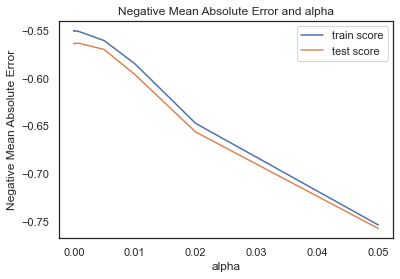

In [164]:
##Plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

##plotting
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()


In [165]:
# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0007)

In [166]:
# check the coefficient values with (lambda) alpha = 0.0007

lasso = Lasso(alpha=0.0007)
        
lasso.fit(X_train, y_train) 
print("Intercepts: ",lasso.intercept_)
print("Coefficients:\n",lasso.coef_)

Intercepts:  0.14072616127904408
Coefficients:
 [-0.25986716 -1.40188352 -1.02203193 -0.88182142 -1.63470625 -2.50833297
  1.3306781   1.25688669 -0.92601462 -0.72644958  1.0752186   0.86609379
 -1.18578559  0.87498612  0.79861529]


In [167]:
##Creating a dataframe of features and coefficients

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), \
                         'Abs_Coefficient_Lasso(Desc_Sort)':abs(lasso.coef_.round(4))})
##Sorting coefficient in descending order of absolute values and reset index
lasso_df = lasso_df.sort_values(by='Abs_Coefficient_Lasso(Desc_Sort)', ascending=False)
lasso_df.reset_index(drop=True, inplace=True)  

#lasso df
lasso_df.head(5)  #New Top5 features display (Lasso Model: Reiterated)

Features  Coefficient  Abs_Coefficient_Lasso(Desc_Sort)
0  du_Neighborhood_MeadowV      -2.5083                            2.5083
1   du_Neighborhood_IDOTRR      -1.6347                            1.6347
2   du_Neighborhood_BrDale      -1.4019                            1.4019
3  du_Neighborhood_NoRidge       1.3307                            1.3307
4  du_Neighborhood_NridgHt       1.2569                            1.2569

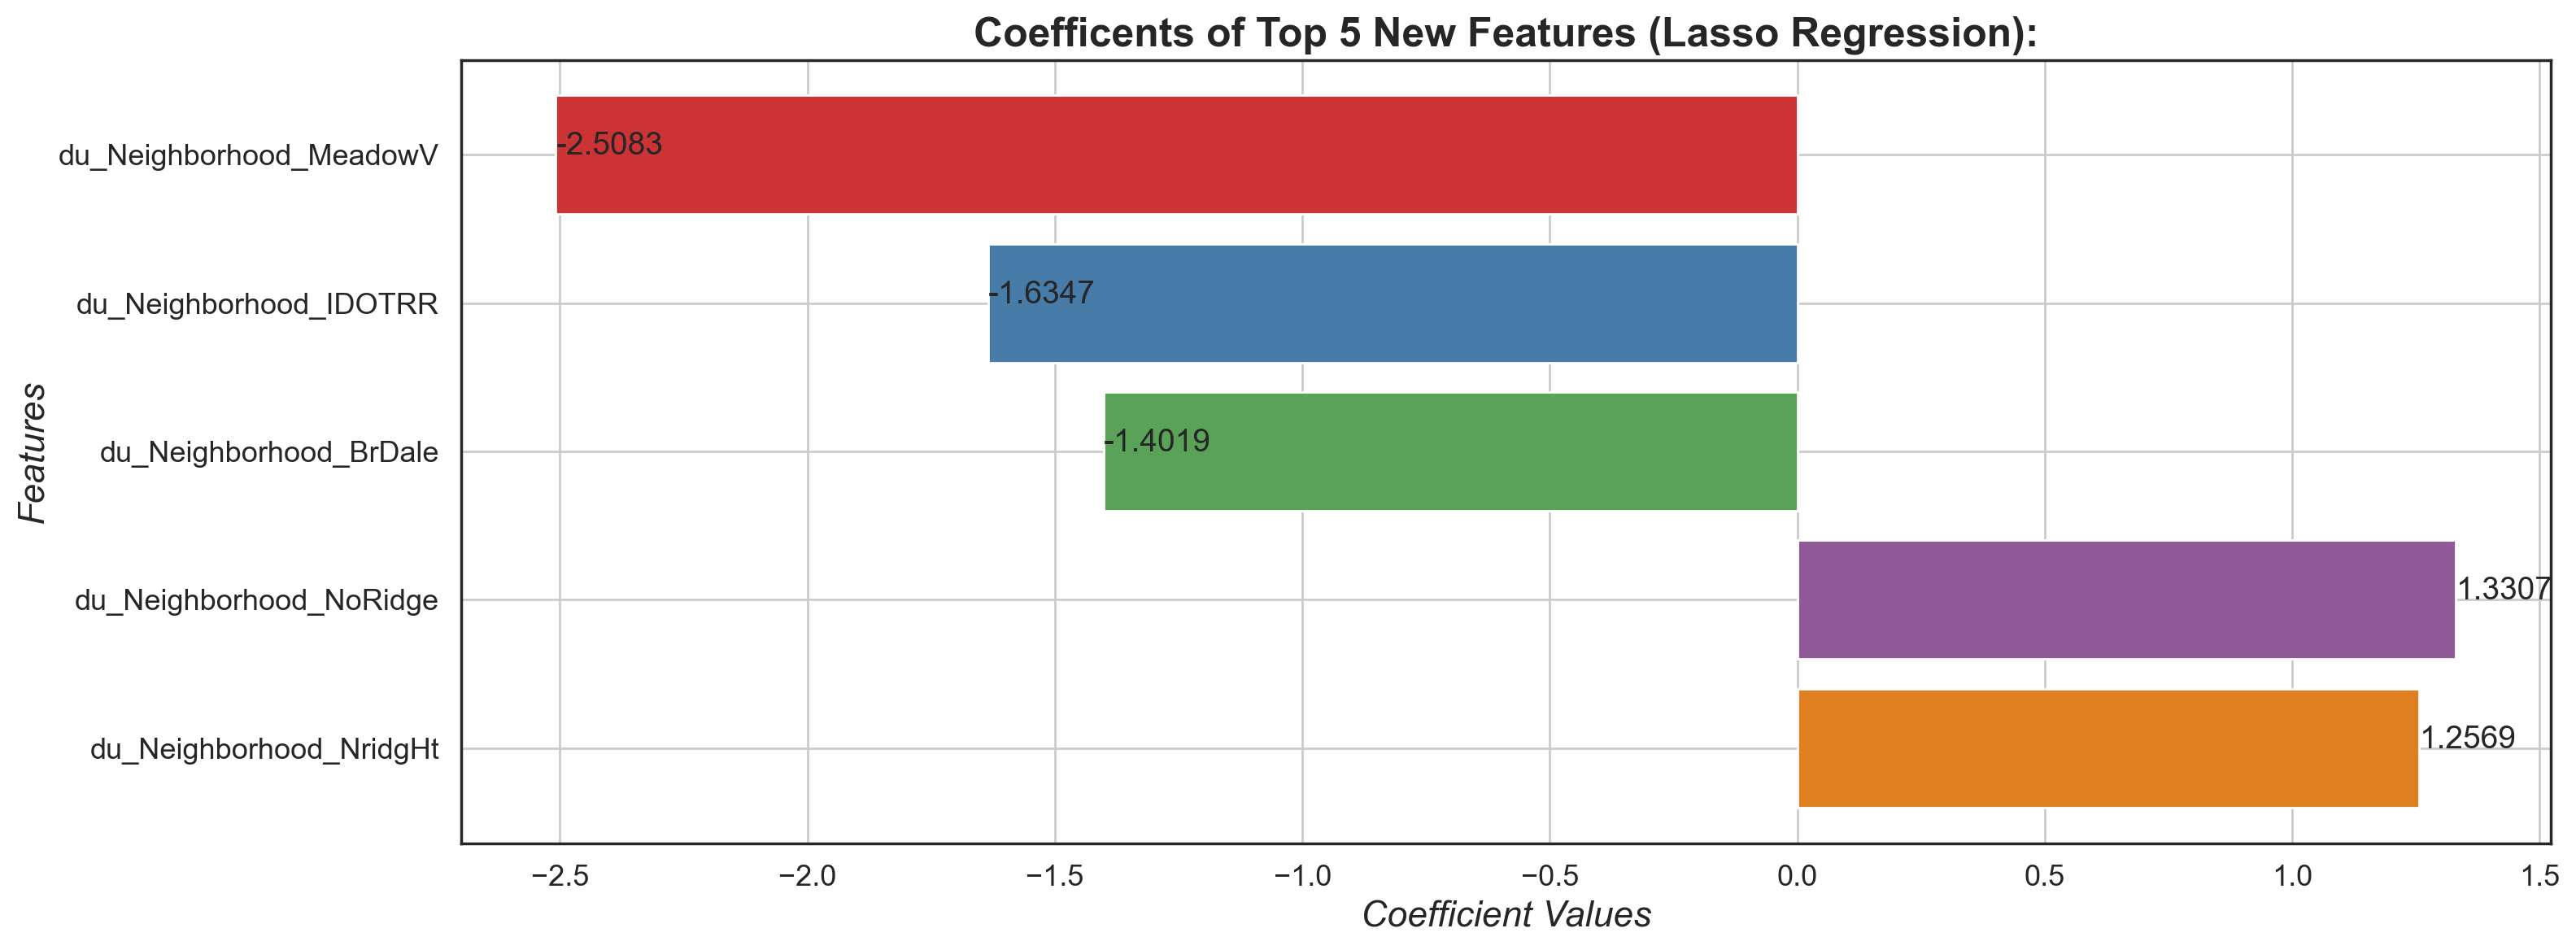

In [168]:
##Coefficient value plot (Lasso Regression)

top5_lasso_df= lasso_df.loc[:4] #'top5_lasso_df' datafram with top 5 features from the new model

sns.set(style='white')
plt.figure(figsize=(16,6), dpi=200)
ax4= sns.barplot(y=top5_lasso_df['Features'], x=top5_lasso_df['Coefficient'], palette='Set1')

plt.xlabel('Coefficient Values', fontsize= 16, fontstyle='italic')
plt.ylabel('Features' , fontsize= 16, fontstyle='italic')
plt.title('Coefficents of Top 5 New Features (Lasso Regression):', fontsize=18,fontweight='bold')

c= top5_lasso_df['Coefficient'] #Storing coefficient values
for index, value in enumerate(c):
    plt.text(value, index, str(value), fontsize=14)

plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.autoscale()
plt.tight_layout()
plt.show()


In [169]:
print("For New Lasso Regression Model (After eliminating the top5 features from the original model):\n","*"*114)
print("The top5 new most important predictor variables are as follows:\n\n",\
      list(top5_lasso_df['Features']),"\n", "*"*114)

For New Lasso Regression Model (After eliminating the top5 features from the original model):
 ******************************************************************************************************************
The top5 new most important predictor variables are as follows:

 ['du_Neighborhood_MeadowV', 'du_Neighborhood_IDOTRR', 'du_Neighborhood_BrDale', 'du_Neighborhood_NoRidge', 'du_Neighborhood_NridgHt'] 
 ******************************************************************************************************************


**<font color = 'Brown'> Question 4**

`How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?`